In [79]:
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import scipy
from scipy import stats
# from adjustText import adjust_text
from Bio import SeqIO
from Bio.Seq import Seq
%matplotlib inline


%load_ext autoreload
%autoreload 2

# import gzip
# from cyvcf2 import VCF

from matplotlib import gridspec
from matplotlib.gridspec import GridSpec

from itertools import combinations
from ast import literal_eval

import sys
import os

home_dir = '~/Documents/Stanford/Research/EvolvingFront/'
home_dir = os.path.expanduser(home_dir)

tools_path = f'{home_dir}/code/processing/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
merged_fitness = p.read_csv(f'{home_dir}/data/fitness_withMutations.csv',index_col=0)


In [81]:
### Draw the old pareto front line from Li et al 2019
old_muts = merged_fitness[merged_fitness['source_publication'].isin(['Venkataram2015','Li2019'])]

points = old_muts[['FerPerHour_Li2019','ResPerHour_Li2019']].values
points = points[~np.isnan(points).any(axis=1)]

hull = scipy.spatial.ConvexHull(points)

pareto_line = (list(points[hull.vertices,0][5:-1])+[0],list(points[hull.vertices,1][5:-1])+[np.nanmax(old_muts['ResPerHour_Li2019'].values)])

# plt.plot(pareto_line[0],pareto_line[1], 'r--', lw=2)
# plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')

In [82]:
### Now that we've drawn that line, let's purge the Li2019 mutants from the list


merged_fitness = merged_fitness[~merged_fitness['source_publication'].isin(['Li2019'])]

In [83]:
evo_cond_list = ['Evo1D','Evo2D','Evo3D']
anc_list = ['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']

for anc in anc_list:
    for evo_cond in evo_cond_list:
        this_pairing = merged_fitness[(merged_fitness['ancestor']==anc) & (merged_fitness['evolution_condition']==evo_cond)]
        
        print(anc,evo_cond,len(this_pairing))

WT Evo1D 0
WT Evo2D 506
WT Evo3D 0
CYR1 Evo1D 211
CYR1 Evo2D 535
CYR1 Evo3D 35
GPB2 Evo1D 169
GPB2 Evo2D 1219
GPB2 Evo3D 34
TOR1 Evo1D 203
TOR1 Evo2D 726
TOR1 Evo3D 2
IRA1_MIS Evo1D 191
IRA1_MIS Evo2D 143
IRA1_MIS Evo3D 32
IRA1_NON Evo1D 12
IRA1_NON Evo2D 95
IRA1_NON Evo3D 135


In [84]:
x = np.asarray([True,True,False,False])
y = np.asarray([False,True,False,True])

print(~x)

[False False  True  True]


In [85]:
def count_tradeoffs(data_x,data_y,
                    error_x,error_y,
                    background_data_x,background_data_y,
                    background_error_x,background_error_y,
                    multiplier=1.96,use_both_errors=False):
    
    if not use_both_errors:
    
        x_improved = (data_x>(background_data_x+multiplier*background_error_x))
        y_improved = (data_y>(background_data_y+multiplier*background_error_y))

        x_reduced = (data_x<(background_data_x-multiplier*background_error_x))
        y_reduced = (data_y<(background_data_y-multiplier*background_error_y))

        x_same = np.logical_and(~x_reduced,~x_improved)
        y_same = np.logical_and(~y_reduced,~y_improved)

    #     both_improved = np.logical_and(x_improved,y_improved)


        improvement_matrix = [[np.logical_and(x_reduced,y_reduced),np.logical_and(x_reduced,y_same),np.logical_and(x_reduced,y_improved)],
                              [np.logical_and(x_same,y_reduced),np.logical_and(x_same,y_same),np.logical_and(x_same,y_improved)],
                              [np.logical_and(x_improved,y_reduced),np.logical_and(x_improved,y_same),np.logical_and(x_improved,y_improved)]
                             ]

        both_indices = np.where(improvement_matrix[2][2])[0]

        improvement_matrix = [[np.sum(improvement_matrix[x][y]) for y in range(3)] for x in range(3)]
        
    else:
        scipy.stats.ttest_ind_from_stats(data_x,error_x)
    
    
    return improvement_matrix,len(data_x),both_indices

In [ ]:
colors = [tools.anc_color_map[anc] for anc in merged_fitness['ancestor']]
# colors = ['b' if source=='This_study' else 'r' if source=='Li2019' else 'orange' if source == 'Aggeli2020' else 'k' for source in nonan_merged['source_publication_x']]

# non_diploid = merged_fitness[merged_fitness['ploidy']!='Diploid']

xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

xlabel = 'Stationary per Hour'
ylabel = 'Respiration per Hour'
xdata = 'StaPerHour'
ydata = 'ResPerHour'
labels = {'FerPerHour':'Fermentation per Hour','ResPerHour':'Respiration per Hour','StaPerHour':'Stationary per Hour'}
lims = {'FerPerHour':[-0.05,0.07],'ResPerHour':[-0.05,0.12],'StaPerHour':[-0.09,0.045]}

# evo_cond_list = ['Evo1D']
# evo_cond_list = ['Evo2D']
# evo_cond_list = ['Evo3D']
evo_cond_list = ['Evo1D','Evo2D','Evo3D']

fitness_colorby = 'Fit2D_early_fitness'
fitness_colorby = 'Fit3D_early_fitness'
fitness_colorby = 'StaPerHour'

errorbar = True


# cutoff for standard deviation
multiplier = 1.0

innovation_list = {}

noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']

for evo_cond in evo_cond_list:
    for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
    # publication_list = [['This_study','Li2019','Aggeli2020','Venkataram2015'],['Venkataram2015'],['Li2019'],['Aggeli2020'],['This_study'],['Venkataram2015','This_study']] 
        ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]
        fig = plt.figure(figsize=(12,14))
        outer_gs = gridspec.GridSpec(2, 1,height_ratios=[6,8])

        inner_gs1 = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec = outer_gs[0],width_ratios=[6,1,1],wspace=0.25,hspace=0.25)
        inner_gs2 = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec = outer_gs[1],wspace=0.25,hspace=0.25)


        for a,ancs in enumerate(ancestor_list):

    #         this_anc = non_diploid[non_diploid['ancestor'].isin(ancs)]

            this_anc = noLi2019[noLi2019['ancestor'].isin(ancs)]

            these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
            these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

            interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
#             interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]

            if len(ancs) > 1:
                fig.add_subplot(inner_gs1[0]) 
            else:
                fig.add_subplot(inner_gs2[a-1])

    #         plt.gca().set_facecolor('lightgrey')

            for anc in ancs:
#                 if anc != 'WT':
                this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]

                sns.kdeplot(x=this_pure_diploid[xdata].values,y=this_pure_diploid[ydata].values,
                            color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4,linestyles='--')

                this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]

                sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
                            color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)
                
            interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
            this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
            gray_alpha = 0.1
            bold_alpha = 0.5

            if len(ancs) > 1:
                alpha = 0.2
#                 normalize = matplotlib.colors.TwoSlopeNorm(vmin=-1*np.abs(merged_fitness[fitness_colorby]).max(),
#                                                 vcenter=0., 
#                                                 vmax=np.abs(merged_fitness[fitness_colorby]).max())

#                 sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
#                             c=this_data[fitness_colorby].values,cmap='RdBu',
#                             norm=normalize,
#                             marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
                sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
                            color=[tools.anc_color_map[anc] for anc in this_data['ancestor'].values],
                            alpha=alpha,
                            marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
                     
                if errorbar:
                    plt.errorbar(x=this_data[xdata].values,y=this_data[ydata].values,
                                     xerr=2*this_data[xdata+'_error'].values,yerr=2*this_data[ydata+'_error'].values,
                                 ms=0,linestyle='',
                            alpha=alpha,
                            marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')


            else:
                alpha = 0.3
#                 normalize = matplotlib.colors.TwoSlopeNorm(vmin=-1*np.abs(merged_fitness[fitness_colorby]).max(),
#                                                 vcenter=0., 
#                                                 vmax=np.abs(merged_fitness[fitness_colorby]).max())

#                 sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
#                             c=this_data[fitness_colorby].values,cmap='RdBu',
#                             norm=normalize,
#                             marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
                sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
                            color=[tools.anc_color_map[anc] for anc in this_data['ancestor'].values],
                            alpha=alpha,
                            marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
                
                for anc in this_data['ancestor'].values
            
                    
                if errorbar:
                    
                    
                    
                    
                    
                    plt.errorbar(x=this_data[xdata].values,y=this_data[ydata].values,
                                     xerr=2*this_data[xdata+'_error'].values,yerr=2*this_data[ydata+'_error'].values,
                                 ms=0,linestyle='',
                            alpha=alpha,
                            marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')

                plt.legend(loc='lower left',fontsize='small')
                plt.title(f'{ancs[0]}')

            for anc in ancs:
                if anc != 'WT':
                    background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

                    plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                marker='+',color=tools.anc_color_map[anc],s=100)

                    if len(ancs) < 2:

                        plt.axvspan(background_mutant[xdata].values-multiplier*background_mutant[xdata+'_error'].values,
                                  background_mutant[xdata].values+multiplier*background_mutant[xdata+'_error'].values,
                                  color=tools.anc_color_map[anc],alpha=0.05)

                        plt.axhspan(background_mutant[ydata].values-multiplier*background_mutant[ydata+'_error'].values,
                                  background_mutant[ydata].values+multiplier*background_mutant[ydata+'_error'].values,
                                  color=tools.anc_color_map[anc],alpha=0.05)

                        tradeoffs,n_obs,indices = count_tradeoffs(interesting_muts[xdata].values,interesting_muts[ydata].values,
                                 background_mutant[xdata].values,background_mutant[ydata].values,
                                background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                                multiplier=multiplier)

                        va_dict = {0:'bottom',1:'center',2:'top'}
                        ha_dict = {0:'left',1:'center',2:'right'}

                        offset = 0.01

                        for (x,y) in [(0,2),(2,0),(1,2),(2,1),(2,2)]:
                            if x == 1:
                                loc_x = (background_mutant[xdata].values[0]-tools.lims[xdata][0])/(tools.lims[xdata][1]-tools.lims[xdata][0])
                            elif x == 0:
                                loc_x = x/2 + offset
                            else:
                                loc_x = x/2 - offset

                            if y == 1:
                                loc_y = (background_mutant[ydata].values[0]-tools.lims[ydata][0])/(tools.lims[ydata][1]-tools.lims[ydata][0])
                            elif y == 0:
                                loc_y = y/2 + offset
                            else:
                                loc_y = y/2 - offset

                            plt.text(s=f'{tradeoffs[x][y]}/{n_obs}\n({tradeoffs[x][y]/n_obs:.0%})',
                                         x=loc_x,y=loc_y,transform=plt.gca().transAxes,
                                         ha=ha_dict[x],va=va_dict[y])

                else:
                    tradeoffs,n_obs,indices = count_tradeoffs(interesting_muts[xdata].values,interesting_muts[ydata].values,
                                 0,0,0,0,
                                multiplier=multiplier)

                    va_dict = {0:'bottom',1:'center',2:'top'}
                    ha_dict = {0:'left',1:'center',2:'right'}

                    offset = 0.01

                    for (x,y) in [(0,2),(2,0),(2,2)]:
                        if x == 1:
                            loc_x = (background_mutant[xdata].values[0]-tools.lims[xdata][0])/(tools.lims[xdata][1]-tools.lims[xdata][0])
                        elif x == 0:
                            loc_x = x/2 + offset
                        else:
                            loc_x = x/2 - offset

                        if y == 1:
                            loc_y = (background_mutant[ydata].values[0]-tools.lims[ydata][0])/(tools.lims[ydata][1]-tools.lims[ydata][0])
                        elif y == 0:
                            loc_y = y/2 + offset
                        else:
                            loc_y = y/2 - offset

                        plt.text(s=f'{tradeoffs[x][y]}/{n_obs}\n({tradeoffs[x][y]/n_obs:.0%})',
                                     x=loc_x,y=loc_y,transform=plt.gca().transAxes,
                                     ha=ha_dict[x],va=va_dict[y])


                    for anc2 in tools.rebarcoding_source_mutants.keys():
                        background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc2]]

                        plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                marker='+',color=tools.anc_color_map[anc2],s=100)


    #                     tradeoffs = count_tradeoffs(this_data[xdata].values,this_data[ydata].values,
    #                                      background_mutant[xdata].values,background_mutant[ydata].values)

    #                     print(tradeoffs)
            if xdata == 'FerPerHour' and ydata == 'ResPerHour':
                plt.plot(pareto_line[0],pareto_line[1],color='gray',lw=1)

            plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
            plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])

            plt.xlabel(labels[xdata])
            plt.ylabel(labels[ydata])

    #         plt.axvline(0,color='k',linestyle=':')
    #         plt.axhline(0,color='k',linestyle=':')

            plt.axvline(0,color='gray',linestyle=':')
            plt.axhline(0,color='gray',linestyle=':')

    #         if len(ancs) > 1:
    #             for g,gene in enumerate(tools.mutation_color_map.keys()):
    #                 plt.text(y=0.5-0.02*g,x=0.02,s=f'{gene}',color=tools.mutation_color_map[gene],transform=plt.gca().transAxes)
    #         if len(ancs) > 1:
    #             cmap = plt.get_cmap('RdBu')

    #             vmin = np.nanmin(merged_fitness[fitness_colorby])
    #             vmax = np.round(np.nanmax(merged_fitness[fitness_colorby]),2)

    #             norm2 = matplotlib.colors.Normalize(vmin=vmin, vmax =vmax)

    #             total_len = 2*np.abs(merged_fitness[fitness_colorby]).max()

    #         #     these_colors = cmap(np.linspace(1.-(vmax-vmin)/float(vmax), 1, cmap.N))
    #             these_colors = cmap(np.linspace(0,(vmax-vmin)/total_len, cmap.N))

    #             color_map = matplotlib.colors.LinearSegmentedColormap.from_list('RdBu', these_colors)

    #             # create some axes to put the colorbar to
    #             cax, _  = matplotlib.colorbar.make_axes_gridspec(plt.gca(),location='right')
    #             cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=color_map, norm=norm2,)

    #             cbar.set_ticks(np.round(np.linspace(-0.1,0.02,7),2))
    #             cbar.set_ticklabels(np.round(np.linspace(-0.1,0.02,7),2))


        plt.tight_layout()
        if not errorbar:
            plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_improvement_{evo_cond}only.pdf',bbox_inches='tight')
            plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_improvement_{evo_cond}only.png',bbox_inches='tight',dpi=300)
        else:
            plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_improvement_{evo_cond}only_errorbar.pdf',bbox_inches='tight')
            plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_improvement_{evo_cond}only_errorbar.png',bbox_inches='tight',dpi=300)



innovation_list = {}

total_tradeoffs_dict = {}

for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
    print(xdata,ydata)
    
    innovation_list[f'{xdata}_{ydata}'] = {}
    total_tradeoffs_dict[f'{xdata}_{ydata}'] = {}
    
    
    for anc in ancestor_list[0][1:]:
        
        
        
        this_anc = noLi2019[noLi2019['ancestor'].isin([anc])]

        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
        background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

        total_tradeoffs = count_tradeoffs(interesting_muts[xdata].values,interesting_muts[ydata].values,
                             background_mutant[xdata].values,background_mutant[ydata].values,
                            background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                            multiplier=multiplier)
        
        innovation_list[f'{xdata}_{ydata}'][f'{anc}'] = interesting_muts['barcode'].values[total_tradeoffs[-1]]
        
        
        print(anc,total_tradeoffs[:-1])
        for evo_set in [['Evo1D'],['Evo2D'],['Evo3D']]:

            this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_set)]

            tradeoffs = count_tradeoffs(this_data[xdata].values,this_data[ydata].values,
                             background_mutant[xdata].values,background_mutant[ydata].values,
                            background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                            multiplier=multiplier)
            
            if anc == 'CYR1':
                total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]] = np.asarray(tradeoffs[0])
            else:
                total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]] += np.asarray(tradeoffs[0])
            
            print(anc,evo_set,tradeoffs,total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]])
            
            
            
#             total_tradeoffs += tradeoffs 

            print(anc,evo_set,tradeoffs[:-1])

print('Improved Both')
for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
    for evo_cond in ['Evo1D','Evo2D','Evo3D']:
        print(xdata,ydata,evo_cond,'improved both:',
              f"{total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond][2][2]}/{np.sum(total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond])}",
              total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond][2][2]/np.sum(total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond])
             )
        
print('improved respiration')
resp_up = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'][:,2])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'][:,2])
all_2_3 = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'])
print(f'{resp_up}/{all_2_3}',resp_up/all_2_3)
print('improved respiration')
resp_up_fer_down = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'][0,2])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'][0,2])
all_2_3 = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'])
print(f'{resp_up_fer_down}/{all_2_3}',resp_up_fer_down/all_2_3)

3       IRA1_NON
7       IRA1_NON
9       IRA1_NON
11      IRA1_NON
13      IRA1_NON
          ...   
4567    IRA1_NON
4648    IRA1_NON
4672    IRA1_NON
4683    IRA1_NON
4872    IRA1_NON
Name: ancestor, Length: 242, dtype: object

/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_35912/3623049400.py:204: RuntimeWarning: invalid value encountered in long_scalars
  plt.text(s=f'{tradeoffs[x][y]}/{n_obs}\n({tradeoffs[x][y]/n_obs:.0%})',
/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/Users/grantkinsler/Libr

/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

FerPerHour ResPerHour
CYR1 ([[0, 0, 46], [0, 0, 5], [5, 1, 48]], 105)
CYR1 ['Evo1D'] ([[0, 0, 1], [0, 0, 1], [0, 1, 1]], 4, array([0])) [[0 0 1]
 [0 0 1]
 [0 1 1]]
CYR1 ['Evo1D'] ([[0, 0, 1], [0, 0, 1], [0, 1, 1]], 4)
CYR1 ['Evo2D'] ([[0, 0, 29], [0, 0, 3], [5, 0, 42]], 79, array([ 0,  2,  4,  5,  7,  9, 12, 14, 16, 18, 19, 20, 24, 26, 31, 34, 35,
       37, 38, 39, 41, 42, 43, 44, 45, 47, 48, 49, 52, 55, 56, 58, 60, 61,
       62, 63, 64, 65, 66, 74, 77, 78])) [[ 0  0 29]
 [ 0  0  3]
 [ 5  0 42]]
CYR1 ['Evo2D'] ([[0, 0, 29], [0, 0, 3], [5, 0, 42]], 79)
CYR1 ['Evo3D'] ([[0, 0, 16], [0, 0, 1], [0, 0, 5]], 22, array([ 3, 11, 12, 14, 20])) [[ 0  0 16]
 [ 0  0  1]
 [ 0  0  5]]
CYR1 ['Evo3D'] ([[0, 0, 16], [0, 0, 1], [0, 0, 5]], 22)
GPB2 ([[2, 1, 43], [0, 0, 3], [3, 0, 20]], 72)
GPB2 ['Evo1D'] ([[0, 0, 2], [0, 0, 0], [0, 0, 5]], 7, array([0, 1, 2, 4, 6])) [[0 0 3]
 [0 0 1]
 [0 1 6]]
GPB2 ['Evo1D'] ([[0, 0, 2], [0, 0, 0], [0, 0, 5]], 7)
GPB2 ['Evo2D'] ([[2, 1, 29], [0, 0, 3], [3, 0, 14]], 52

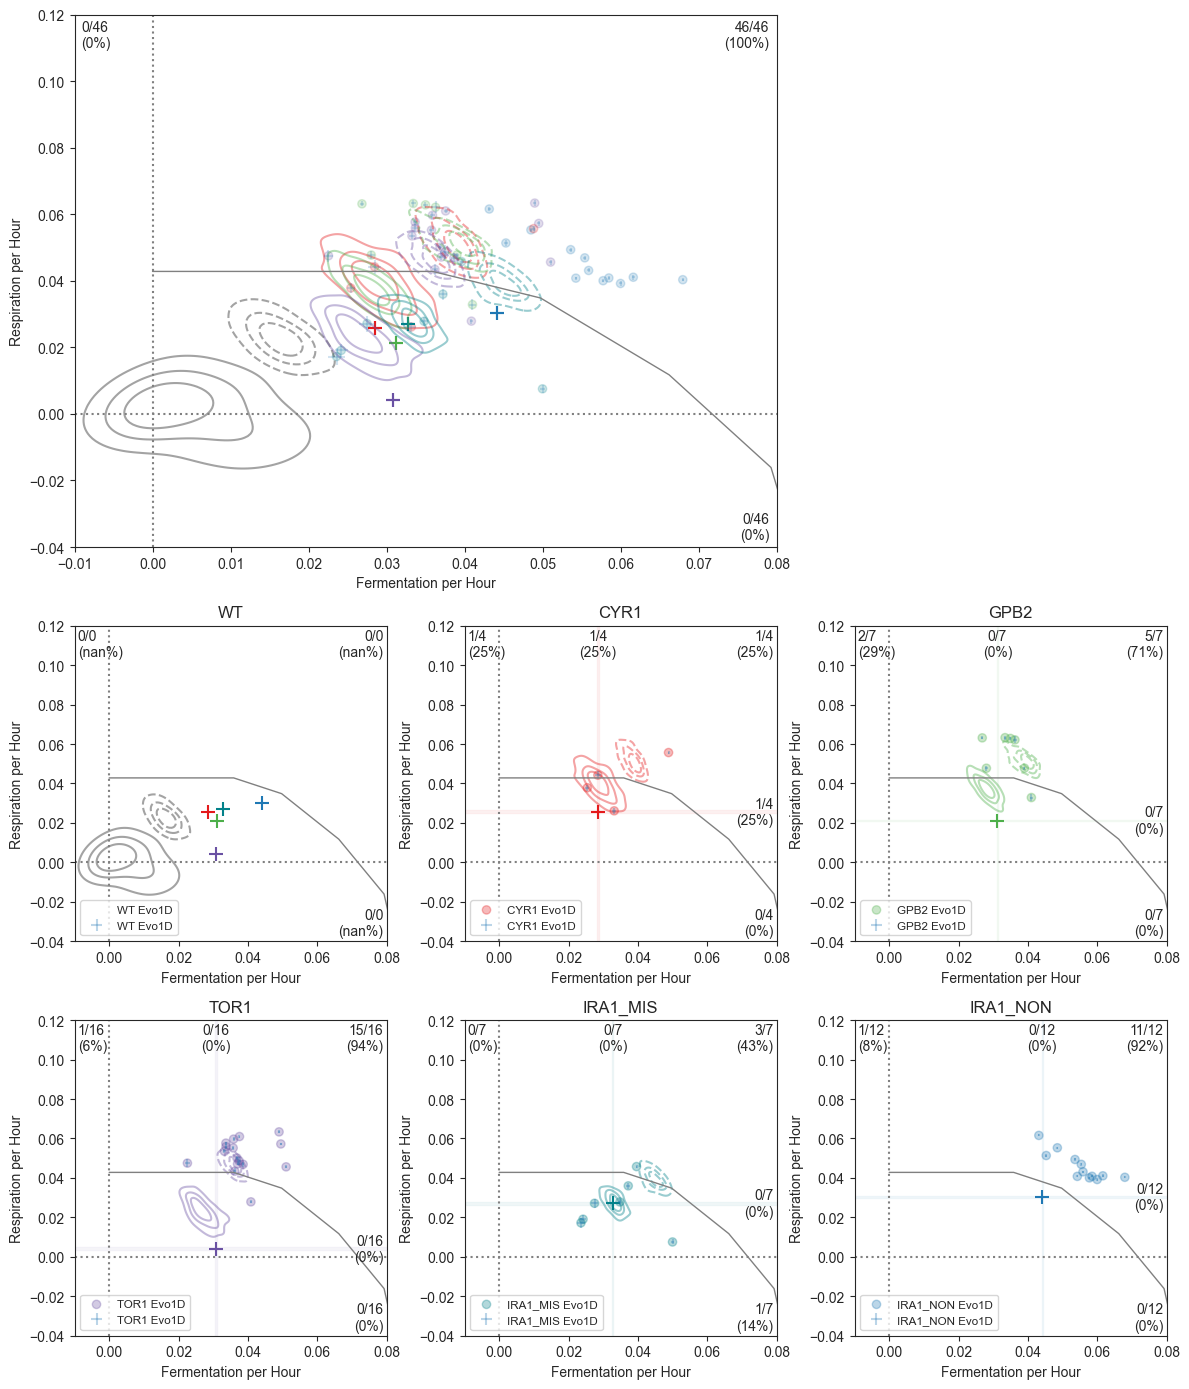

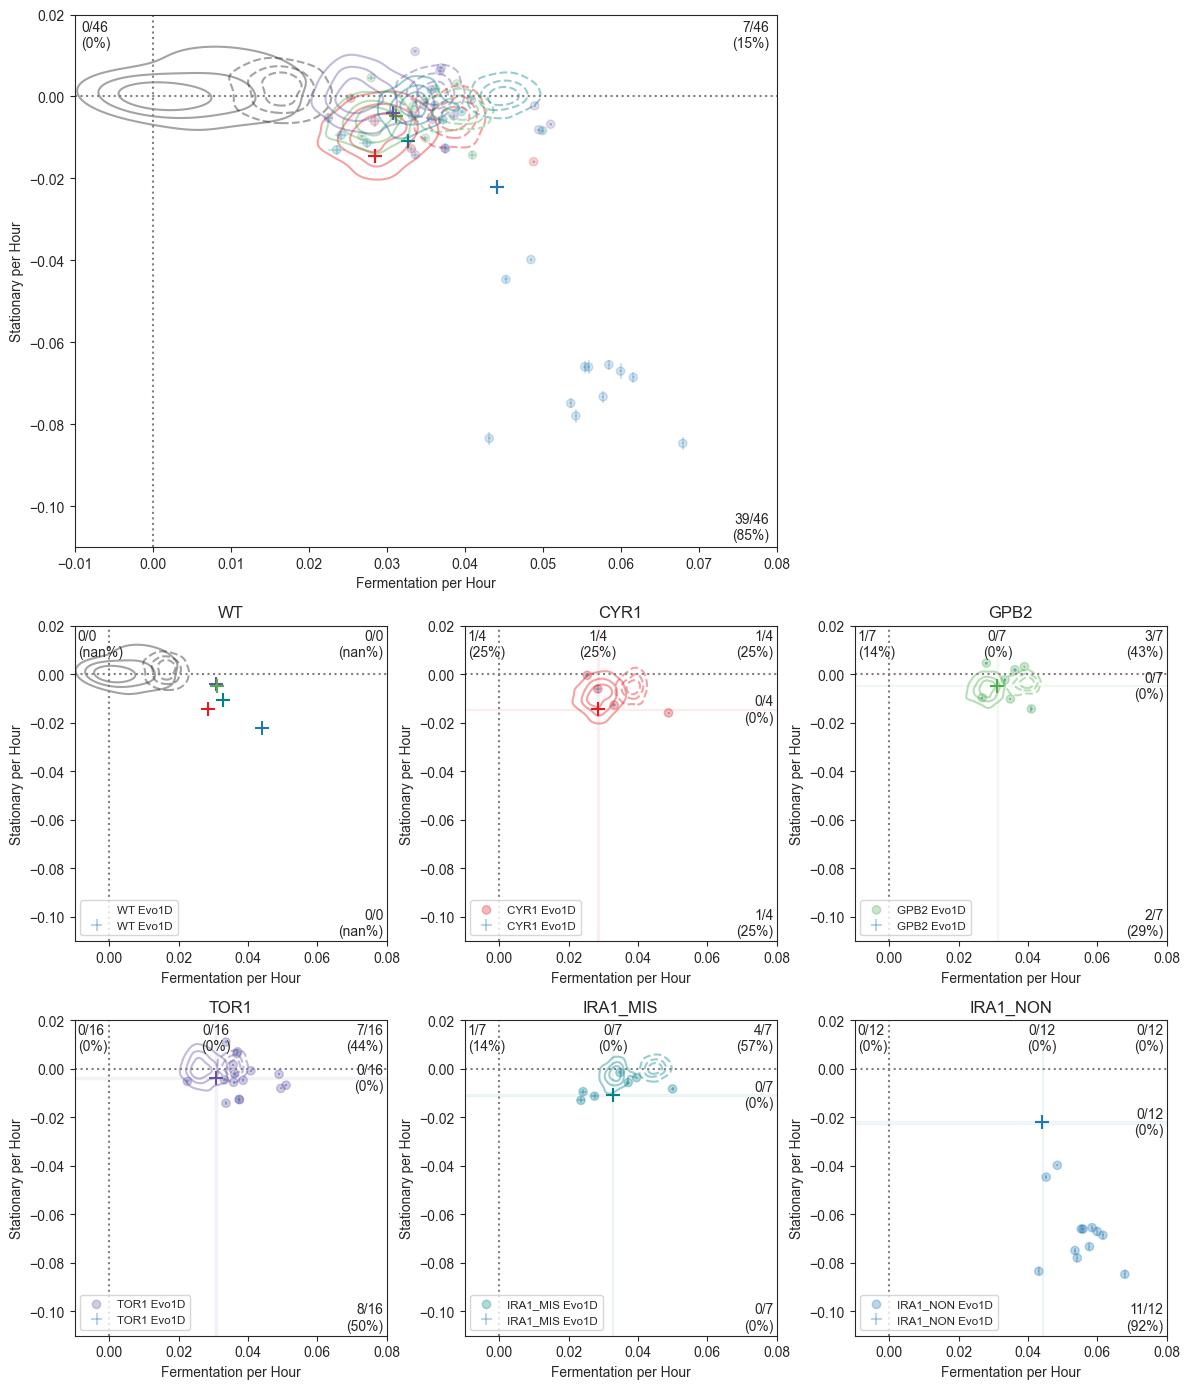

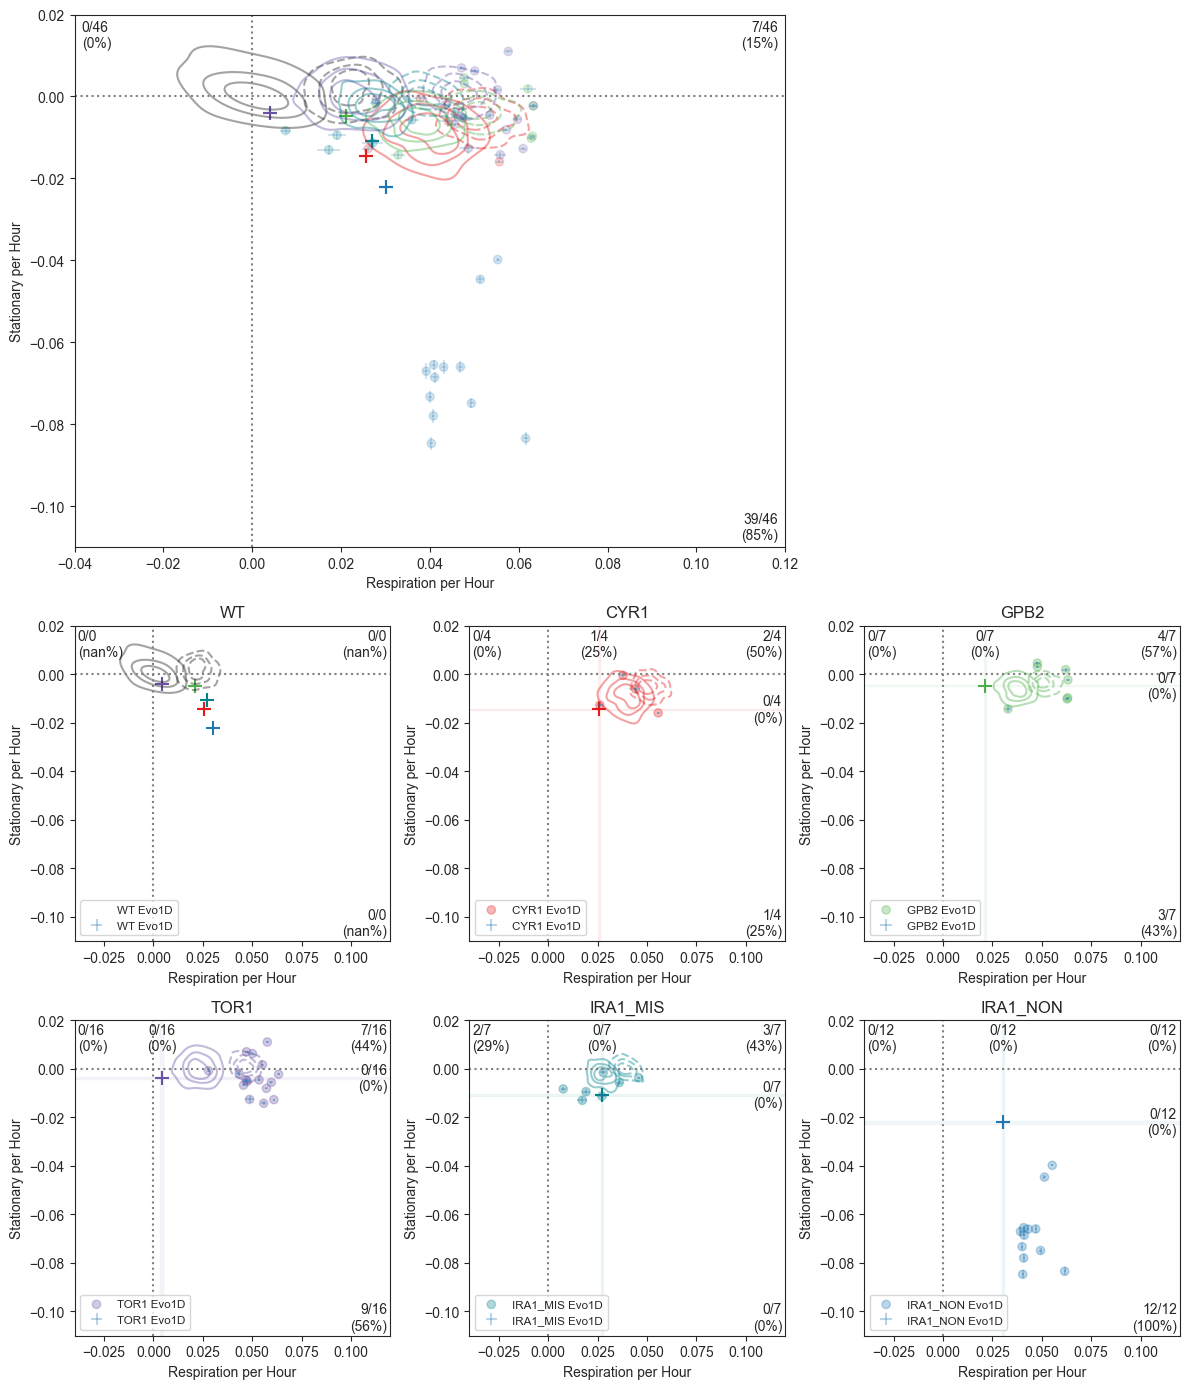

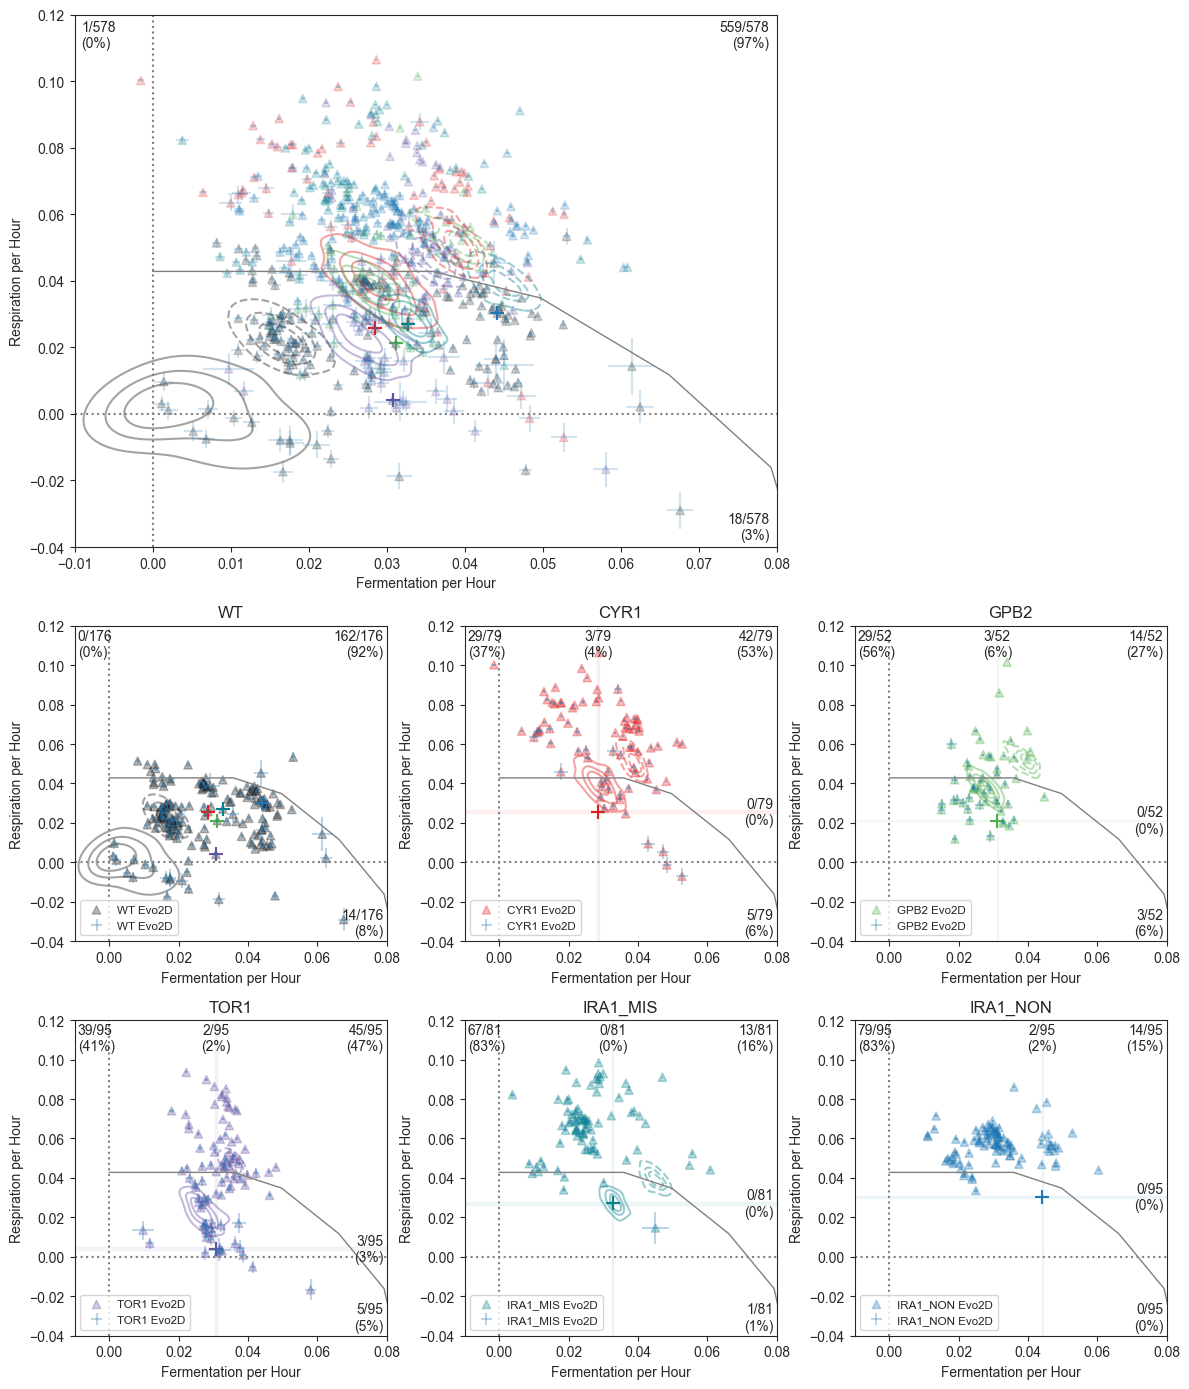

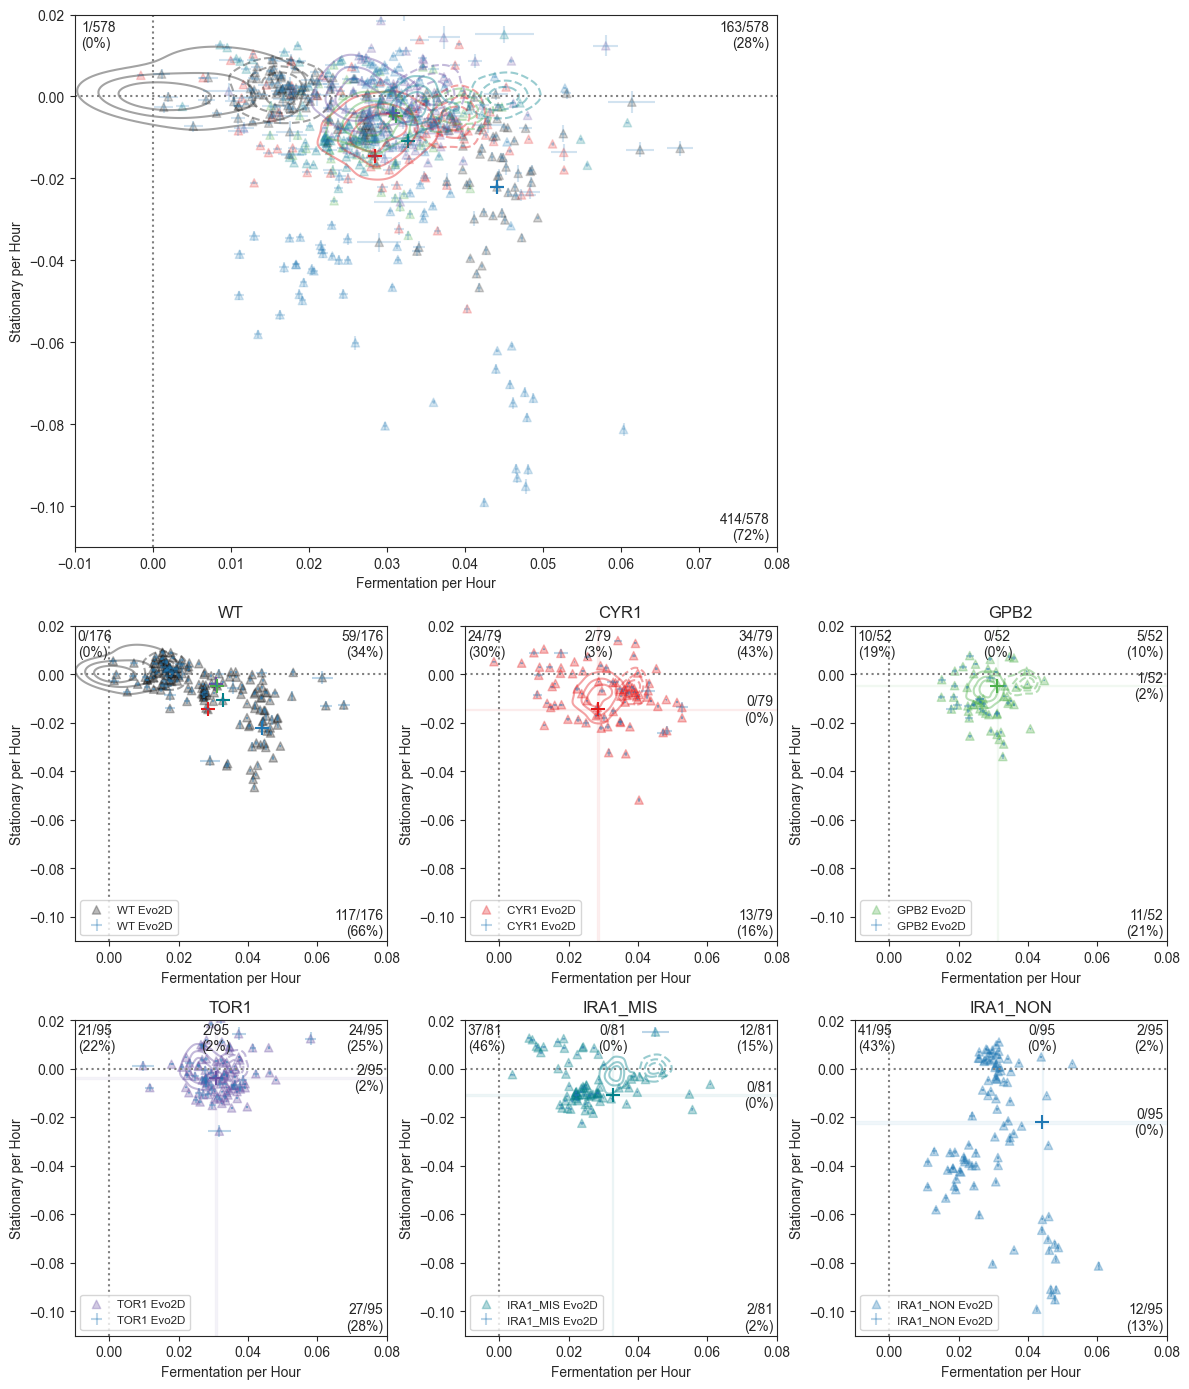

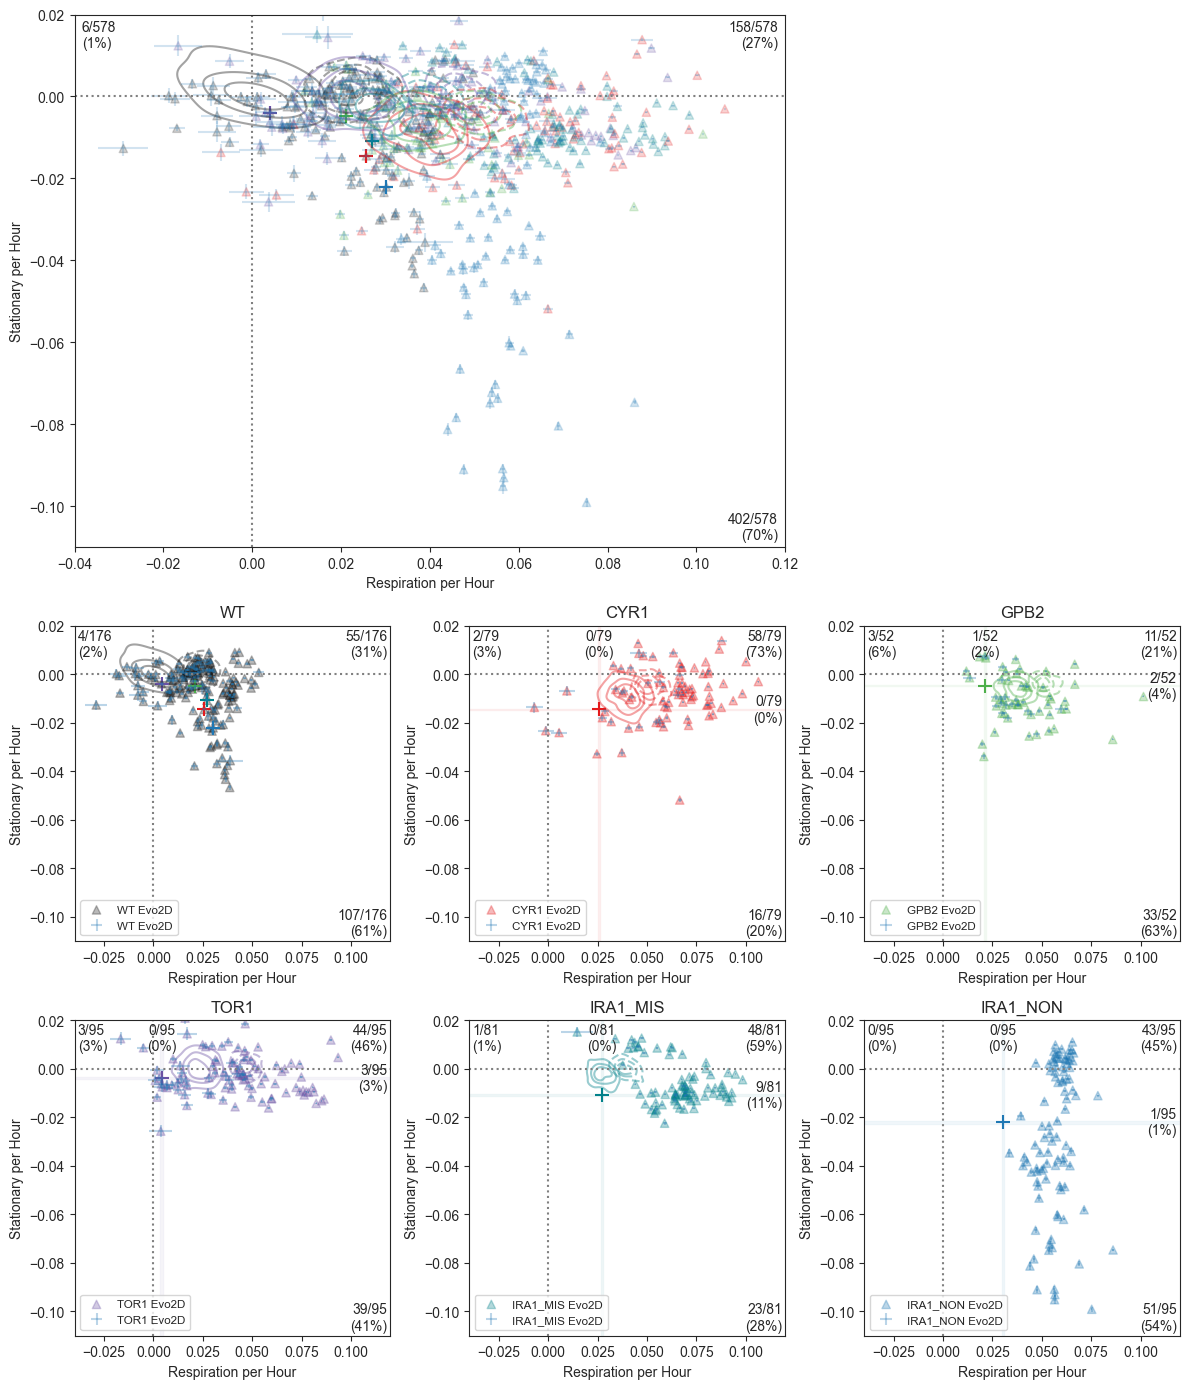

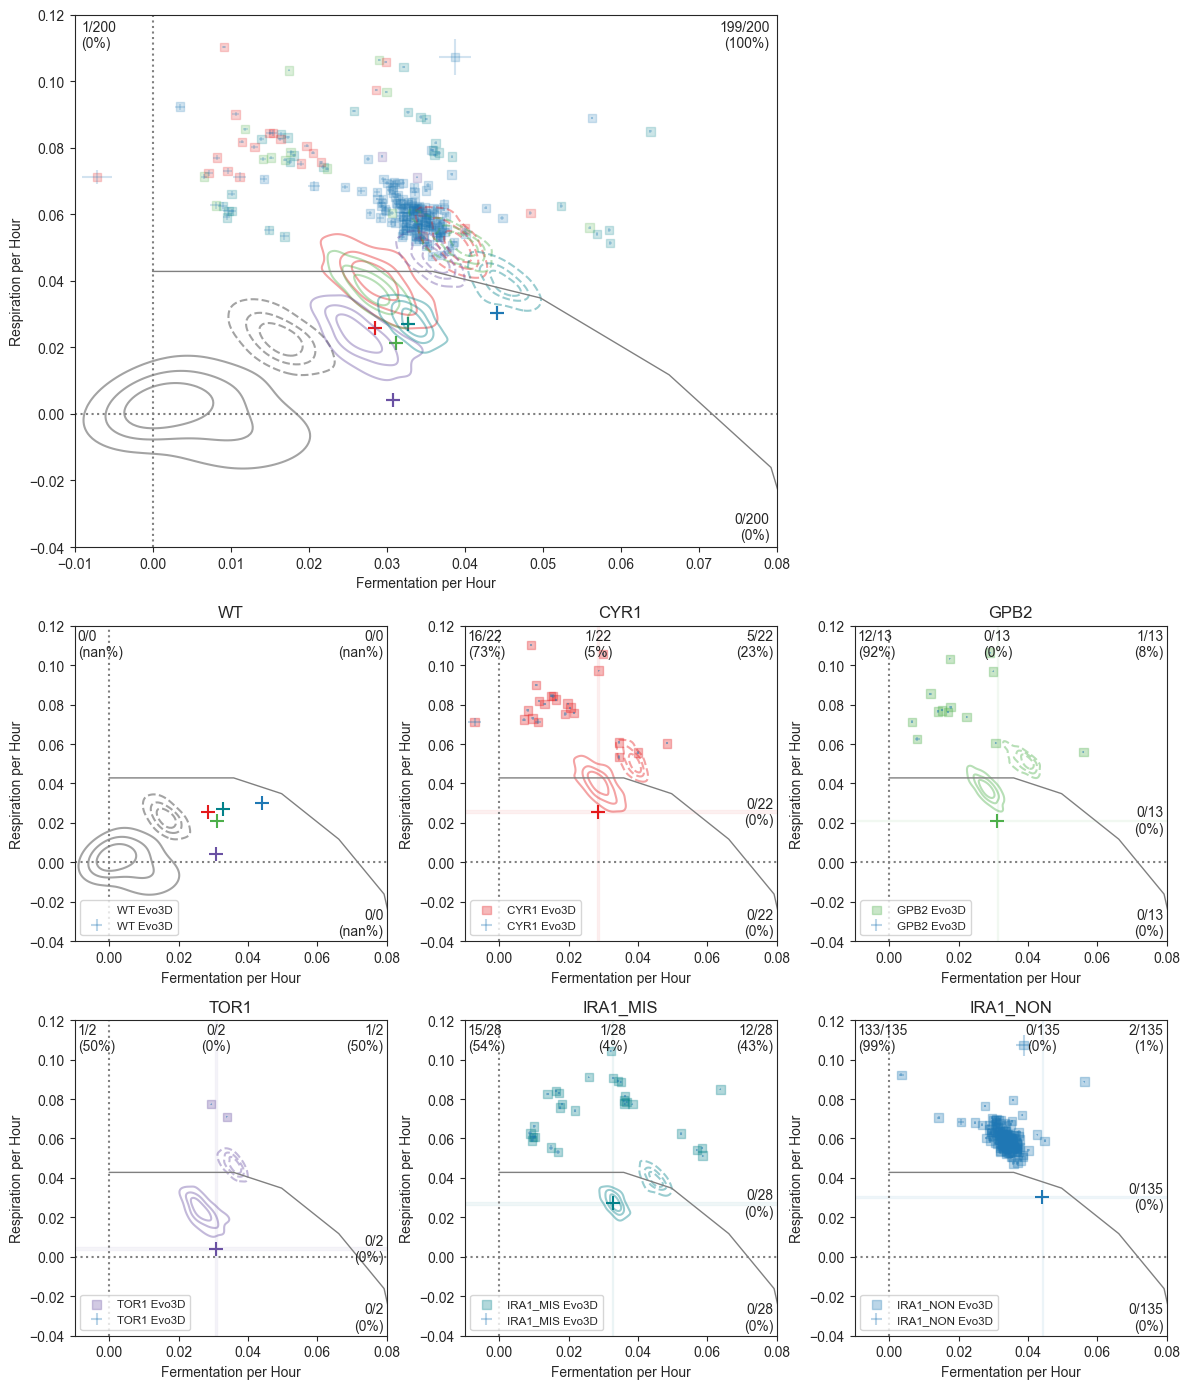

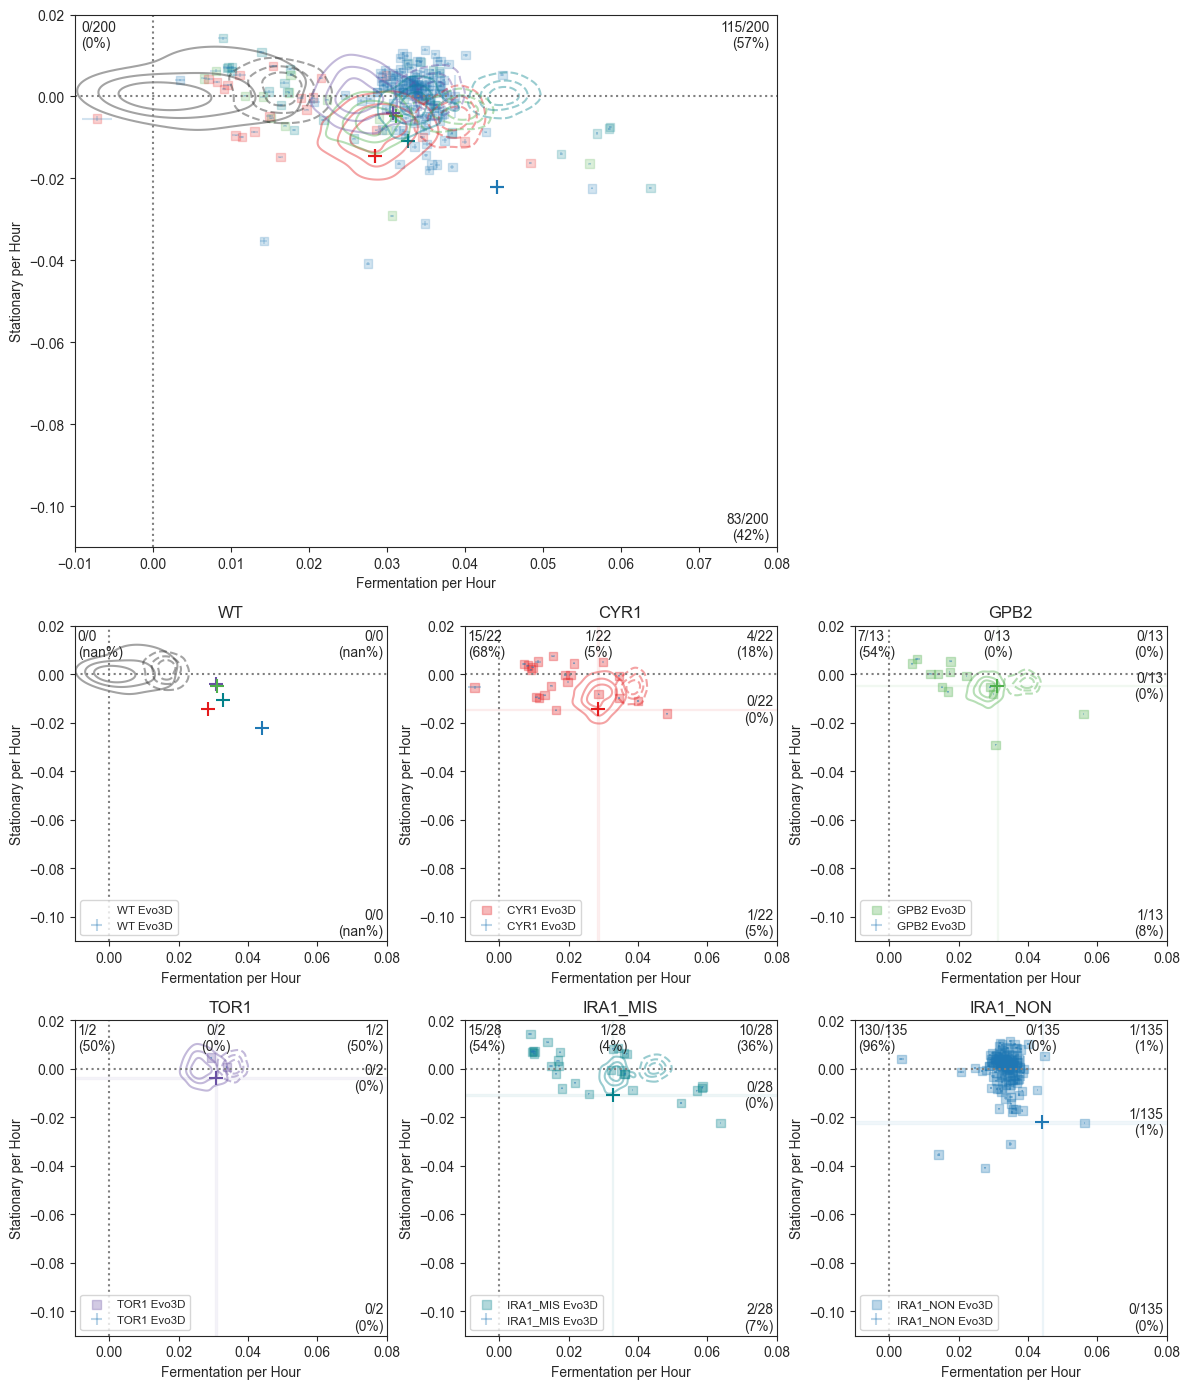

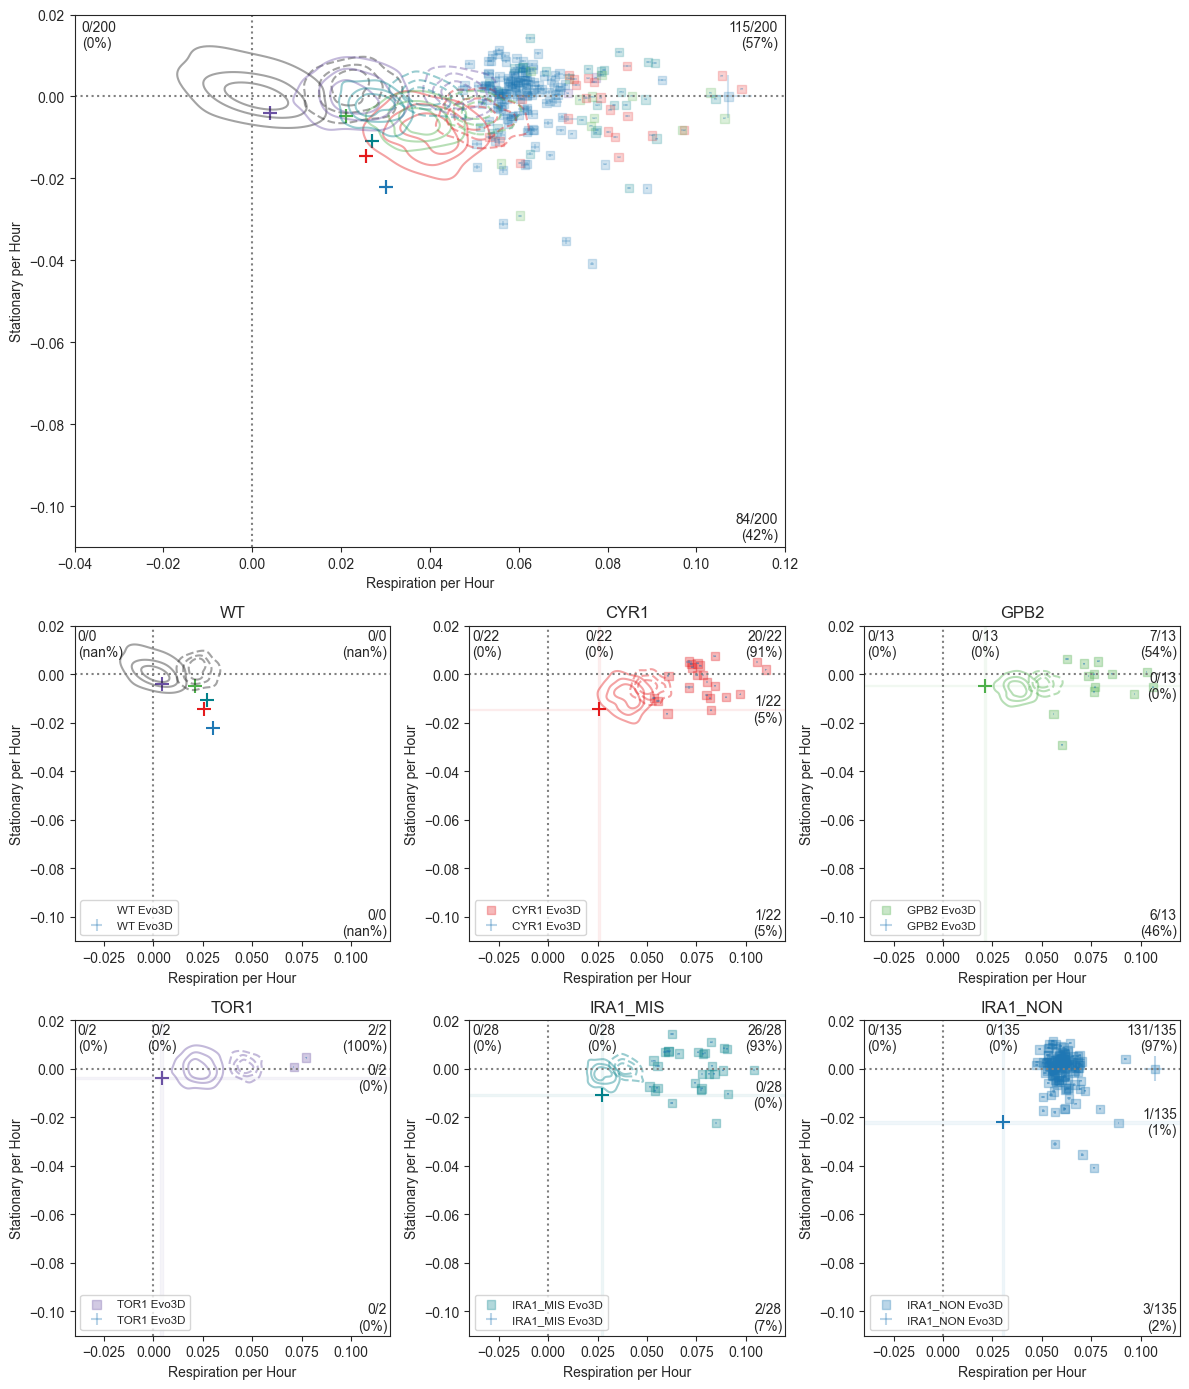

In [94]:
colors = [tools.anc_color_map[anc] for anc in merged_fitness['ancestor']]
# colors = ['b' if source=='This_study' else 'r' if source=='Li2019' else 'orange' if source == 'Aggeli2020' else 'k' for source in nonan_merged['source_publication_x']]

# non_diploid = merged_fitness[merged_fitness['ploidy']!='Diploid']

xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

xlabel = 'Stationary per Hour'
ylabel = 'Respiration per Hour'
xdata = 'StaPerHour'
ydata = 'ResPerHour'
labels = {'FerPerHour':'Fermentation per Hour','ResPerHour':'Respiration per Hour','StaPerHour':'Stationary per Hour'}
lims = {'FerPerHour':[-0.05,0.07],'ResPerHour':[-0.05,0.12],'StaPerHour':[-0.09,0.045]}

# evo_cond_list = ['Evo1D']
# evo_cond_list = ['Evo2D']
# evo_cond_list = ['Evo3D']
evo_cond_list = ['Evo1D','Evo2D','Evo3D']

fitness_colorby = 'Fit2D_early_fitness'
fitness_colorby = 'Fit3D_early_fitness'
fitness_colorby = 'StaPerHour'

errorbar = True


# cutoff for standard deviation
multiplier = 1.0

innovation_list = {}

noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']

for evo_cond in evo_cond_list:
    for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
    # publication_list = [['This_study','Li2019','Aggeli2020','Venkataram2015'],['Venkataram2015'],['Li2019'],['Aggeli2020'],['This_study'],['Venkataram2015','This_study']] 
        ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]
        fig = plt.figure(figsize=(12,14))
        outer_gs = gridspec.GridSpec(2, 1,height_ratios=[6,8])

        inner_gs1 = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec = outer_gs[0],width_ratios=[6,1,1],wspace=0.25,hspace=0.25)
        inner_gs2 = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec = outer_gs[1],wspace=0.25,hspace=0.25)


        for a,ancs in enumerate(ancestor_list):

    #         this_anc = non_diploid[non_diploid['ancestor'].isin(ancs)]

            this_anc = noLi2019[noLi2019['ancestor'].isin(ancs)]

            these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
            these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

            interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
#             interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]

            if len(ancs) > 1:
                fig.add_subplot(inner_gs1[0]) 
            else:
                fig.add_subplot(inner_gs2[a-1])

    #         plt.gca().set_facecolor('lightgrey')

            for anc in ancs:
#                 if anc != 'WT':
                this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]

                sns.kdeplot(x=this_pure_diploid[xdata].values,y=this_pure_diploid[ydata].values,
                            color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4,linestyles='--')

                this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]

                sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
                            color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)
                
            interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
            this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
            gray_alpha = 0.1
            bold_alpha = 0.5

            if len(ancs) > 1:
                alpha = 0.2
#                 normalize = matplotlib.colors.TwoSlopeNorm(vmin=-1*np.abs(merged_fitness[fitness_colorby]).max(),
#                                                 vcenter=0., 
#                                                 vmax=np.abs(merged_fitness[fitness_colorby]).max())

#                 sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
#                             c=this_data[fitness_colorby].values,cmap='RdBu',
#                             norm=normalize,
#                             marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
                sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
                            color=[tools.anc_color_map[anc] for anc in this_data['ancestor'].values],
                            alpha=alpha,
                            marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
                     
                if errorbar:
                    plt.errorbar(x=this_data[xdata].values,y=this_data[ydata].values,
                                     xerr=2*this_data[xdata+'_error'].values,yerr=2*this_data[ydata+'_error'].values,
                                 ms=0,linestyle='',
                            alpha=alpha,
                            marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')


            else:
                alpha = 0.3
#                 normalize = matplotlib.colors.TwoSlopeNorm(vmin=-1*np.abs(merged_fitness[fitness_colorby]).max(),
#                                                 vcenter=0., 
#                                                 vmax=np.abs(merged_fitness[fitness_colorby]).max())

#                 sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
#                             c=this_data[fitness_colorby].values,cmap='RdBu',
#                             norm=normalize,
#                             marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
                sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
                            color=[tools.anc_color_map[anc] for anc in this_data['ancestor'].values],
                            alpha=alpha,
                            marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
                
                                 
                if errorbar:
                    plt.errorbar(x=this_data[xdata].values,y=this_data[ydata].values,
                                     xerr=2*this_data[xdata+'_error'].values,yerr=2*this_data[ydata+'_error'].values,
                                 ms=0,linestyle='',
                            alpha=alpha,
                            marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')

                plt.legend(loc='lower left',fontsize='small')
                plt.title(f'{ancs[0]}')

            for anc in ancs:
                if anc != 'WT':
                    background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

                    plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                marker='+',color=tools.anc_color_map[anc],s=100)

                    if len(ancs) < 2:

                        plt.axvspan(background_mutant[xdata].values-multiplier*background_mutant[xdata+'_error'].values,
                                  background_mutant[xdata].values+multiplier*background_mutant[xdata+'_error'].values,
                                  color=tools.anc_color_map[anc],alpha=0.05)

                        plt.axhspan(background_mutant[ydata].values-multiplier*background_mutant[ydata+'_error'].values,
                                  background_mutant[ydata].values+multiplier*background_mutant[ydata+'_error'].values,
                                  color=tools.anc_color_map[anc],alpha=0.05)

                        tradeoffs,n_obs,indices = count_tradeoffs(interesting_muts[xdata].values,interesting_muts[ydata].values,
                                 background_mutant[xdata].values,background_mutant[ydata].values,
                                background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                                multiplier=multiplier)

                        va_dict = {0:'bottom',1:'center',2:'top'}
                        ha_dict = {0:'left',1:'center',2:'right'}

                        offset = 0.01

                        for (x,y) in [(0,2),(2,0),(1,2),(2,1),(2,2)]:
                            if x == 1:
                                loc_x = (background_mutant[xdata].values[0]-tools.lims[xdata][0])/(tools.lims[xdata][1]-tools.lims[xdata][0])
                            elif x == 0:
                                loc_x = x/2 + offset
                            else:
                                loc_x = x/2 - offset

                            if y == 1:
                                loc_y = (background_mutant[ydata].values[0]-tools.lims[ydata][0])/(tools.lims[ydata][1]-tools.lims[ydata][0])
                            elif y == 0:
                                loc_y = y/2 + offset
                            else:
                                loc_y = y/2 - offset

                            plt.text(s=f'{tradeoffs[x][y]}/{n_obs}\n({tradeoffs[x][y]/n_obs:.0%})',
                                         x=loc_x,y=loc_y,transform=plt.gca().transAxes,
                                         ha=ha_dict[x],va=va_dict[y])

                else:
                    tradeoffs,n_obs,indices = count_tradeoffs(interesting_muts[xdata].values,interesting_muts[ydata].values,
                                 0,0,0,0,
                                multiplier=multiplier)

                    va_dict = {0:'bottom',1:'center',2:'top'}
                    ha_dict = {0:'left',1:'center',2:'right'}

                    offset = 0.01

                    for (x,y) in [(0,2),(2,0),(2,2)]:
                        if x == 1:
                            loc_x = (background_mutant[xdata].values[0]-tools.lims[xdata][0])/(tools.lims[xdata][1]-tools.lims[xdata][0])
                        elif x == 0:
                            loc_x = x/2 + offset
                        else:
                            loc_x = x/2 - offset

                        if y == 1:
                            loc_y = (background_mutant[ydata].values[0]-tools.lims[ydata][0])/(tools.lims[ydata][1]-tools.lims[ydata][0])
                        elif y == 0:
                            loc_y = y/2 + offset
                        else:
                            loc_y = y/2 - offset

                        plt.text(s=f'{tradeoffs[x][y]}/{n_obs}\n({tradeoffs[x][y]/n_obs:.0%})',
                                     x=loc_x,y=loc_y,transform=plt.gca().transAxes,
                                     ha=ha_dict[x],va=va_dict[y])


                    for anc2 in tools.rebarcoding_source_mutants.keys():
                        background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc2]]

                        plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                marker='+',color=tools.anc_color_map[anc2],s=100)


    #                     tradeoffs = count_tradeoffs(this_data[xdata].values,this_data[ydata].values,
    #                                      background_mutant[xdata].values,background_mutant[ydata].values)

    #                     print(tradeoffs)
            if xdata == 'FerPerHour' and ydata == 'ResPerHour':
                plt.plot(pareto_line[0],pareto_line[1],color='gray',lw=1)

            plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
            plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])

            plt.xlabel(labels[xdata])
            plt.ylabel(labels[ydata])

    #         plt.axvline(0,color='k',linestyle=':')
    #         plt.axhline(0,color='k',linestyle=':')

            plt.axvline(0,color='gray',linestyle=':')
            plt.axhline(0,color='gray',linestyle=':')

    #         if len(ancs) > 1:
    #             for g,gene in enumerate(tools.mutation_color_map.keys()):
    #                 plt.text(y=0.5-0.02*g,x=0.02,s=f'{gene}',color=tools.mutation_color_map[gene],transform=plt.gca().transAxes)
    #         if len(ancs) > 1:
    #             cmap = plt.get_cmap('RdBu')

    #             vmin = np.nanmin(merged_fitness[fitness_colorby])
    #             vmax = np.round(np.nanmax(merged_fitness[fitness_colorby]),2)

    #             norm2 = matplotlib.colors.Normalize(vmin=vmin, vmax =vmax)

    #             total_len = 2*np.abs(merged_fitness[fitness_colorby]).max()

    #         #     these_colors = cmap(np.linspace(1.-(vmax-vmin)/float(vmax), 1, cmap.N))
    #             these_colors = cmap(np.linspace(0,(vmax-vmin)/total_len, cmap.N))

    #             color_map = matplotlib.colors.LinearSegmentedColormap.from_list('RdBu', these_colors)

    #             # create some axes to put the colorbar to
    #             cax, _  = matplotlib.colorbar.make_axes_gridspec(plt.gca(),location='right')
    #             cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=color_map, norm=norm2,)

    #             cbar.set_ticks(np.round(np.linspace(-0.1,0.02,7),2))
    #             cbar.set_ticklabels(np.round(np.linspace(-0.1,0.02,7),2))


        plt.tight_layout()
        if not errorbar:
            plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_improvement_{evo_cond}only.pdf',bbox_inches='tight')
            plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_improvement_{evo_cond}only.png',bbox_inches='tight',dpi=300)
        else:
            plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_improvement_{evo_cond}only_errorbar.pdf',bbox_inches='tight')
            plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_improvement_{evo_cond}only_errorbar.png',bbox_inches='tight',dpi=300)



innovation_list = {}

total_tradeoffs_dict = {}

for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
    print(xdata,ydata)
    
    innovation_list[f'{xdata}_{ydata}'] = {}
    total_tradeoffs_dict[f'{xdata}_{ydata}'] = {}
    
    
    for anc in ancestor_list[0][1:]:
        
        
        
        this_anc = noLi2019[noLi2019['ancestor'].isin([anc])]

        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
        background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

        total_tradeoffs = count_tradeoffs(interesting_muts[xdata].values,interesting_muts[ydata].values,
                             background_mutant[xdata].values,background_mutant[ydata].values,
                            background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                            multiplier=multiplier)
        
        innovation_list[f'{xdata}_{ydata}'][f'{anc}'] = interesting_muts['barcode'].values[total_tradeoffs[-1]]
        
        
        print(anc,total_tradeoffs[:-1])
        for evo_set in [['Evo1D'],['Evo2D'],['Evo3D']]:

            this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_set)]

            tradeoffs = count_tradeoffs(this_data[xdata].values,this_data[ydata].values,
                             background_mutant[xdata].values,background_mutant[ydata].values,
                            background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                            multiplier=multiplier)
            
            if anc == 'CYR1':
                total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]] = np.asarray(tradeoffs[0])
            else:
                total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]] += np.asarray(tradeoffs[0])
            
            print(anc,evo_set,tradeoffs,total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]])
            
            
            
#             total_tradeoffs += tradeoffs 

            print(anc,evo_set,tradeoffs[:-1])

print('Improved Both')
for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
    for evo_cond in ['Evo1D','Evo2D','Evo3D']:
        print(xdata,ydata,evo_cond,'improved both:',
              f"{total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond][2][2]}/{np.sum(total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond])}",
              total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond][2][2]/np.sum(total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond])
             )
        
print('improved respiration')
resp_up = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'][:,2])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'][:,2])
all_2_3 = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'])
print(f'{resp_up}/{all_2_3}',resp_up/all_2_3)
print('improved respiration')
resp_up_fer_down = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'][0,2])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'][0,2])
all_2_3 = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'])
print(f'{resp_up_fer_down}/{all_2_3}',resp_up_fer_down/all_2_3)

[3.22607605e-03 5.59460220e-01 4.01734341e-04 6.98788813e-05
 5.04833825e-04 3.76155107e-04 3.04381274e-04 4.24306790e-04
 3.42721884e-03 1.47603001e-03 2.10902996e-04 1.52251096e-03
 3.99684097e-04 5.34156044e-04 4.72296613e-04 1.05472149e-04
 3.18830610e-04 4.26961139e-04 2.98212088e-04 4.50338432e-04
 6.18474801e-04 2.94266907e-04 6.88317808e-04 4.62356824e-04
 1.82983090e-04 2.82327127e-04 5.03723086e-04 3.49917273e-04
 3.88927823e-04 4.57548275e-04 5.12413559e-04 5.53870400e-04
 1.14737411e-03 2.77704679e-04 4.23367984e-04 4.18342149e-04
 2.45566207e-04 2.54006784e-04 7.24167854e-04 1.07485261e-02
 2.45357738e-03 5.49594027e-04 4.96527711e-04 9.26842419e-04
 1.17999295e-04 1.22557615e-03 1.03611097e-03 4.17845343e-04
 8.60617717e-04 1.60394158e-04 7.34078888e-04 4.01007254e-04
 9.28429880e-04 1.60828012e-03 1.30756331e-01 1.73039130e-03
 1.84170086e-04 5.60368753e-04 5.45905914e-04 8.73379848e-03
 8.69042355e-03 4.14964083e-04 1.01757988e-03 7.20560502e-04
 9.71905741e-04 2.973249

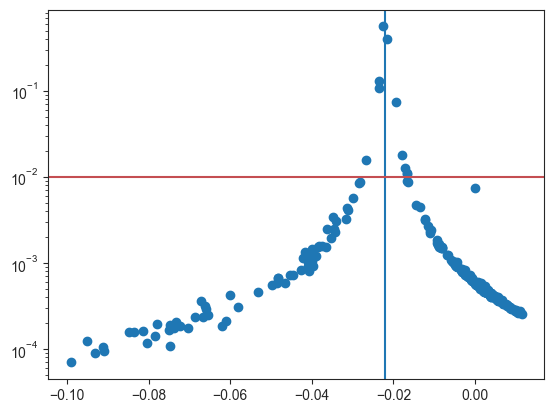

In [124]:
# for entry in range(len(interesting_muts.index)):
    
#     background_mutant

performance = 'ResPerHour'
performance = 'StaPerHour'



out = scipy.stats.ttest_ind_from_stats(interesting_muts[performance],interesting_muts[f'{performance}_error'],2,
                                     background_mutant[performance],background_mutant[f'{performance}_error'],2)
print(out.pvalue,len(out.pvalue))

plt.scatter(interesting_muts[performance],out.pvalue)
plt.axvline(background_mutant[performance].values[0])

plt.axhline(0.01,color='r')
# plt.axhline(0.05/len(out.pvalue),color='r')
plt.yscale('log')

                                     

In [107]:
scipy.stats.ttest_ind_from_stats([1,1,1],[0.001,0.1,1],2,
                                 [0],[0.1],2)

Ttest_indResult(statistic=array([14.14142857, 10.        ,  1.40719509]), pvalue=array([0.0049633 , 0.00985246, 0.29465438]))

/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

FerPerHour ResPerHour
CYR1 ([[0, 0, 46], [0, 0, 5], [4, 2, 48]], 105)
CYR1 ['Evo1D'] ([[0, 0, 1], [0, 0, 1], [0, 1, 1]], 4, array([0])) [[0 0 1]
 [0 0 1]
 [0 1 1]]
CYR1 ['Evo1D'] ([[0, 0, 1], [0, 0, 1], [0, 1, 1]], 4)
CYR1 ['Evo2D'] ([[0, 0, 29], [0, 0, 3], [4, 1, 42]], 79, array([ 0,  2,  4,  5,  7,  9, 12, 14, 16, 18, 19, 20, 24, 26, 31, 34, 35,
       37, 38, 39, 41, 42, 43, 44, 45, 47, 48, 49, 52, 55, 56, 58, 60, 61,
       62, 63, 64, 65, 66, 74, 77, 78])) [[ 0  0 29]
 [ 0  0  3]
 [ 4  1 42]]
CYR1 ['Evo2D'] ([[0, 0, 29], [0, 0, 3], [4, 1, 42]], 79)
CYR1 ['Evo3D'] ([[0, 0, 16], [0, 0, 1], [0, 0, 5]], 22, array([ 3, 11, 12, 14, 20])) [[ 0  0 16]
 [ 0  0  1]
 [ 0  0  5]]
CYR1 ['Evo3D'] ([[0, 0, 16], [0, 0, 1], [0, 0, 5]], 22)
GPB2 ([[2, 1, 43], [0, 0, 3], [2, 2, 19]], 72)
GPB2 ['Evo1D'] ([[0, 0, 2], [0, 0, 0], [0, 0, 5]], 7, array([0, 1, 2, 4, 6])) [[0 0 3]
 [0 0 1]
 [0 1 6]]
GPB2 ['Evo1D'] ([[0, 0, 2], [0, 0, 0], [0, 0, 5]], 7)
GPB2 ['Evo2D'] ([[2, 1, 29], [0, 0, 3], [2, 2, 13]], 52

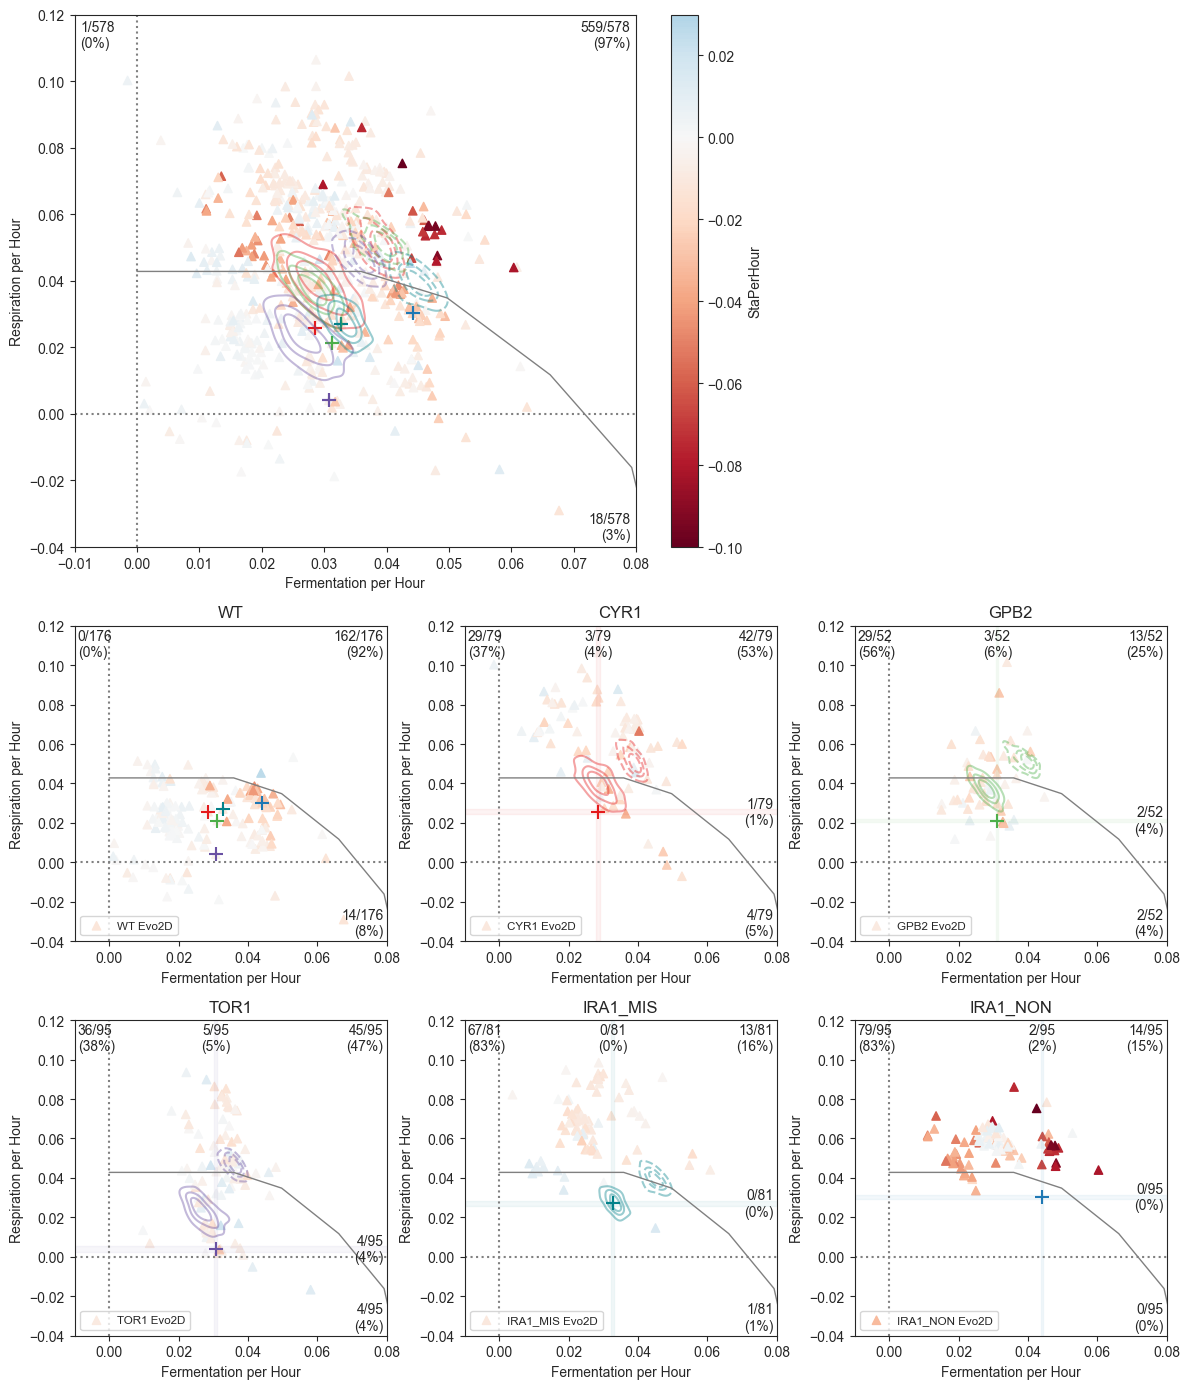

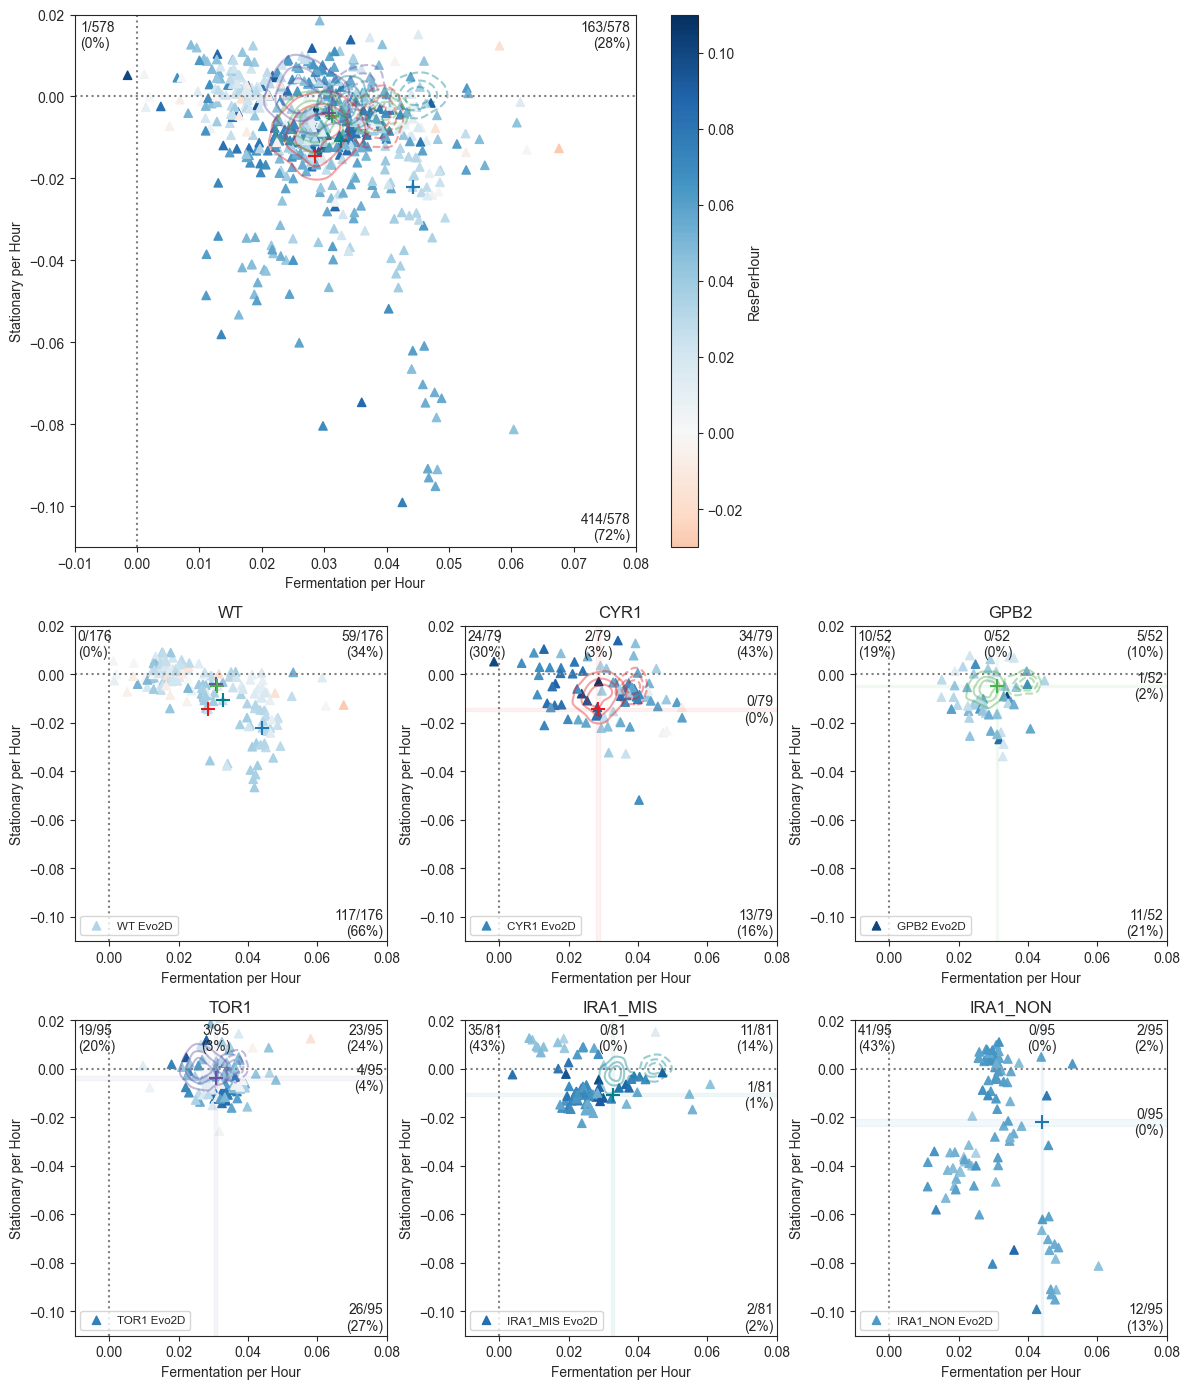

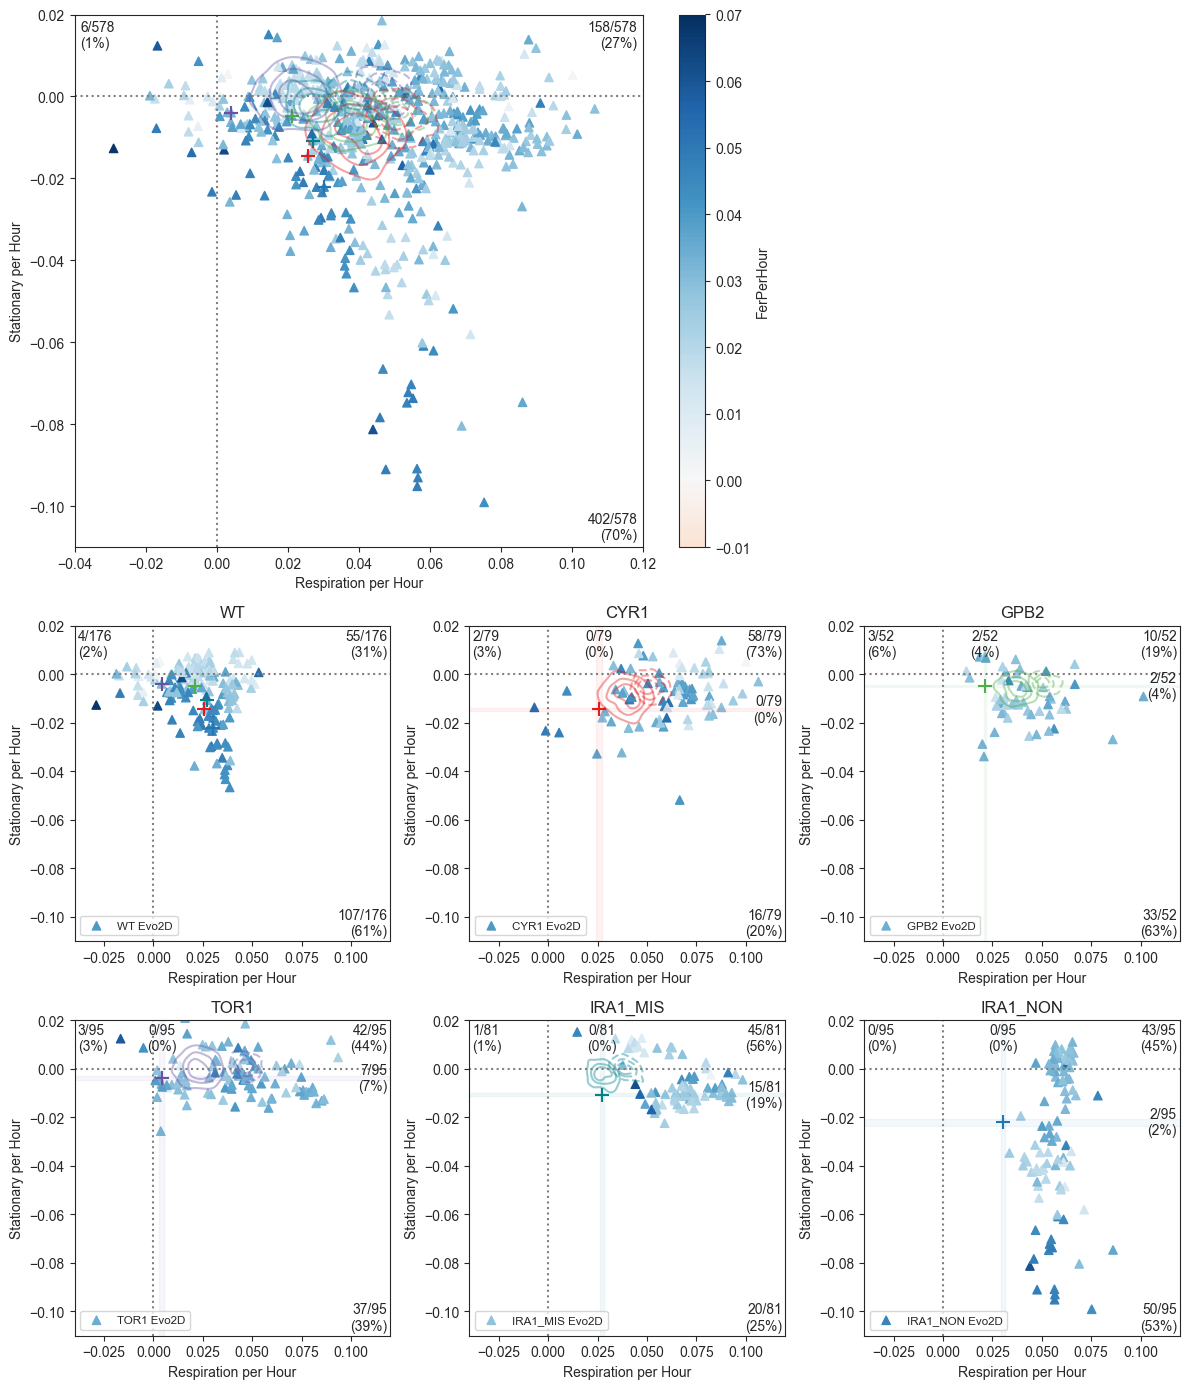

In [78]:
colors = [tools.anc_color_map[anc] for anc in merged_fitness['ancestor']]
# colors = ['b' if source=='This_study' else 'r' if source=='Li2019' else 'orange' if source == 'Aggeli2020' else 'k' for source in nonan_merged['source_publication_x']]

# non_diploid = merged_fitness[merged_fitness['ploidy']!='Diploid']

xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

xlabel = 'Stationary per Hour'
ylabel = 'Respiration per Hour'
xdata = 'StaPerHour'
ydata = 'ResPerHour'
labels = {'FerPerHour':'Fermentation per Hour','ResPerHour':'Respiration per Hour','StaPerHour':'Stationary per Hour'}
lims = {'FerPerHour':[-0.05,0.07],'ResPerHour':[-0.05,0.12],'StaPerHour':[-0.09,0.045]}

evo_cond_list = ['Evo1D']
evo_cond_list = ['Evo2D']
# evo_cond_list = ['Evo3D']
# evo_cond_list = ['Evo1D','Evo2D','Evo3D']

fitness_colorby = 'Fit2D_early_fitness'
fitness_colorby = 'Fit3D_early_fitness'
fitness_colorby = 'StaPerHour'


# cutoff for standard deviation
multiplier = 1.96

innovation_list = {}

noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']

performances = ['FerPerHour','ResPerHour','StaPerHour']

for xdata,ydata in combinations(performances,2):
# publication_list = [['This_study','Li2019','Aggeli2020','Venkataram2015'],['Venkataram2015'],['Li2019'],['Aggeli2020'],['This_study'],['Venkataram2015','This_study']] 
    ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]
    fig = plt.figure(figsize=(12,14))
    outer_gs = gridspec.GridSpec(2, 1,height_ratios=[6,8])
    
    inner_gs1 = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec = outer_gs[0],width_ratios=[6,1,1],wspace=0.25,hspace=0.25)
    inner_gs2 = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec = outer_gs[1],wspace=0.25,hspace=0.25)
    
    fitness_colorby = [perf for perf in performances if perf not in [xdata,ydata]]
    fitness_colorby = fitness_colorby[0]
    

    for a,ancs in enumerate(ancestor_list):
        
#         this_anc = non_diploid[non_diploid['ancestor'].isin(ancs)]
        
        this_anc = noLi2019[noLi2019['ancestor'].isin(ancs)]
        
        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values
        
        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
        interesting_muts = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond_list)]

        if len(ancs) > 1:
            fig.add_subplot(inner_gs1[0]) 
        else:
            fig.add_subplot(inner_gs2[a-1])
            
#         plt.gca().set_facecolor('lightgrey')
            
        for anc in ancs:
            if anc != 'WT':
                this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]

                sns.kdeplot(x=this_pure_diploid[xdata].values,y=this_pure_diploid[ydata].values,
                            color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4,linestyles='--')

                this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]

                sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
                            color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)

#         for evo_cond in np.unique(this_anc['evolution_condition'].values):
        for evo_cond in evo_cond_list:
            this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
            gray_alpha = 0.1
            bold_alpha = 0.5

            if len(ancs) > 1:
                alpha = 0.2
                normalize = matplotlib.colors.TwoSlopeNorm(vmin=-1*np.abs(merged_fitness[fitness_colorby]).max(),
                                                vcenter=0., 
                                                vmax=np.abs(merged_fitness[fitness_colorby]).max())

                sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
                            c=this_data[fitness_colorby].values,cmap='RdBu',
                            norm=normalize,
                            marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
                
#                 sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
#                             color=[tools.anc_color_map[anc] for anc in this_data['ancestor'].values],
#                             alpha=alpha,
#                             marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
               
                
            else:
                alpha = 0.3
                normalize = matplotlib.colors.TwoSlopeNorm(vmin=-1*np.abs(merged_fitness[fitness_colorby]).max(),
                                                vcenter=0., 
                                                vmax=np.abs(merged_fitness[fitness_colorby]).max())

                sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
                            c=this_data[fitness_colorby].values,cmap='RdBu',
                            norm=normalize,
                            marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
                
#                 sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
#                             color=[tools.anc_color_map[anc] for anc in this_data['ancestor'].values],
#                             alpha=alpha,
#                             marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
            
                plt.legend(loc='lower left',fontsize='small')
                plt.title(f'{ancs[0]}')
                
        for anc in ancs:
            if anc != 'WT':
                background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

                plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                            marker='+',color=tools.anc_color_map[anc],s=100)
    
                if len(ancs) < 2:

                    plt.axvspan(background_mutant[xdata].values-multiplier*background_mutant[xdata+'_error'].values,
                              background_mutant[xdata].values+multiplier*background_mutant[xdata+'_error'].values,
                              color=tools.anc_color_map[anc],alpha=0.05)

                    plt.axhspan(background_mutant[ydata].values-multiplier*(background_mutant[ydata+'_error'].values),
                              background_mutant[ydata].values+multiplier*(background_mutant[ydata+'_error'].values),
                              color=tools.anc_color_map[anc],alpha=0.05)
                    
                    tradeoffs,n_obs,indices = count_tradeoffs(interesting_muts[xdata].values,interesting_muts[ydata].values,
                             background_mutant[xdata].values,background_mutant[ydata].values,
                            background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                            multiplier=multiplier)
                    
                    va_dict = {0:'bottom',1:'center',2:'top'}
                    ha_dict = {0:'left',1:'center',2:'right'}
                    
                    offset = 0.01
                    
                    for (x,y) in [(0,2),(2,0),(1,2),(2,1),(2,2)]:
                        if x == 1:
                            loc_x = (background_mutant[xdata].values[0]-tools.lims[xdata][0])/(tools.lims[xdata][1]-tools.lims[xdata][0])
                        elif x == 0:
                            loc_x = x/2 + offset
                        else:
                            loc_x = x/2 - offset
                        
                        if y == 1:
                            loc_y = (background_mutant[ydata].values[0]-tools.lims[ydata][0])/(tools.lims[ydata][1]-tools.lims[ydata][0])
                        elif y == 0:
                            loc_y = y/2 + offset
                        else:
                            loc_y = y/2 - offset
                            
                        plt.text(s=f'{tradeoffs[x][y]}/{n_obs}\n({tradeoffs[x][y]/n_obs:.0%})',
                                     x=loc_x,y=loc_y,transform=plt.gca().transAxes,
                                     ha=ha_dict[x],va=va_dict[y])

            else:
                tradeoffs,n_obs,indices = count_tradeoffs(interesting_muts[xdata].values,interesting_muts[ydata].values,
                             0,0,0,0,
                            multiplier=multiplier)
                    
                va_dict = {0:'bottom',1:'center',2:'top'}
                ha_dict = {0:'left',1:'center',2:'right'}

                offset = 0.01

                for (x,y) in [(0,2),(2,0),(2,2)]:
                    if x == 1:
                        loc_x = (background_mutant[xdata].values[0]-tools.lims[xdata][0])/(tools.lims[xdata][1]-tools.lims[xdata][0])
                    elif x == 0:
                        loc_x = x/2 + offset
                    else:
                        loc_x = x/2 - offset

                    if y == 1:
                        loc_y = (background_mutant[ydata].values[0]-tools.lims[ydata][0])/(tools.lims[ydata][1]-tools.lims[ydata][0])
                    elif y == 0:
                        loc_y = y/2 + offset
                    else:
                        loc_y = y/2 - offset

                    plt.text(s=f'{tradeoffs[x][y]}/{n_obs}\n({tradeoffs[x][y]/n_obs:.0%})',
                                 x=loc_x,y=loc_y,transform=plt.gca().transAxes,
                                 ha=ha_dict[x],va=va_dict[y])
                
                
                for anc2 in tools.rebarcoding_source_mutants.keys():
                    background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc2]]

                    plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                            marker='+',color=tools.anc_color_map[anc2],s=100)
                    
                    
#                     tradeoffs = count_tradeoffs(this_data[xdata].values,this_data[ydata].values,
#                                      background_mutant[xdata].values,background_mutant[ydata].values)
                    
#                     print(tradeoffs)
        if xdata == 'FerPerHour' and ydata == 'ResPerHour':
            plt.plot(pareto_line[0],pareto_line[1],color='gray',lw=1)

        plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
        plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])

        plt.xlabel(labels[xdata])
        plt.ylabel(labels[ydata])

#         plt.axvline(0,color='k',linestyle=':')
#         plt.axhline(0,color='k',linestyle=':')
        
        plt.axvline(0,color='gray',linestyle=':')
        plt.axhline(0,color='gray',linestyle=':')
        
#         if len(ancs) > 1:
#             for g,gene in enumerate(tools.mutation_color_map.keys()):
#                 plt.text(y=0.5-0.02*g,x=0.02,s=f'{gene}',color=tools.mutation_color_map[gene],transform=plt.gca().transAxes)
        if len(ancs) > 1:
            cmap = plt.get_cmap('RdBu')

            vmin = np.round(np.nanmin(merged_fitness[fitness_colorby]),2)
            vmax = np.round(np.nanmax(merged_fitness[fitness_colorby]),2)

            norm2 = matplotlib.colors.Normalize(vmin=vmin, vmax =vmax)

            total_len = 2*np.abs([vmin,vmax]).max()

            if np.abs(vmin) > np.abs(vmax):
                these_colors = cmap(np.linspace(0,(vmax-vmin)/total_len, cmap.N))
            else:
                these_colors = cmap(np.linspace(1.-(vmax-vmin)/total_len, 1, cmap.N))
            # these_colors = cmap(np.linspace(0,total_len, cmap.N))

            color_map = matplotlib.colors.LinearSegmentedColormap.from_list('RdBu', these_colors)

            # create some axes to put the colorbar to
            cax, _  = matplotlib.colorbar.make_axes_gridspec(plt.gca(),location='right')
            cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=color_map, norm=norm2,)
            
            cbar.set_label(fitness_colorby)

#             cbar.set_ticks(np.round(np.linspace(vmin,vmax,7),2))
#             cbar.set_ticklabels(np.round(np.linspace(vmin,vmax,7),2))
    
    
    plt.tight_layout()
    plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_colorby{fitness_colorby}_{evo_cond_list[0]}only.pdf',bbox_inches='tight')
    plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_colorby{fitness_colorby}_{evo_cond_list[0]}only.png',bbox_inches='tight',dpi=300)


innovation_list = {}

total_tradeoffs_dict = {}

for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
    print(xdata,ydata)
    
    innovation_list[f'{xdata}_{ydata}'] = {}
    total_tradeoffs_dict[f'{xdata}_{ydata}'] = {}
    
    
    for anc in ancestor_list[0][1:]:
        
        
        
        this_anc = noLi2019[noLi2019['ancestor'].isin([anc])]

        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
        background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

        total_tradeoffs = count_tradeoffs(interesting_muts[xdata].values,interesting_muts[ydata].values,
                             background_mutant[xdata].values,background_mutant[ydata].values,
                            background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                            multiplier=multiplier)
        
        innovation_list[f'{xdata}_{ydata}'][f'{anc}'] = interesting_muts['barcode'].values[total_tradeoffs[-1]]
        
        
        
        print(anc,total_tradeoffs[:-1])
        for evo_set in [['Evo1D'],['Evo2D'],['Evo3D']]:

            this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_set)]

            tradeoffs = count_tradeoffs(this_data[xdata].values,this_data[ydata].values,
                             background_mutant[xdata].values,background_mutant[ydata].values,
                            background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                            multiplier=multiplier)
            
            if anc == 'CYR1':
                total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]] = np.asarray(tradeoffs[0])
            else:
                total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]] += np.asarray(tradeoffs[0])
            
            print(anc,evo_set,tradeoffs,total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]])
            
            
            
#             total_tradeoffs += tradeoffs 

            print(anc,evo_set,tradeoffs[:-1])

print('Improved Both')
for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
    for evo_cond in ['Evo1D','Evo2D','Evo3D']:
        print(xdata,ydata,evo_cond,'improved both:',
              f"{total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond][2][2]}/{np.sum(total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond])}",
              total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond][2][2]/np.sum(total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond])
             )
        
print('improved respiration')
resp_up = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'][:,2])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'][:,2])
all_2_3 = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'])
print(f'{resp_up}/{all_2_3}',resp_up/all_2_3)
print('improved respiration')
resp_up_fer_down = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'][0,2])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'][0,2])
all_2_3 = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'])
print(f'{resp_up_fer_down}/{all_2_3}',resp_up_fer_down/all_2_3)

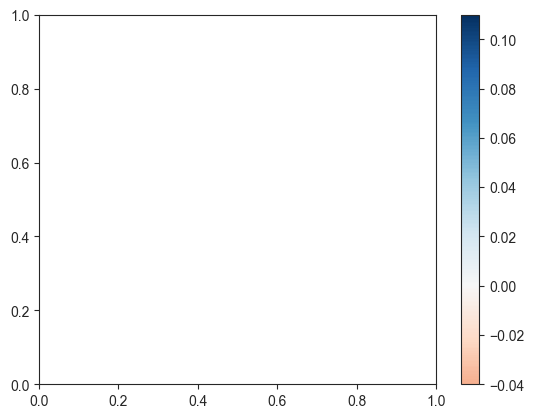

In [37]:
fitness_colorby = 'FerPerHour'
fitness_colorby = 'StaPerHour'
fitness_colorby = 'ResPerHour'

cmap = plt.get_cmap('RdBu')

vmin = np.round(np.nanmin(merged_fitness[fitness_colorby]),2)
vmax = np.round(np.nanmax(merged_fitness[fitness_colorby]),2)

norm2 = matplotlib.colors.Normalize(vmin=vmin, vmax =vmax)

total_len = 2*np.abs([vmin,vmax]).max()

if np.abs(vmin) > np.abs(vmax):
    these_colors = cmap(np.linspace(0,(vmax-vmin)/total_len, cmap.N))
else:
    these_colors = cmap(np.linspace(1.-(vmax-vmin)/total_len, 1, cmap.N))
# these_colors = cmap(np.linspace(0,total_len, cmap.N))

color_map = matplotlib.colors.LinearSegmentedColormap.from_list('RdBu', these_colors)

# create some axes to put the colorbar to
cax, _  = matplotlib.colorbar.make_axes_gridspec(plt.gca(),location='right')
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=color_map, norm=norm2,)

# cbar.set_ticks(np.round(np.linspace(vmin,vmax,7),2))
# cbar.set_ticklabels(np.round(np.linspace(vmin,vmax,7),2))

CYR1       Evo2D vs Evo3D FerPerHour KS_pval=0.000199 	 TTest_pval=9.56e-05
GPB2       Evo2D vs Evo3D FerPerHour KS_pval=0.00122 	 TTest_pval=0.00816
TOR1       Evo2D vs Evo3D FerPerHour KS_pval=0.804 	 TTest_pval=0.969
IRA1_MIS   Evo2D vs Evo3D FerPerHour KS_pval=0.0245 	 TTest_pval=0.194
IRA1_NON   Evo2D vs Evo3D FerPerHour KS_pval=6.16e-09 	 TTest_pval=0.0135
CYR1       Evo2D vs Evo3D ResPerHour KS_pval=6.15e-05 	 TTest_pval=0.000268
GPB2       Evo2D vs Evo3D ResPerHour KS_pval=1.43e-08 	 TTest_pval=1.25e-09
TOR1       Evo2D vs Evo3D ResPerHour KS_pval=0.0489 	 TTest_pval=0.0556
IRA1_MIS   Evo2D vs Evo3D ResPerHour KS_pval=0.00636 	 TTest_pval=0.0355
IRA1_NON   Evo2D vs Evo3D ResPerHour KS_pval=0.0191 	 TTest_pval=0.00168
CYR1       Evo2D vs Evo3D StaPerHour KS_pval=0.0401 	 TTest_pval=0.0166
GPB2       Evo2D vs Evo3D StaPerHour KS_pval=0.00397 	 TTest_pval=0.0174
TOR1       Evo2D vs Evo3D StaPerHour KS_pval=0.178 	 TTest_pval=0.273
IRA1_MIS   Evo2D vs Evo3D StaPerHour KS_pval=0.000

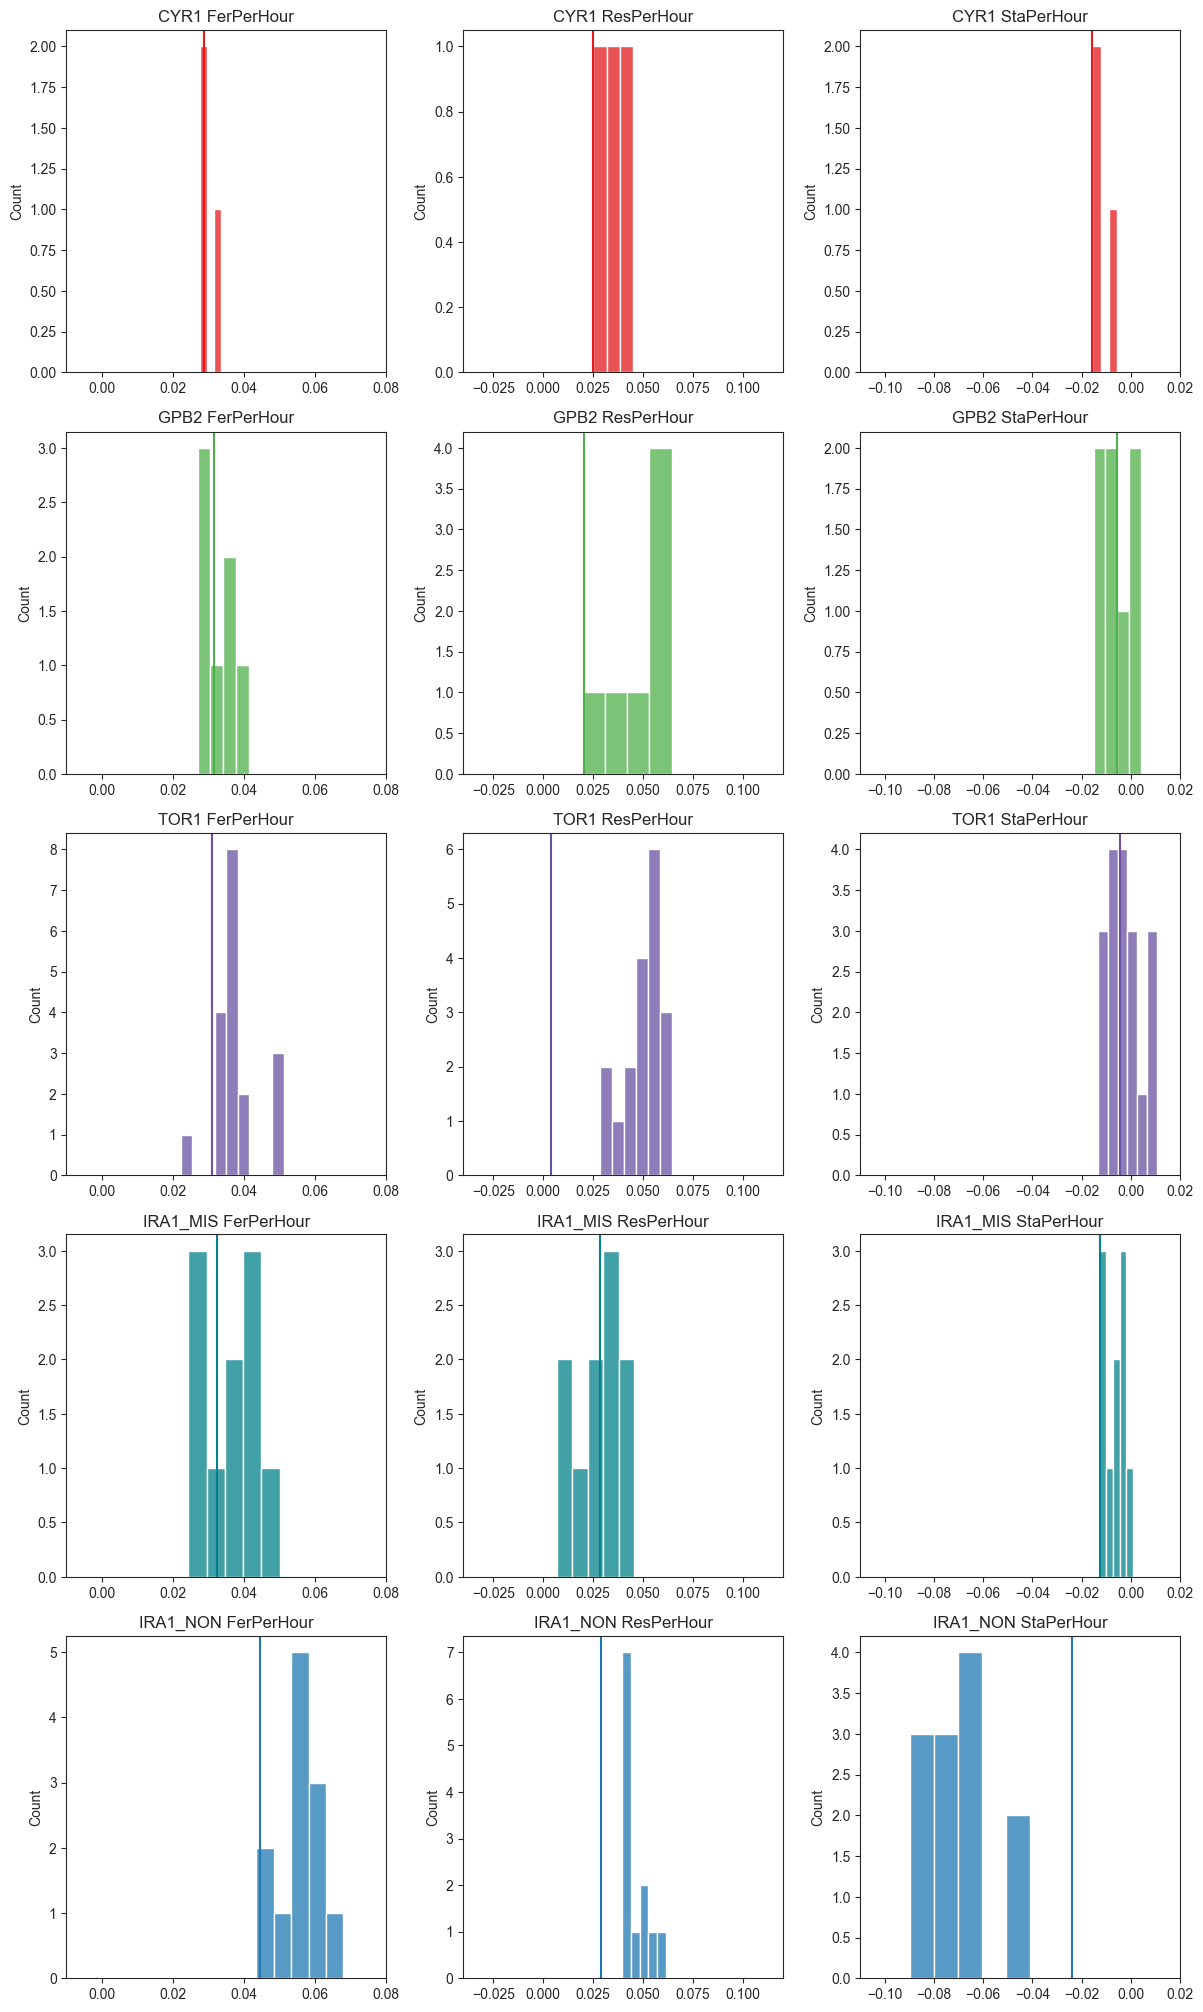

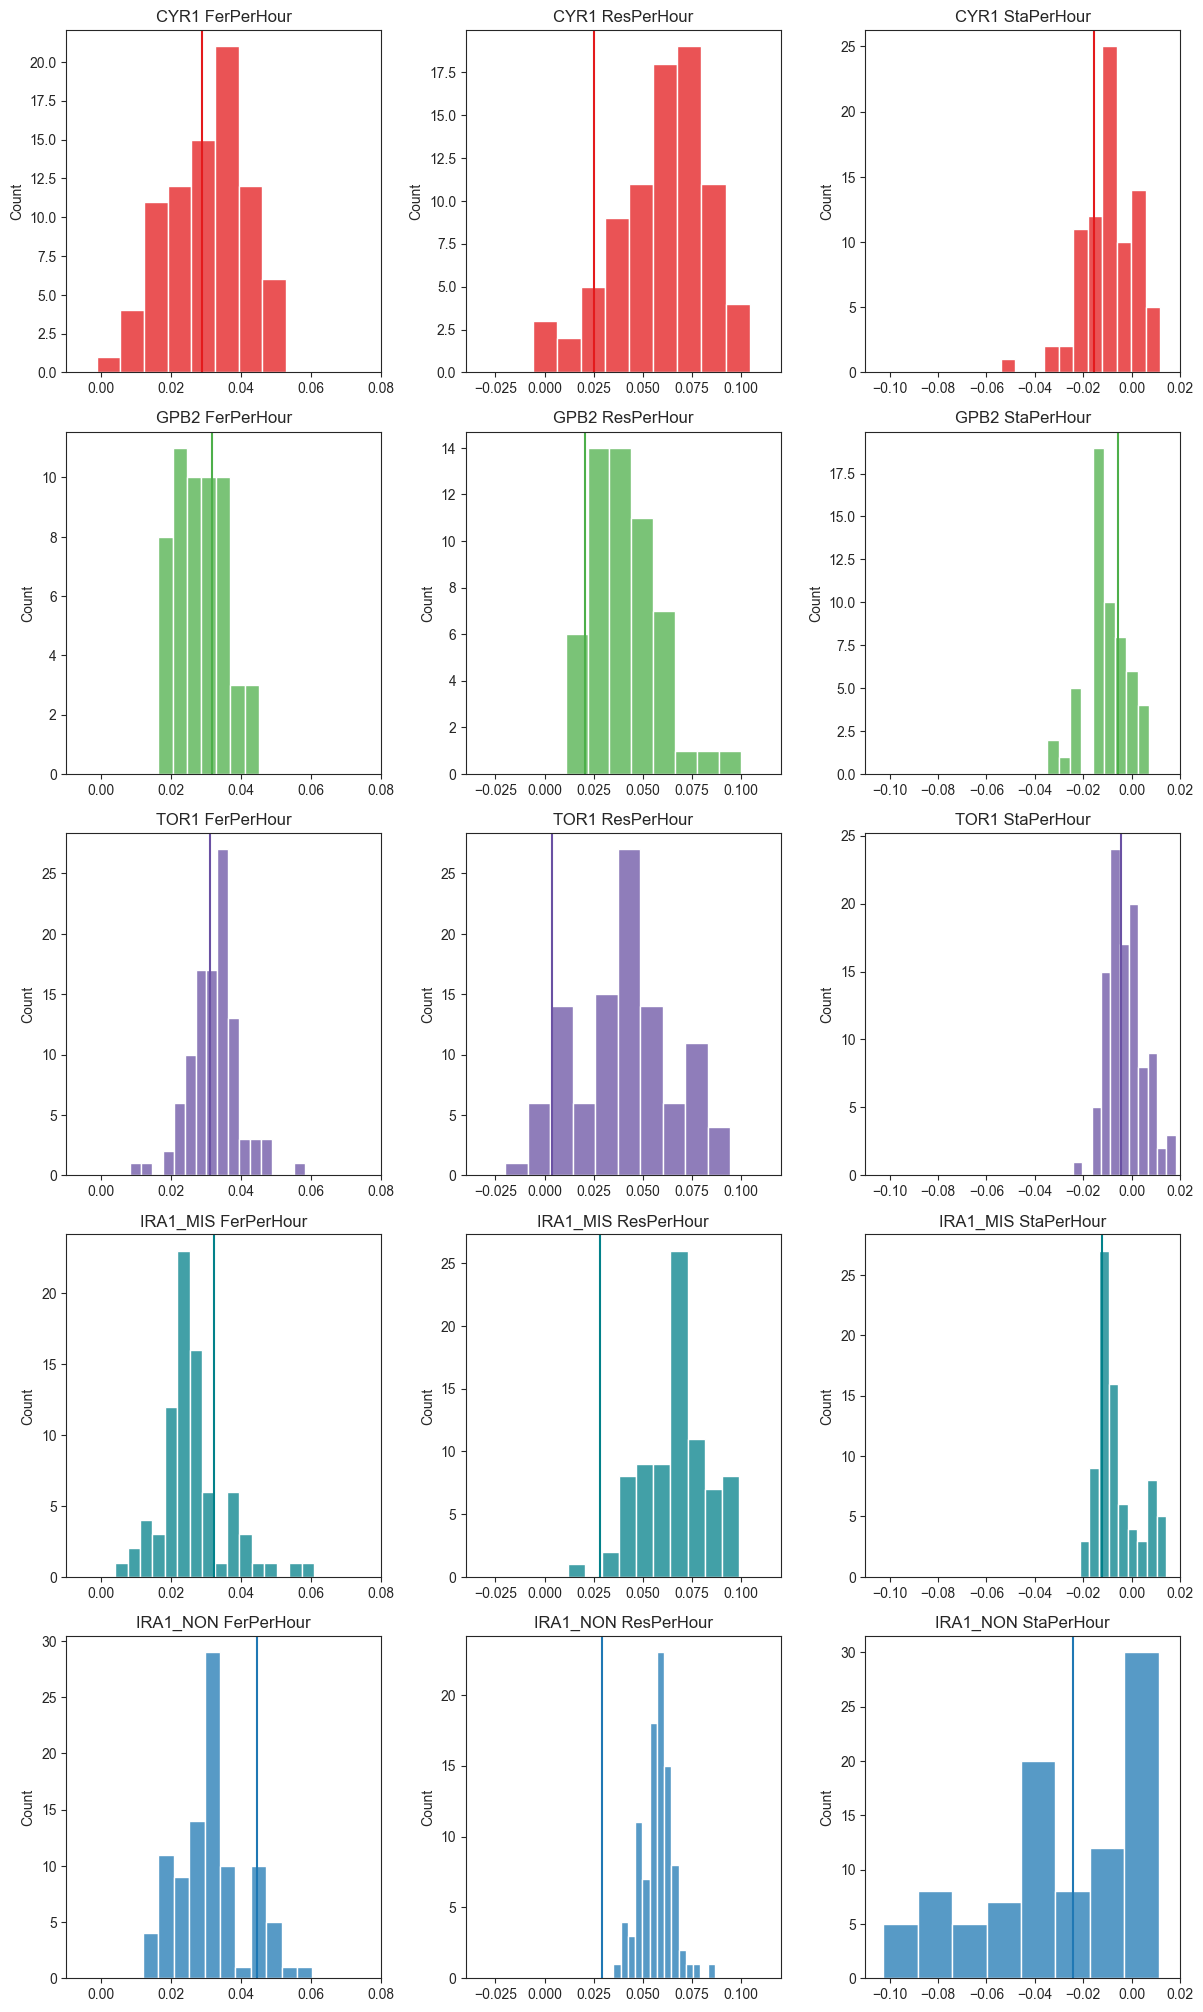

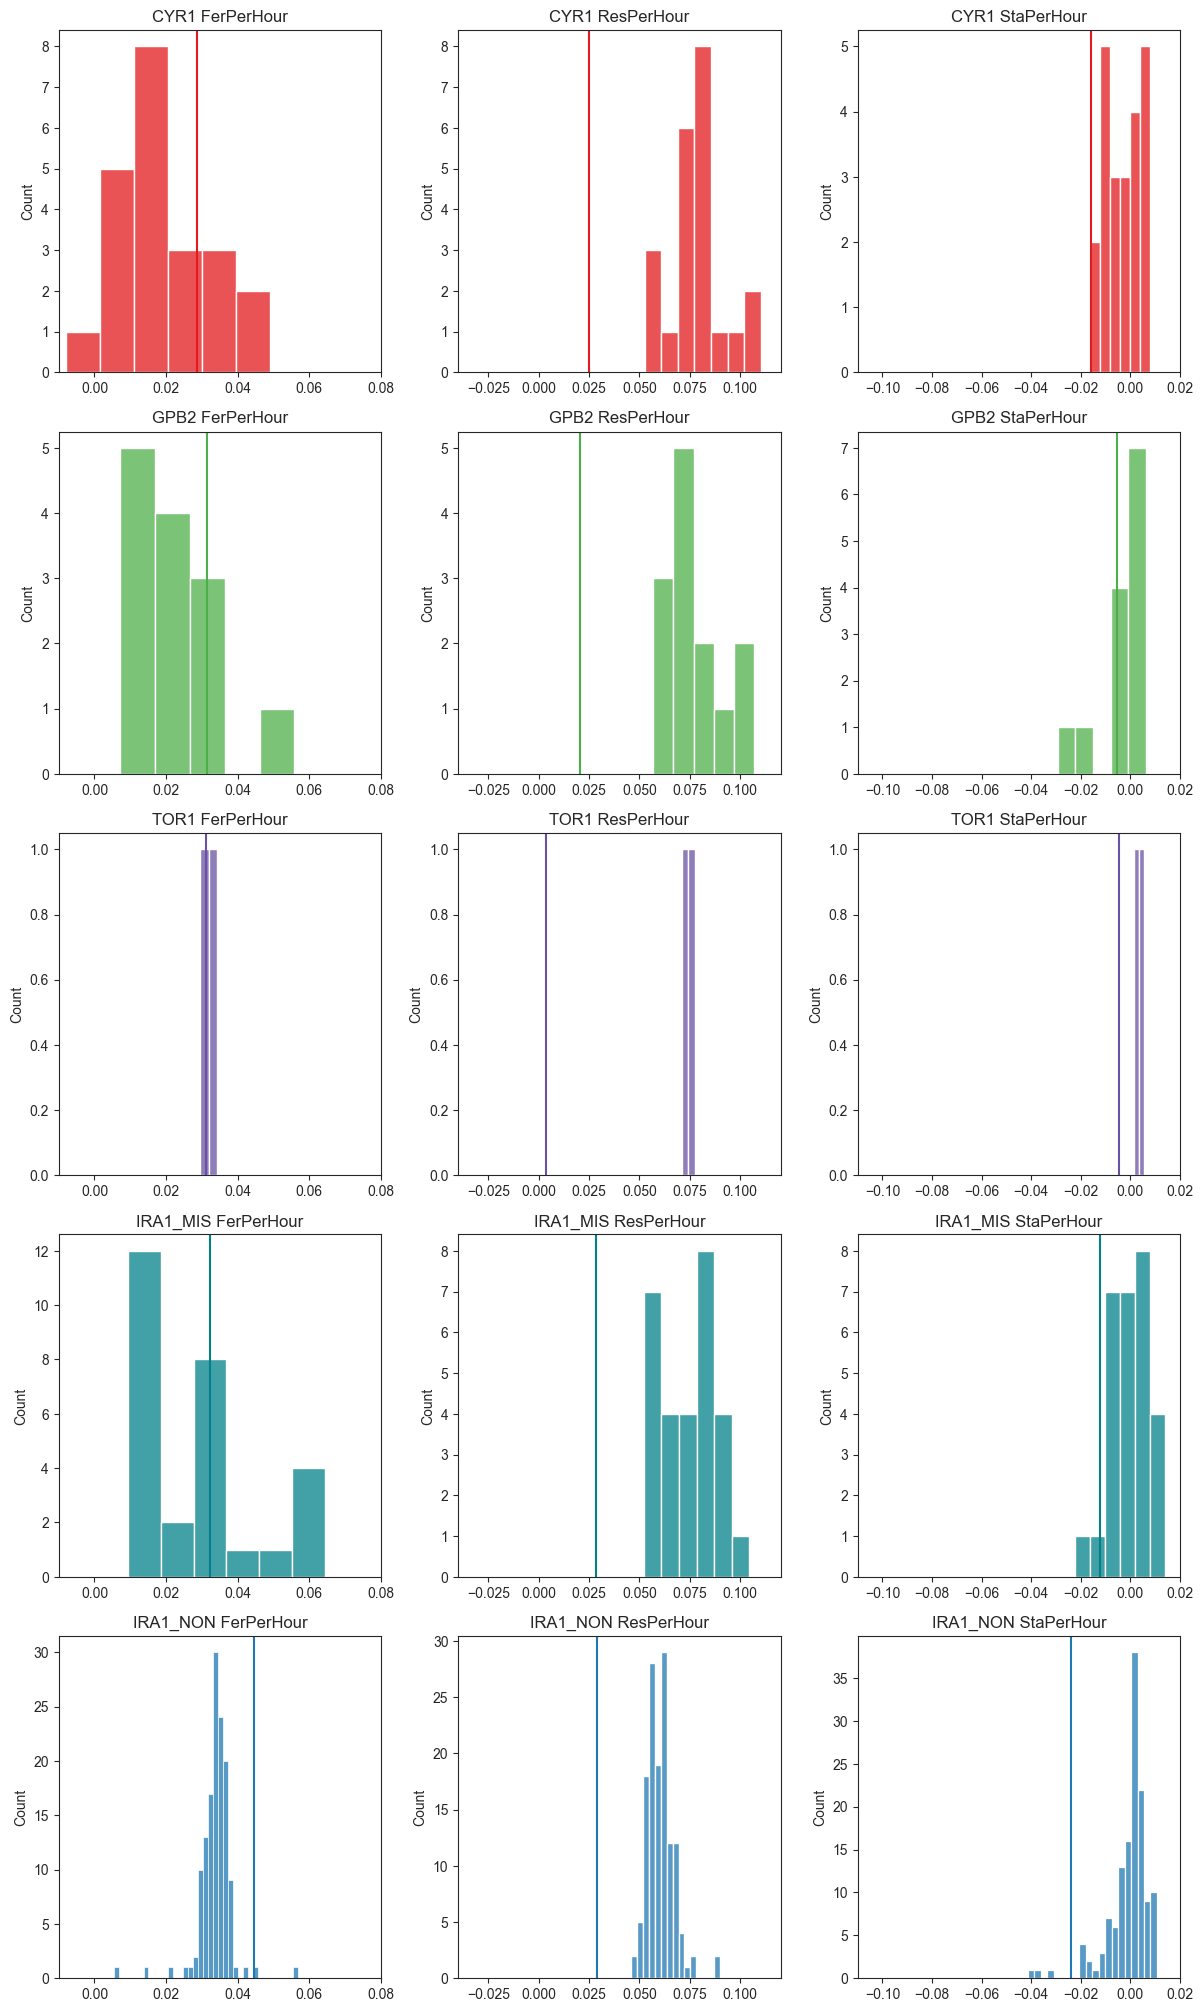

In [61]:

noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']

ancestor_list = ['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']
evo_cond_list = ['Evo1D','Evo2D','Evo3D']
performances = ['FerPerHour','ResPerHour','StaPerHour']

for evo_cond in evo_cond_list:
    fig = plt.figure(figsize=(len(performances)*4,len(ancestor_list)*4))
    counter = 1
    for a,anc in enumerate(ancestor_list):

        this_anc = noLi2019[noLi2019['ancestor'].isin([anc])]

        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]

        interesting_muts = interesting_muts[interesting_muts['evolution_condition'].isin([evo_cond])]
        
        if anc != 'WT':
            background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

        
            for data in performances:
                plt.subplot(len(ancestor_list),len(performances),counter)
                plt.title(f'{anc} {data}')
                counter += 1 

                sns.histplot(interesting_muts[data].values,color=tools.anc_color_map[anc])
                if anc != 'WT':
                    plt.axvline(background_mutant[data].values[0],color=tools.anc_color_map[anc])
                else:
                    plt.axvline(0,color=tools.anc_color_map[anc])
                plt.xlim(tools.lims[data][0],tools.lims[data][1])

    
    plt.tight_layout()
    plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/performance_hists_{evo_cond}only.pdf',bbox_inches='tight')
    plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/performance_hists_{evo_cond}only.png',dpi=300,bbox_inches='tight')
    
for data in performances: 
    for a,anc in enumerate(ancestor_list):
        this_anc = noLi2019[noLi2019['ancestor'].isin([anc])]

        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
        
        interesting_evo2d = interesting_muts[interesting_muts['evolution_condition'].isin(['Evo2D'])]
        interesting_evo3d = interesting_muts[interesting_muts['evolution_condition'].isin(['Evo3D'])]
        
        if (len(interesting_evo2d) > 0) and ((len(interesting_evo3d) > 0)):
            ks_stat = scipy.stats.kstest(interesting_evo2d[data].values,interesting_evo3d[data].values)
            
#             print(anc,'Evo2D vs Evo3D',data,f'{ks_stat.pvalue:.3g}')
            
            ttest_stat = scipy.stats.ttest_ind(interesting_evo2d[data].values,interesting_evo3d[data].values)
            
            print(f'{anc:<10s}','Evo2D vs Evo3D',data,f'KS_pval={ks_stat.pvalue:.3g}','\t',f'TTest_pval={ttest_stat.pvalue:.3g}')


/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

FerPerHour ResPerHour
CYR1 ([[0, 0, 25], [0, 15, 38], [3, 1, 10]], 92)
CYR1 ['Evo1D'] ([[0, 0, 0], [0, 2, 1], [0, 0, 0]], 3, array([], dtype=int64)) [[0 0 0]
 [0 2 1]
 [0 0 0]]
CYR1 ['Evo1D'] ([[0, 0, 0], [0, 2, 1], [0, 0, 0]], 3)
CYR1 ['Evo2D'] ([[0, 0, 13], [0, 13, 30], [3, 1, 8]], 68, array([ 0,  3,  4, 11, 31, 36, 54, 67])) [[ 0  0 13]
 [ 0 13 30]
 [ 3  1  8]]
CYR1 ['Evo2D'] ([[0, 0, 13], [0, 13, 30], [3, 1, 8]], 68)
CYR1 ['Evo3D'] ([[0, 0, 12], [0, 0, 7], [0, 0, 2]], 21, array([11, 19])) [[ 0  0 12]
 [ 0  0  7]
 [ 0  0  2]]
CYR1 ['Evo3D'] ([[0, 0, 12], [0, 0, 7], [0, 0, 2]], 21)
GPB2 ([[0, 6, 15], [0, 14, 23], [0, 1, 4]], 63)
GPB2 ['Evo1D'] ([[0, 0, 0], [0, 1, 2], [0, 0, 1]], 4, array([2])) [[0 0 0]
 [0 3 3]
 [0 0 1]]
GPB2 ['Evo1D'] ([[0, 0, 0], [0, 1, 2], [0, 0, 1]], 4)
GPB2 ['Evo2D'] ([[0, 6, 7], [0, 13, 18], [0, 1, 2]], 47, array([1, 2])) [[ 0  6 20]
 [ 0 26 48]
 [ 3  2 10]]
GPB2 ['Evo2D'] ([[0, 6, 7], [0, 13, 18], [0, 1, 2]], 47)
GPB2 ['Evo3D'] ([[0, 0, 8], [0, 0, 3], [0, 0, 1

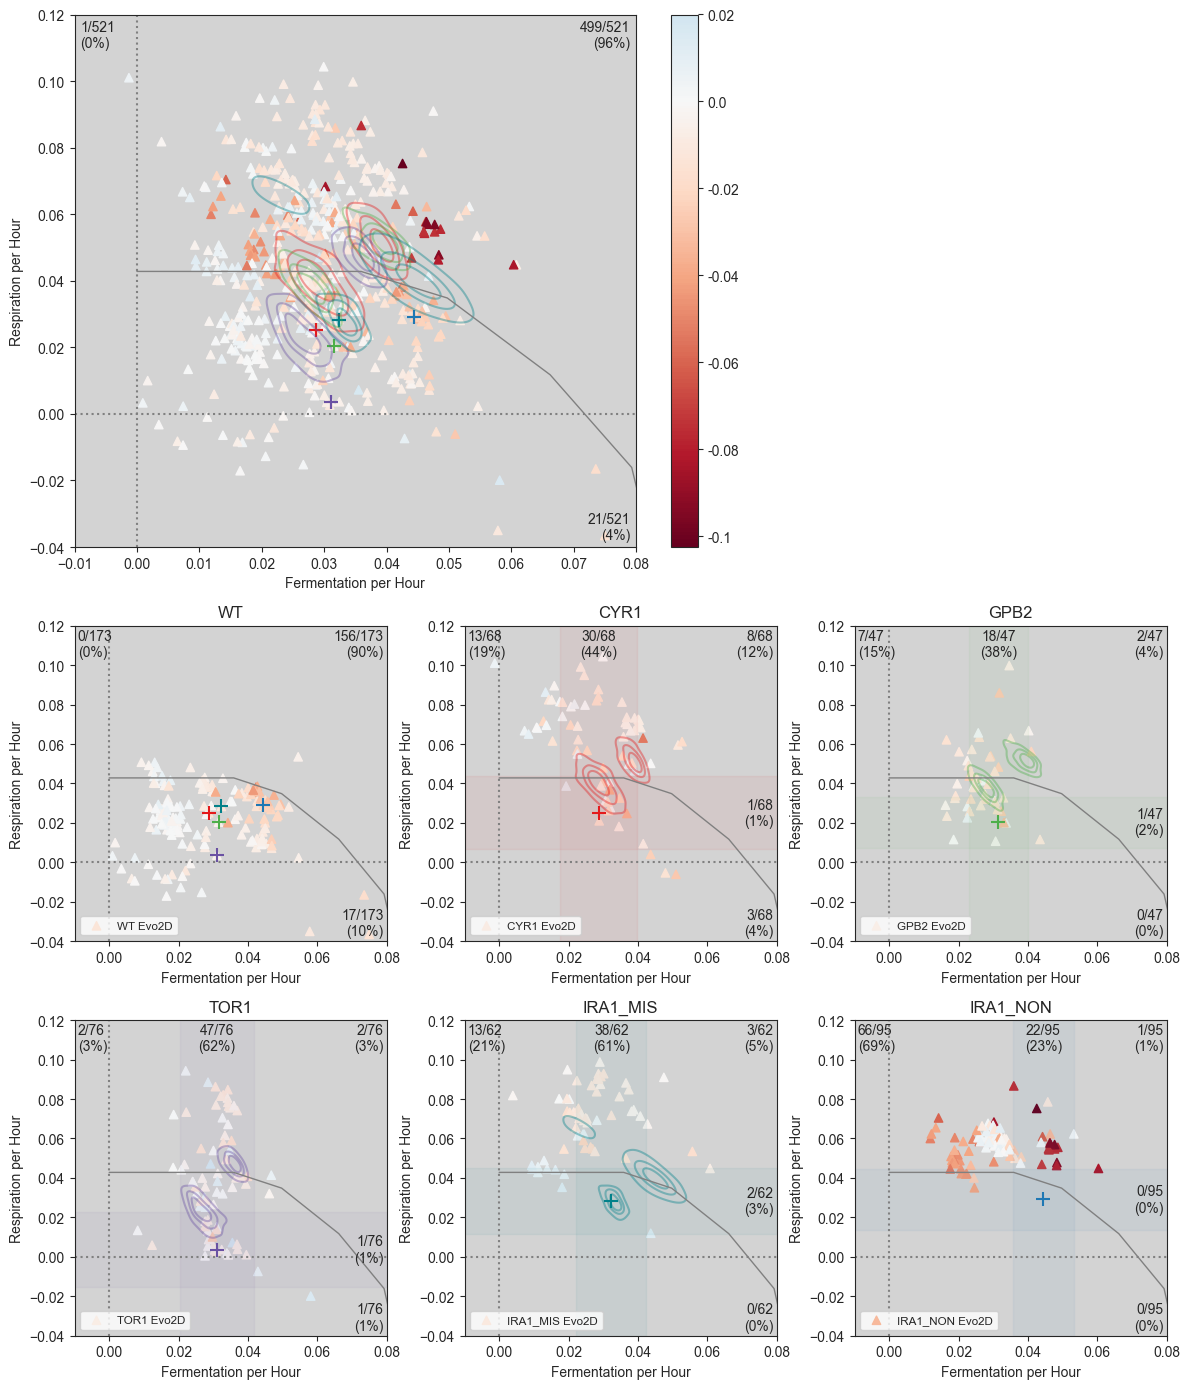

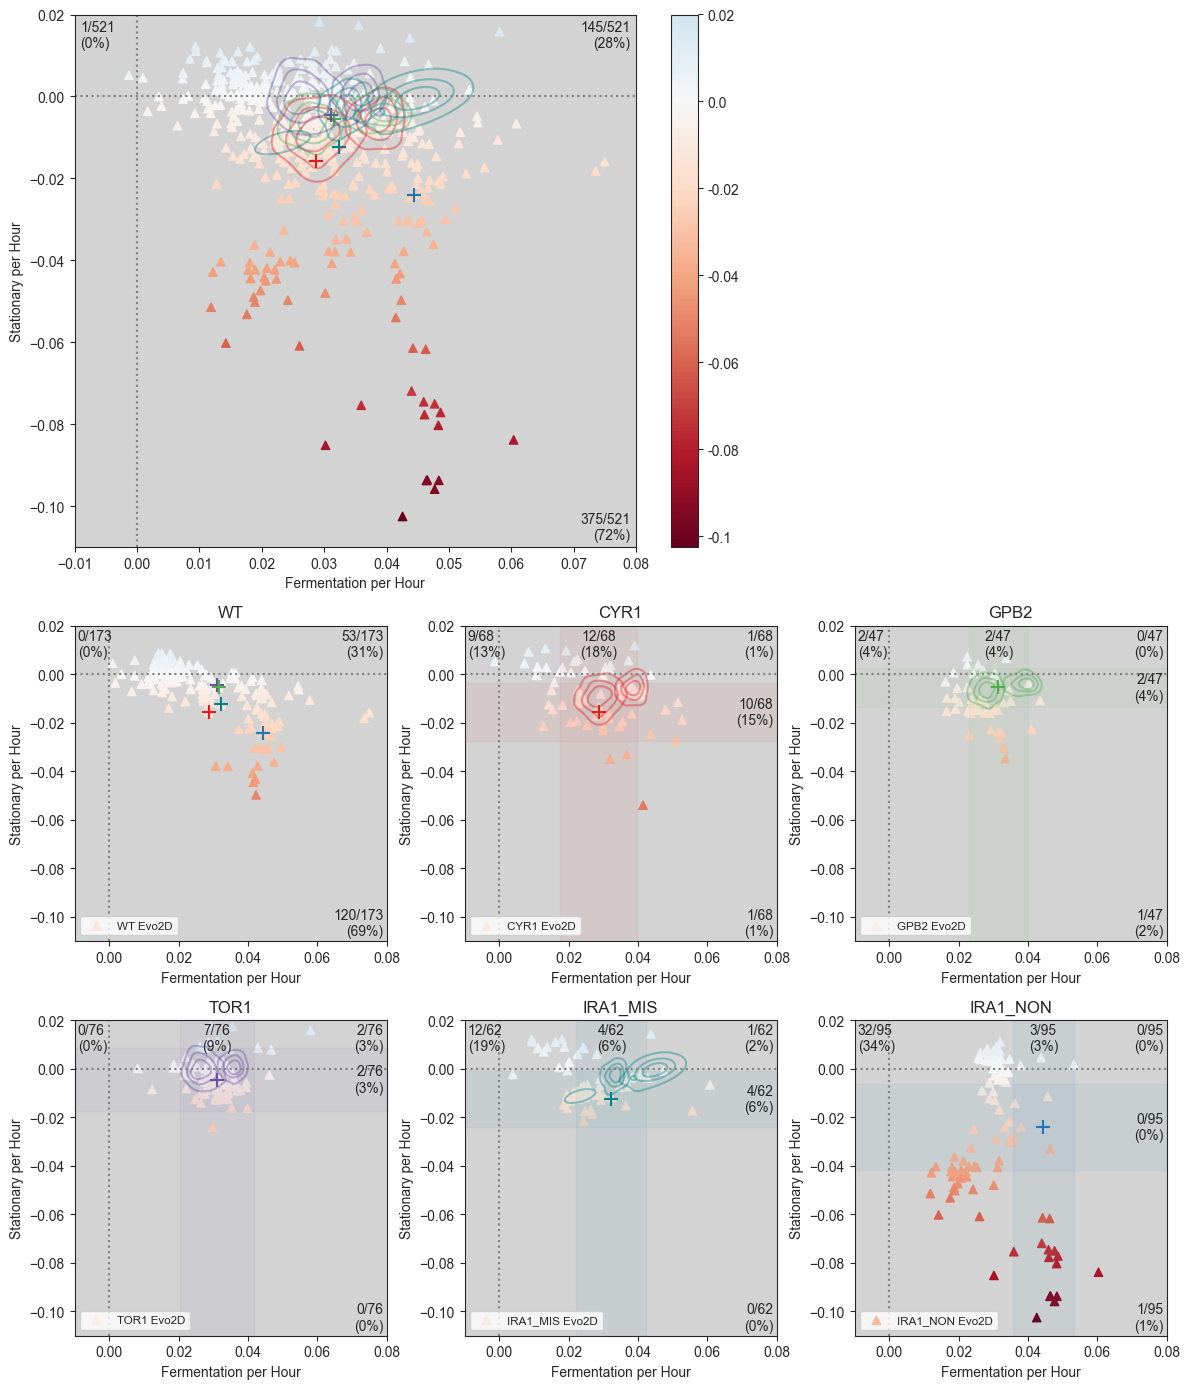

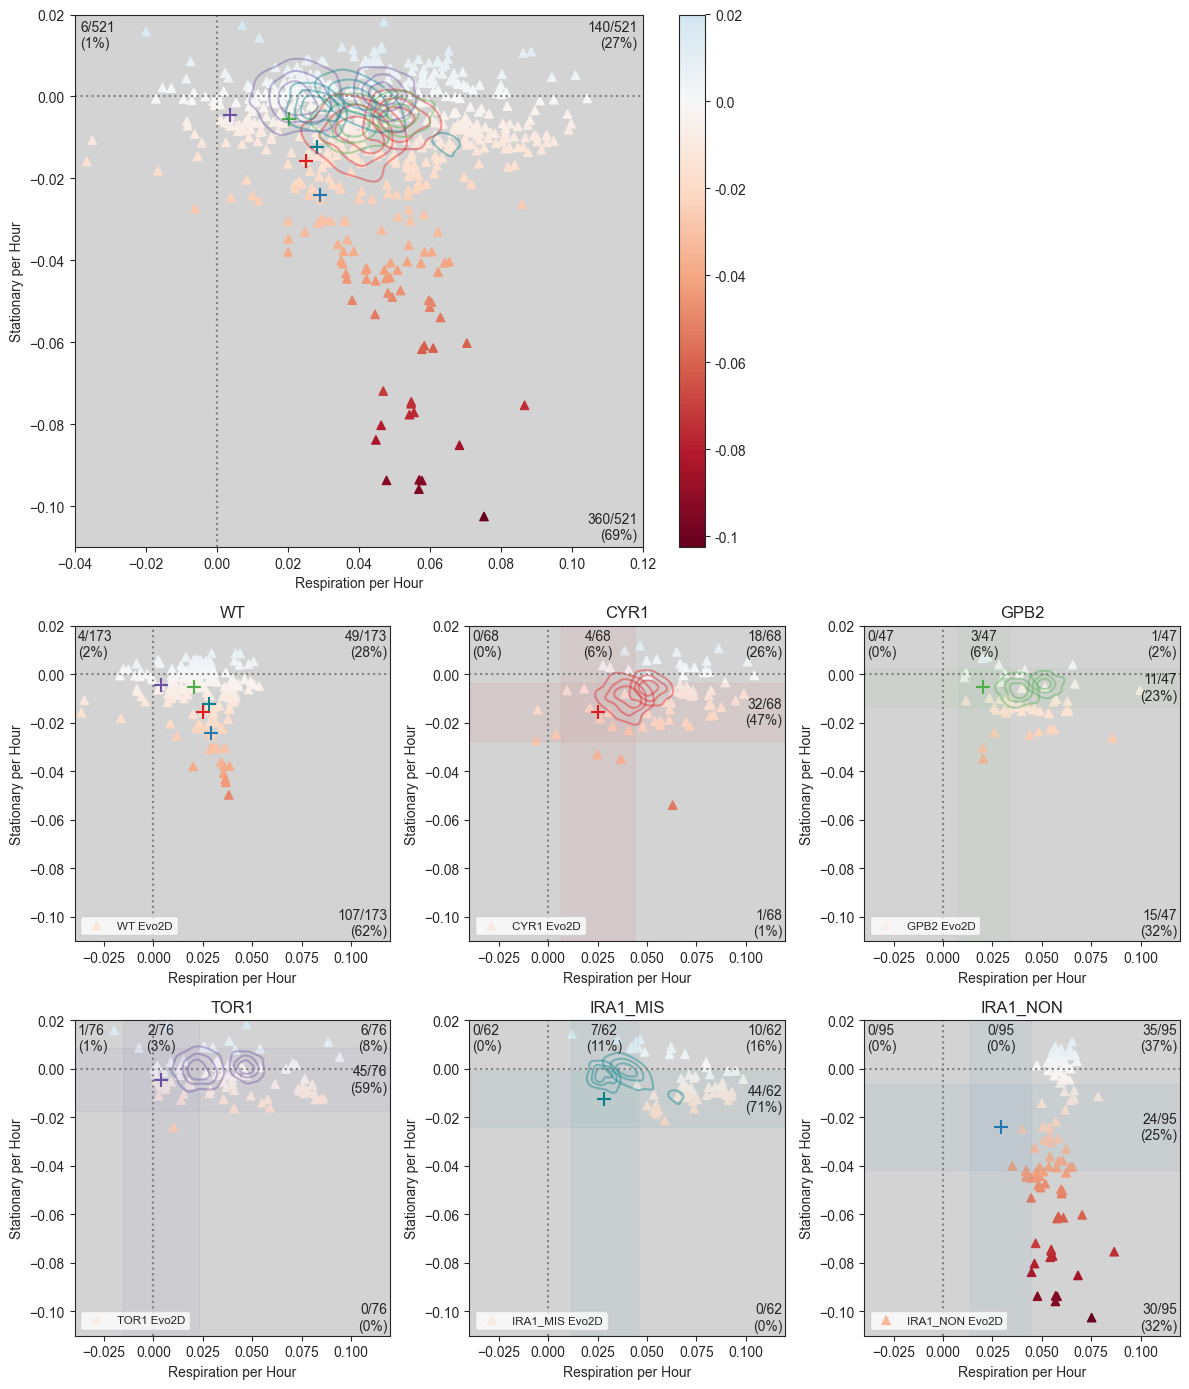

In [33]:
colors = [tools.anc_color_map[anc] for anc in merged_fitness['ancestor']]
# colors = ['b' if source=='This_study' else 'r' if source=='Li2019' else 'orange' if source == 'Aggeli2020' else 'k' for source in nonan_merged['source_publication_x']]

# non_diploid = merged_fitness[merged_fitness['ploidy']!='Diploid']

xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

xlabel = 'Stationary per Hour'
ylabel = 'Respiration per Hour'
xdata = 'StaPerHour'
ydata = 'ResPerHour'
labels = {'FerPerHour':'Fermentation per Hour','ResPerHour':'Respiration per Hour','StaPerHour':'Stationary per Hour'}
lims = {'FerPerHour':[-0.05,0.07],'ResPerHour':[-0.05,0.12],'StaPerHour':[-0.09,0.045]}

# evo_cond_list = ['Evo1D']
evo_cond_list = ['Evo2D']
# evo_cond_list = ['Evo3D']
# evo_cond_list = ['Evo1D','Evo2D','Evo3D']

fitness_colorby = 'Fit2D_early_fitness'
fitness_colorby = 'Fit3D_early_fitness'
fitness_colorby = 'StaPerHour'


# cutoff for standard deviation
multiplier = 1.0

innovation_list = {}

noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']

for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
# publication_list = [['This_study','Li2019','Aggeli2020','Venkataram2015'],['Venkataram2015'],['Li2019'],['Aggeli2020'],['This_study'],['Venkataram2015','This_study']] 
    ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]
    fig = plt.figure(figsize=(12,14))
    outer_gs = gridspec.GridSpec(2, 1,height_ratios=[6,8])
    
    inner_gs1 = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec = outer_gs[0],width_ratios=[6,1,1],wspace=0.25,hspace=0.25)
    inner_gs2 = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec = outer_gs[1],wspace=0.25,hspace=0.25)
    

    for a,ancs in enumerate(ancestor_list):
        
#         this_anc = non_diploid[non_diploid['ancestor'].isin(ancs)]
        
        this_anc = noLi2019[noLi2019['ancestor'].isin(ancs)]
        
        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values
        
        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
        interesting_muts = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond_list)]



        if len(ancs) > 1:
            fig.add_subplot(inner_gs1[0]) 
        else:
            fig.add_subplot(inner_gs2[a-1])
            
        plt.gca().set_facecolor('lightgrey')
            
        for anc in ancs:
            if anc != 'WT':
                this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]

                sns.kdeplot(x=this_pure_diploid[xdata].values,y=this_pure_diploid[ydata].values,
                            color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)

                this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]

                sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
                            color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)

#         for evo_cond in np.unique(this_anc['evolution_condition'].values):
        for evo_cond in evo_cond_list:
            this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
            gray_alpha = 0.1
            bold_alpha = 0.5

            if len(ancs) > 1:
                alpha = 0.2
                normalize = matplotlib.colors.TwoSlopeNorm(vmin=-1*np.abs(merged_fitness[fitness_colorby]).max(),
                                                vcenter=0., 
                                                vmax=np.abs(merged_fitness[fitness_colorby]).max())

                sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
                            c=this_data[fitness_colorby].values,cmap='RdBu',
                            norm=normalize,
                            marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
               
                
            else:
                alpha = 0.3
                normalize = matplotlib.colors.TwoSlopeNorm(vmin=-1*np.abs(merged_fitness[fitness_colorby]).max(),
                                                vcenter=0., 
                                                vmax=np.abs(merged_fitness[fitness_colorby]).max())

                sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
                            c=this_data[fitness_colorby].values,cmap='RdBu',
                            norm=normalize,
                            marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
            
                plt.legend(loc='lower left',fontsize='small')
                plt.title(f'{ancs[0]}')
                
        for anc in ancs:
            if anc != 'WT':
                background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

                plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                            marker='+',color=tools.anc_color_map[anc],s=100)
    
                if len(ancs) < 2:

                    plt.axvspan(background_mutant[xdata].values-multiplier*np.sqrt(background_mutant[xdata+'_error'].values),
                              background_mutant[xdata].values+multiplier*np.sqrt(background_mutant[xdata+'_error'].values),
                              color=tools.anc_color_map[anc],alpha=0.05)

                    plt.axhspan(background_mutant[ydata].values-multiplier*np.sqrt(background_mutant[ydata+'_error'].values),
                              background_mutant[ydata].values+multiplier*np.sqrt(background_mutant[ydata+'_error'].values),
                              color=tools.anc_color_map[anc],alpha=0.05)
                    
                    tradeoffs,n_obs,indices = count_tradeoffs(interesting_muts[xdata].values,interesting_muts[ydata].values,
                             background_mutant[xdata].values,background_mutant[ydata].values,
                            background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                            multiplier=multiplier)
                    
                    va_dict = {0:'bottom',1:'center',2:'top'}
                    ha_dict = {0:'left',1:'center',2:'right'}
                    
                    offset = 0.01
                    
                    for (x,y) in [(0,2),(2,0),(1,2),(2,1),(2,2)]:
                        if x == 1:
                            loc_x = (background_mutant[xdata].values[0]-tools.lims[xdata][0])/(tools.lims[xdata][1]-tools.lims[xdata][0])
                        elif x == 0:
                            loc_x = x/2 + offset
                        else:
                            loc_x = x/2 - offset
                        
                        if y == 1:
                            loc_y = (background_mutant[ydata].values[0]-tools.lims[ydata][0])/(tools.lims[ydata][1]-tools.lims[ydata][0])
                        elif y == 0:
                            loc_y = y/2 + offset
                        else:
                            loc_y = y/2 - offset
                            
                        plt.text(s=f'{tradeoffs[x][y]}/{n_obs}\n({tradeoffs[x][y]/n_obs:.0%})',
                                     x=loc_x,y=loc_y,transform=plt.gca().transAxes,
                                     ha=ha_dict[x],va=va_dict[y])

            else:
                tradeoffs,n_obs,indices = count_tradeoffs(interesting_muts[xdata].values,interesting_muts[ydata].values,
                             0,0,0,0,
                            multiplier=multiplier)
                    
                va_dict = {0:'bottom',1:'center',2:'top'}
                ha_dict = {0:'left',1:'center',2:'right'}

                offset = 0.01

                for (x,y) in [(0,2),(2,0),(2,2)]:
                    if x == 1:
                        loc_x = (background_mutant[xdata].values[0]-tools.lims[xdata][0])/(tools.lims[xdata][1]-tools.lims[xdata][0])
                    elif x == 0:
                        loc_x = x/2 + offset
                    else:
                        loc_x = x/2 - offset

                    if y == 1:
                        loc_y = (background_mutant[ydata].values[0]-tools.lims[ydata][0])/(tools.lims[ydata][1]-tools.lims[ydata][0])
                    elif y == 0:
                        loc_y = y/2 + offset
                    else:
                        loc_y = y/2 - offset

                    plt.text(s=f'{tradeoffs[x][y]}/{n_obs}\n({tradeoffs[x][y]/n_obs:.0%})',
                                 x=loc_x,y=loc_y,transform=plt.gca().transAxes,
                                 ha=ha_dict[x],va=va_dict[y])
                
                
                for anc2 in tools.rebarcoding_source_mutants.keys():
                    background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc2]]

                    plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                            marker='+',color=tools.anc_color_map[anc2],s=100)
                    
                    
#                     tradeoffs = count_tradeoffs(this_data[xdata].values,this_data[ydata].values,
#                                      background_mutant[xdata].values,background_mutant[ydata].values)
                    
#                     print(tradeoffs)
        if xdata == 'FerPerHour' and ydata == 'ResPerHour':
            plt.plot(pareto_line[0],pareto_line[1],color='gray',lw=1)

        plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
        plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])

        plt.xlabel(labels[xdata])
        plt.ylabel(labels[ydata])

#         plt.axvline(0,color='k',linestyle=':')
#         plt.axhline(0,color='k',linestyle=':')
        
        plt.axvline(0,color='gray',linestyle=':')
        plt.axhline(0,color='gray',linestyle=':')
        
#         if len(ancs) > 1:
#             for g,gene in enumerate(tools.mutation_color_map.keys()):
#                 plt.text(y=0.5-0.02*g,x=0.02,s=f'{gene}',color=tools.mutation_color_map[gene],transform=plt.gca().transAxes)
        if len(ancs) > 1:
            cmap = plt.get_cmap('RdBu')

            vmin = np.nanmin(merged_fitness[fitness_colorby])
            vmax = np.round(np.nanmax(merged_fitness[fitness_colorby]),2)

            norm2 = matplotlib.colors.Normalize(vmin=vmin, vmax =vmax)

            total_len = 2*np.abs(merged_fitness[fitness_colorby]).max()

        #     these_colors = cmap(np.linspace(1.-(vmax-vmin)/float(vmax), 1, cmap.N))
            these_colors = cmap(np.linspace(0,(vmax-vmin)/total_len, cmap.N))

            color_map = matplotlib.colors.LinearSegmentedColormap.from_list('RdBu', these_colors)

            # create some axes to put the colorbar to
            cax, _  = matplotlib.colorbar.make_axes_gridspec(plt.gca(),location='right')
            cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=color_map, norm=norm2,)

            cbar.set_ticks(np.round(np.linspace(-0.1,0.02,7),2))
            cbar.set_ticklabels(np.round(np.linspace(-0.1,0.02,7),2))
    
    
    plt.tight_layout()
    plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_improvement_{fitness_colorby}colors_Evo2Donly.pdf',bbox_inches='tight')
    plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_improvement_{fitness_colorby}colors_Evo2Donly.png',bbox_inches='tight',dpi=300)


innovation_list = {}

total_tradeoffs_dict = {}

for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
    print(xdata,ydata)
    
    innovation_list[f'{xdata}_{ydata}'] = {}
    total_tradeoffs_dict[f'{xdata}_{ydata}'] = {}
    
    
    for anc in ancestor_list[0][1:]:
        
        
        
        this_anc = noLi2019[noLi2019['ancestor'].isin([anc])]

        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
        background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

        total_tradeoffs = count_tradeoffs(interesting_muts[xdata].values,interesting_muts[ydata].values,
                             background_mutant[xdata].values,background_mutant[ydata].values,
                            background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                            multiplier=multiplier)
        
        innovation_list[f'{xdata}_{ydata}'][f'{anc}'] = interesting_muts['barcode'].values[total_tradeoffs[-1]]
        
        
        
        print(anc,total_tradeoffs[:-1])
        for evo_set in [['Evo1D'],['Evo2D'],['Evo3D']]:

            this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_set)]

            tradeoffs = count_tradeoffs(this_data[xdata].values,this_data[ydata].values,
                             background_mutant[xdata].values,background_mutant[ydata].values,
                            background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                            multiplier=multiplier)
            
            if anc == 'CYR1':
                total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]] = np.asarray(tradeoffs[0])
            else:
                total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]] += np.asarray(tradeoffs[0])
            
            print(anc,evo_set,tradeoffs,total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]])
            
            
            
#             total_tradeoffs += tradeoffs 

            print(anc,evo_set,tradeoffs[:-1])

print('Improved Both')
for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
    for evo_cond in ['Evo1D','Evo2D','Evo3D']:
        print(xdata,ydata,evo_cond,'improved both:',
              f"{total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond][2][2]}/{np.sum(total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond])}",
              total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond][2][2]/np.sum(total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond])
             )
        
print('improved respiration')
resp_up = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'][:,2])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'][:,2])
all_2_3 = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'])
print(f'{resp_up}/{all_2_3}',resp_up/all_2_3)
print('improved respiration')
resp_up_fer_down = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'][0,2])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'][0,2])
all_2_3 = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'])
print(f'{resp_up_fer_down}/{all_2_3}',resp_up_fer_down/all_2_3)

In [45]:
np.sqrt(background_mutant['FerPerHour_error'])

4315    0.008813
Name: FerPerHour_error, dtype: float64

In [46]:
np.sqrt(background_mutant['ResPerHour_error'])

4315    0.015597
Name: ResPerHour_error, dtype: float64

In [33]:

for multiplier in [0,1]:
    print(f'Multiplier = {multiplier}')
    total_tradeoffs_dict = {}

    for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
        print(xdata,ydata)

        innovation_list[f'{xdata}_{ydata}'] = {}
        total_tradeoffs_dict[f'{xdata}_{ydata}'] = {}


        for anc in ancestor_list[0][1:]:



            this_anc = noLi2019[noLi2019['ancestor'].isin([anc])]

            these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
            these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

            interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
            background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

            total_tradeoffs = count_tradeoffs(interesting_muts[xdata].values,interesting_muts[ydata].values,
                                 background_mutant[xdata].values,background_mutant[ydata].values,
                                background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                                multiplier=multiplier)

            innovation_list[f'{xdata}_{ydata}'][f'{anc}'] = interesting_muts['barcode'].values[total_tradeoffs[-1]]



            print(anc,total_tradeoffs[:-1])
            for evo_set in [['Evo1D'],['Evo2D'],['Evo3D']]:

                this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_set)]

                tradeoffs = count_tradeoffs(this_data[xdata].values,this_data[ydata].values,
                                 background_mutant[xdata].values,background_mutant[ydata].values,
                                background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                                multiplier=multiplier)

                if anc == 'CYR1':
                    total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]] = np.asarray(tradeoffs[0])
                else:
                    total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]] += np.asarray(tradeoffs[0])

#                 print(anc,evo_set,tradeoffs,total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]])



    #             total_tradeoffs += tradeoffs 

                print(anc,evo_set,tradeoffs[:-1])

    print('Improved Both')
    for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
        for evo_cond in ['Evo1D','Evo2D','Evo3D']:
            print(xdata,ydata,evo_cond,'improved both:',
                  f"{total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond][2][2]}/{np.sum(total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond])}",
                  total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond][2][2]/np.sum(total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond])
                 )

    print('improved respiration')
    resp_up = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'][:,2])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'][:,2])
    all_2_3 = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'])
    print(f'{resp_up}/{all_2_3}',resp_up/all_2_3)
    print('improved respiration at cost of fermentation')
    resp_up_fer_down = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'][0,2])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'][0,2])
    all_2_3 = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'])
    print(f'{resp_up_fer_down}/{all_2_3}',resp_up_fer_down/all_2_3)


Multiplier = 0
FerPerHour ResPerHour
CYR1 ([[0, 0, 61], [0, 0, 0], [14, 0, 73]], 148)
CYR1 ['Evo1D'] ([[0, 0, 3], [0, 0, 0], [1, 0, 9]], 13)
CYR1 ['Evo2D'] ([[0, 0, 41], [0, 0, 0], [13, 0, 58]], 112)
CYR1 ['Evo3D'] ([[0, 0, 17], [0, 0, 0], [0, 0, 6]], 23)
GPB2 ([[3, 0, 101], [0, 0, 0], [6, 0, 25]], 135)
GPB2 ['Evo1D'] ([[1, 0, 8], [0, 0, 0], [0, 0, 6]], 15)
GPB2 ['Evo2D'] ([[2, 0, 80], [0, 0, 0], [6, 0, 18]], 106)
GPB2 ['Evo3D'] ([[0, 0, 13], [0, 0, 0], [0, 0, 1]], 14)
TOR1 ([[3, 0, 84], [0, 0, 0], [7, 0, 73]], 167)
TOR1 ['Evo1D'] ([[0, 0, 4], [0, 0, 0], [0, 0, 17]], 21)
TOR1 ['Evo2D'] ([[3, 0, 79], [0, 0, 0], [7, 0, 55]], 144)
TOR1 ['Evo3D'] ([[0, 0, 1], [0, 0, 0], [0, 0, 1]], 2)
IRA1_MIS ([[4, 0, 82], [0, 0, 0], [3, 0, 34]], 123)
IRA1_MIS ['Evo1D'] ([[4, 0, 1], [0, 0, 0], [2, 0, 5]], 12)
IRA1_MIS ['Evo2D'] ([[0, 0, 66], [0, 0, 0], [1, 0, 15]], 82)
IRA1_MIS ['Evo3D'] ([[0, 0, 15], [0, 0, 0], [0, 0, 14]], 29)
IRA1_NON ([[0, 0, 214], [0, 0, 0], [0, 0, 27]], 241)
IRA1_NON ['Evo1D'] ([[0,

In [40]:
innovation_list

{'FerPerHour_ResPerHour': {'CYR1': array(['AGAACAAAAACTAAACTCATTCATGG_AGTTAAATTGGGAAGGGTATTTTGAG',
         'GACAGAAAAGCCAAATGGATTTACCG_GAAGAAACAGCGAACAGGCTTTTTTA',
         'AGAACAAAAACTAAACTCATTCATGG_CGGAGAAGTGGCAAGAAGATTGTGAC',
         'GACAGAAAAGCCAAATGGATTTACCG_CGCGAAAATAGCTACACTGTTTCACG',
         'GACAGAAAAGCCAAATGGATTTACCG_CCCACAAACCGGAATTGTATTAACTA',
         'AGAACAAAAACTAAACTCATTCATGG_TTCTGAAAAAGTAATCAAATTACTCA',
         'ACTTAAAAAGCAAACATGATTATTCA_AAATCAAGAGCAAAAAACCTTTTAAA',
         'GACAGAAAAGCCAAATGGATTTACCG_CCGGAAACTGGAAACAATTTTGCAAT',
         'AGAACAAAAACTAAACTCATTCATGG_AGCTTAATCTAGAAGCGTTTTTGCAA',
         'AGAACAAAAACTAAACTCATTCATGG_TGAGTAAACAGAAAGAAGTTTCCAGC',
         'CTAGAAATCTCAAAAACTTTTGGCTG_AAAAGAACTAAAAAGGGTCTTCGGGG',
         'AGAACAAAAACTAAACTCATTCATGG_TCTCGAATAGATAATAATTTTATATA',
         'ACTTAAAAAGCAAACATGATTATTCA_ATAAAAAGAGAAAATTATATTAATTA',
         'AGAACAAAAACTAAACTCATTCATGG_CCGCCTAAACCTATTTATGTG'], dtype=object),
  'GPB2': array(['CCGCCAATCCCGAA

In [36]:
non_Li2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']

this_anc = non_Li2019[(non_Li2019['ancestor']!='WT')]
these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
res = stats.pearsonr(interesting_muts['FerPerHour'],interesting_muts['ResPerHour'])

print(f'ALL 2nd step (excluding pure diploids): r={res.statistic:.2f} \u00B1 {np.abs(res.statistic-res.confidence_interval()[0]):.2f}, p={res.pvalue:.2g}, ({res.confidence_interval()[0]:.2f},{res.confidence_interval()[1]:.2f}) ')

for anc in ['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']:
    this_anc = non_Li2019[non_Li2019['ancestor']==anc]
    these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
    these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

    interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
    res = stats.pearsonr(interesting_muts['FerPerHour'],interesting_muts['ResPerHour'])
    print(f'{anc}: r={res.statistic:.2f} \u00B1 {np.abs(res.statistic-res.confidence_interval()[0]):.2f}, p={res.pvalue:.2g}, ({res.confidence_interval()[0]:.2f},{res.confidence_interval()[1]:.2f})')
    
    
    
### JUST 2 Day
print('JUST 2 DAY')

non_Li2019 = merged_fitness[(merged_fitness['source_publication']!='Li2019') & (merged_fitness['evolution_condition']=='Evo2D')]

this_anc = non_Li2019[(non_Li2019['ancestor']!='WT')]
these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values


interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
res = stats.pearsonr(interesting_muts['FerPerHour'],interesting_muts['ResPerHour'])

print(f'ALL 2nd step (excluding pure diploids): r={res.statistic:.2f} \u00B1 {np.abs(res.statistic-res.confidence_interval()[0]):.2f}, p={res.pvalue:.2g}, ({res.confidence_interval()[0]:.2f},{res.confidence_interval()[1]:.2f}) ')

for anc in ['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']:
    this_anc = non_Li2019[non_Li2019['ancestor']==anc]
    these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
    these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

    interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
    res = stats.pearsonr(interesting_muts['FerPerHour'],interesting_muts['ResPerHour'])
    print(f'{anc}: r={res.statistic:.2f} \u00B1 {np.abs(res.statistic-res.confidence_interval()[0]):.2f}, p={res.pvalue:.2g}, ({res.confidence_interval()[0]:.2f},{res.confidence_interval()[1]:.2f})')
    


ALL 2nd step (excluding pure diploids): r=-0.18 ± 0.07, p=1.4e-07, (-0.25,-0.12) 
WT: r=-0.06 ± 0.15, p=0.44, (-0.21,0.09)
CYR1: r=-0.51 ± 0.11, p=3.3e-11, (-0.62,-0.38)
GPB2: r=-0.27 ± 0.15, p=0.0014, (-0.42,-0.11)
TOR1: r=0.07 ± 0.15, p=0.36, (-0.08,0.22)
IRA1_MIS: r=-0.11 ± 0.17, p=0.23, (-0.28,0.07)
IRA1_NON: r=-0.25 ± 0.12, p=0.0001, (-0.36,-0.13)
JUST 2 DAY
ALL 2nd step (excluding pure diploids): r=-0.16 ± 0.08, p=0.0002, (-0.24,-0.08) 
WT: r=-0.06 ± 0.15, p=0.44, (-0.21,0.09)
CYR1: r=-0.46 ± 0.14, p=4.3e-07, (-0.59,-0.30)
GPB2: r=-0.15 ± 0.18, p=0.12, (-0.33,0.04)
TOR1: r=0.01 ± 0.16, p=0.95, (-0.16,0.17)
IRA1_MIS: r=0.05 ± 0.22, p=0.68, (-0.17,0.26)
IRA1_NON: r=0.09 ± 0.20, p=0.36, (-0.11,0.29)


In [15]:
res.confidence_interval()[0]

-0.36268402928059473

In [6]:
for evo_set in [['Evo2D']]:
    
    this_anc = merged_fitness[merged_fitness['ancestor'].isin(['WT'])]

    these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
    these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

    interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
#     background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

    this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_set)]
    out = count_tradeoffs(this_data[xdata].values,this_data[ydata].values,
                         0,0,
                        0,0,
                    multiplier=multiplier)
    print(out)

(107, 4, 49, 173)


In [56]:
merged_fitness[merged_fitness['barcode'].isin(innovation_list['FerPerHour_ResPerHour'])][['barcode','gene','ancestor','evolution_condition','class_new','all_mutations_verbose']].to_csv(f'{home_dir}/data/intermediate/innovators_FerRes.csv')

/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

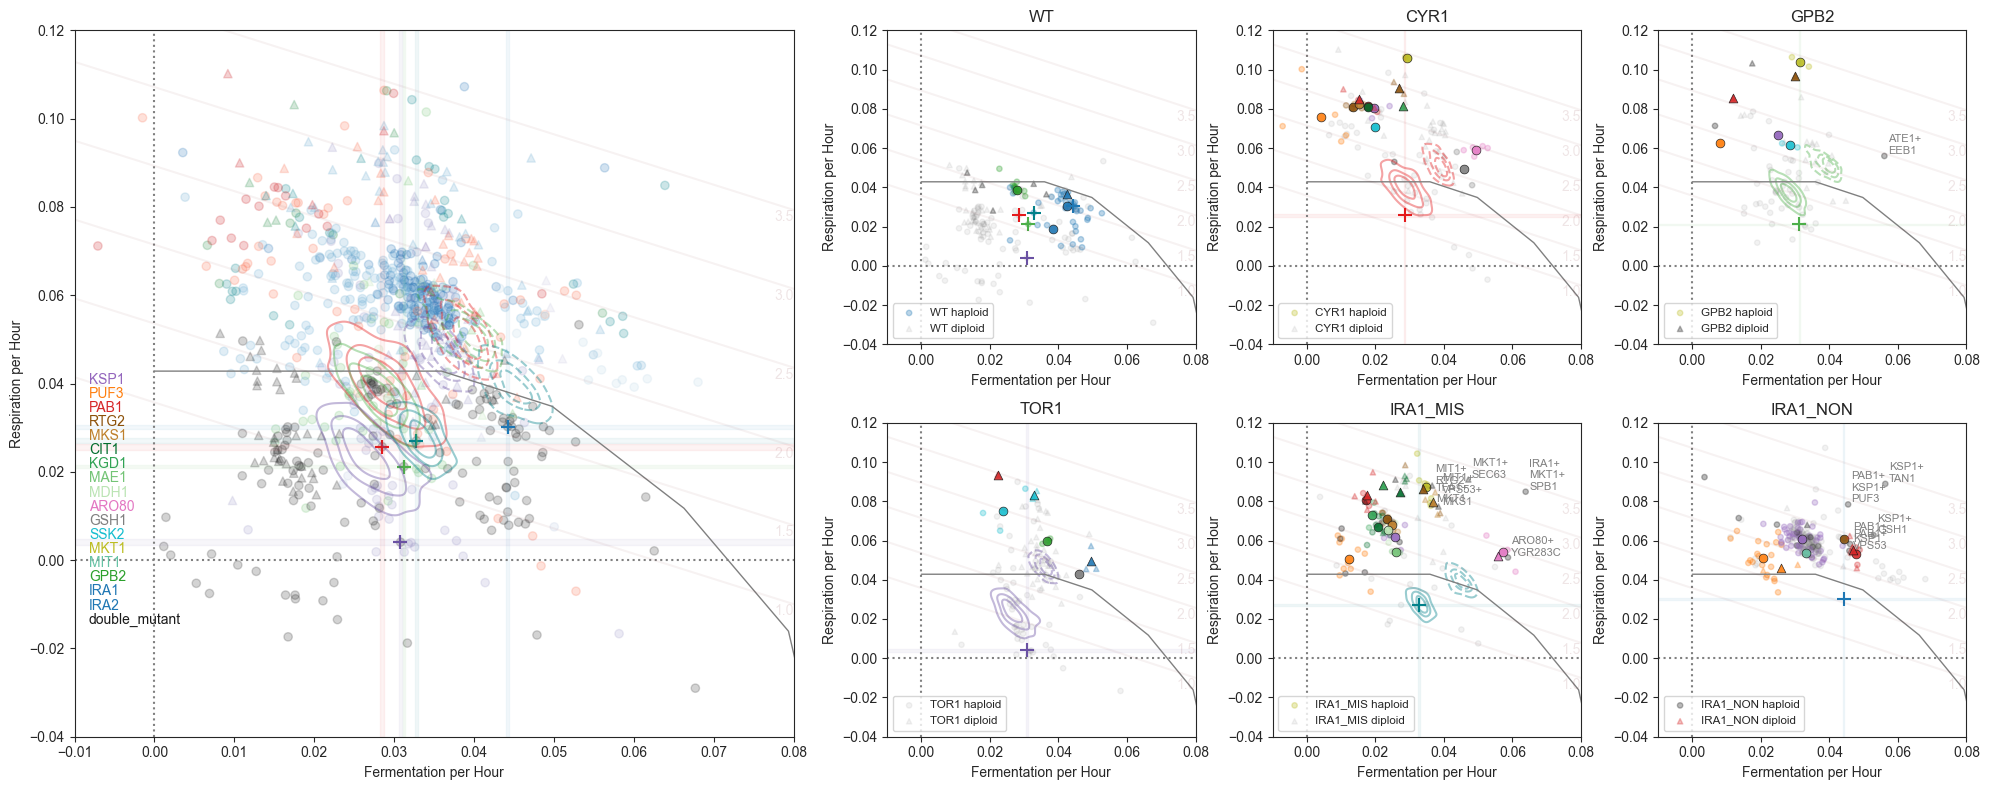

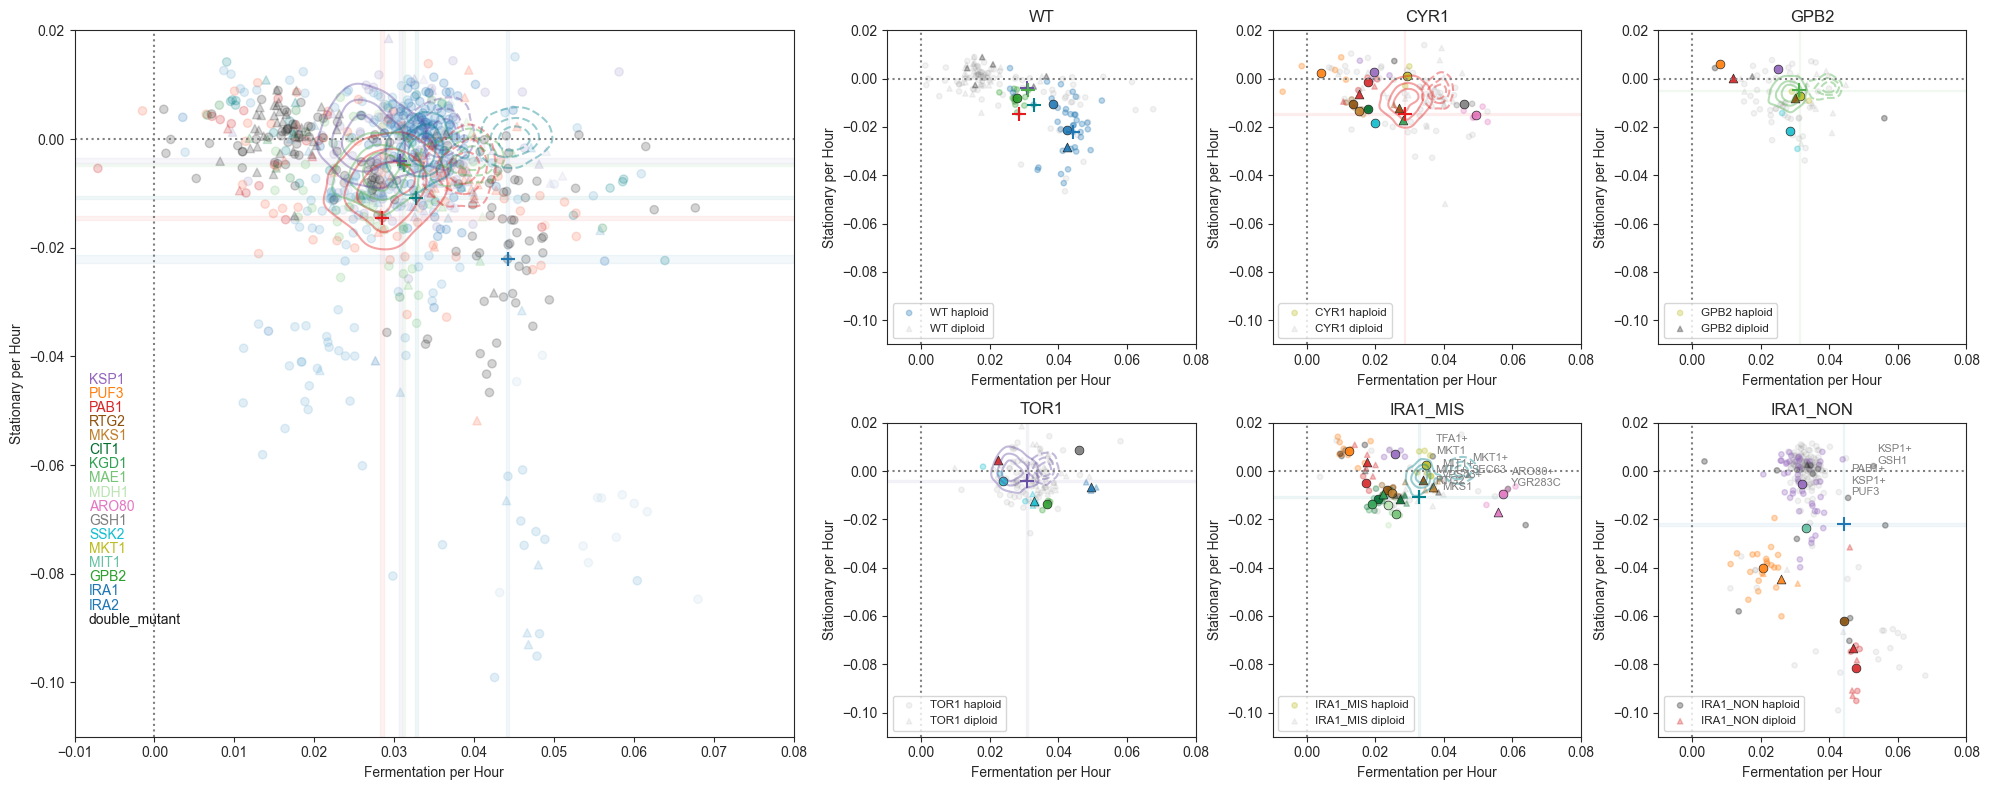

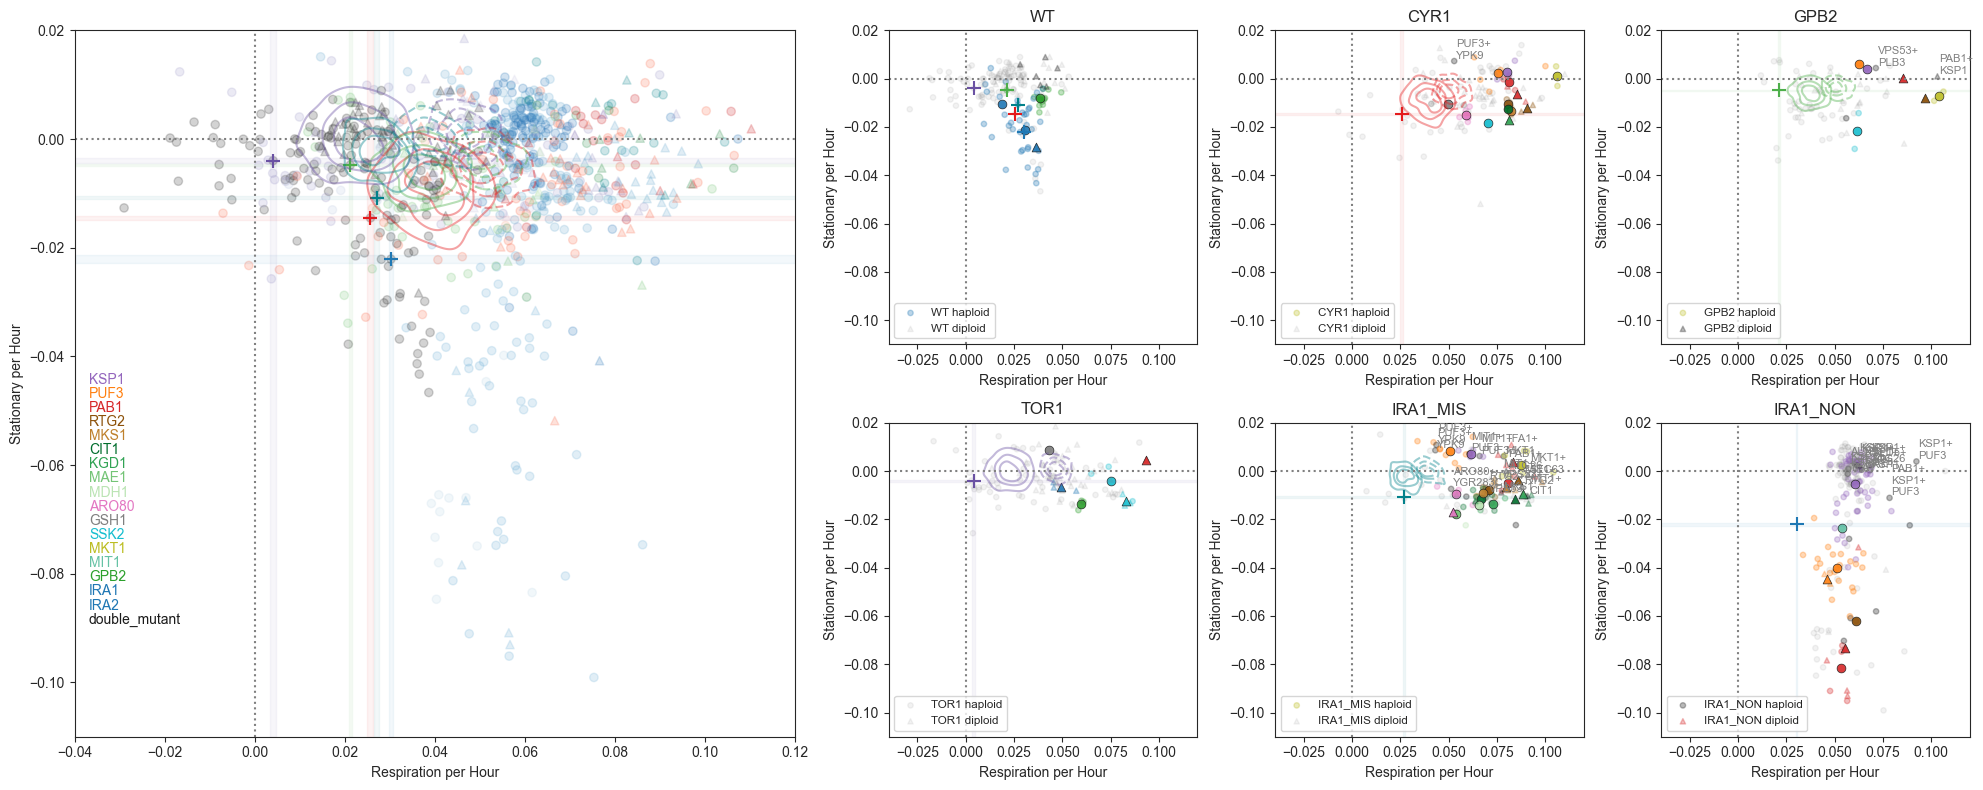

In [95]:
colors = [tools.anc_color_map[anc] for anc in merged_fitness['ancestor']]
# colors = ['b' if source=='This_study' else 'r' if source=='Li2019' else 'orange' if source == 'Aggeli2020' else 'k' for source in nonan_merged['source_publication_x']]

# non_diploid = merged_fitness[merged_fitness['ploidy']!='Diploid']

xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

xlabel = 'Stationary per Hour'
ylabel = 'Respiration per Hour'
xdata = 'StaPerHour'
ydata = 'ResPerHour'
labels = {'FerPerHour':'Fermentation per Hour','ResPerHour':'Respiration per Hour','StaPerHour':'Stationary per Hour'}
lims = {'FerPerHour':[-0.05,0.07],'ResPerHour':[-0.05,0.12],'StaPerHour':[-0.09,0.045]}

# evo_cond_list = ['Evo1D']
evo_cond_list = ['Evo2D']
# evo_cond_list = ['Evo3D']
evo_cond_list = ['Evo1D','Evo2D','Evo3D']

for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
# publication_list = [['This_study','Li2019','Aggeli2020','Venkataram2015'],['Venkataram2015'],['Li2019'],['Aggeli2020'],['This_study'],['Venkataram2015','This_study']] 
    ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]
    fig = plt.figure(figsize=(20,8))
    outer_gs = gridspec.GridSpec(1, 2,width_ratios=[2,3])

    for a,ancs in enumerate(ancestor_list):
        inner_gs = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec = outer_gs[1],wspace=0.25,hspace=0.25)
#         this_anc = non_diploid[non_diploid['ancestor'].isin(ancs)]
        
        this_anc = merged_fitness[merged_fitness['ancestor'].isin(ancs)]
        
        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values
        
        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]

        if len(ancs) > 1:
            fig.add_subplot(outer_gs[0]) 
        else:
            fig.add_subplot(inner_gs[a-1])
            
        for anc in ancs:
            if anc != 'WT':
                this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]

                sns.kdeplot(x=this_pure_diploid[xdata].values,y=this_pure_diploid[ydata].values,
                            color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4,linestyles='--')

                this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]

                sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
                            color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)

#         for evo_cond in np.unique(this_anc['evolution_condition'].values):
        for ploidy,ploidy_list in {'haploid':['Haploid','haploid',np.nan,'?','NotSequenced','other'],'diploid':['diploid','Diploid']}.items():
#         for evo_cond in evo_cond_list:

            gene_list = {}
#             doubles_list = []

            this_data = interesting_muts[interesting_muts['ploidy_new'].isin(ploidy_list)]
            gray_alpha = 0.1
            bold_alpha = 0.3
            if len(ancs) < 2:
                colors = []
                annotation_list = []
                for e,gene in enumerate(this_data['gene'].values):
                    color_assigned = matplotlib.colors.to_rgba('gray',0.1)
                    already_assigned = False
                    if (not p.isnull(gene)) and (gene != 'NotSequenced'):
                        if gene in tools.mutation_color_map.keys():
                            color_assigned = matplotlib.colors.to_rgba(tools.mutation_color_map[gene],bold_alpha)
                            
                            if gene in gene_list.keys():
                                gene_list[gene].append(e)
                            else:
                                gene_list[gene] = [e]
                        elif '+' in gene:
                            color_assigned = matplotlib.colors.to_rgba(tools.mutation_color_map['double_mutant'],bold_alpha)
                            
                            if anc != 'WT':
                                if this_data['barcode'].values[e] in innovation_list[f'{xdata}_{ydata}'][f'{anc}']:
                                    annotation_list.append([e,gene])
#                             if gene in gene_list.keys():
#                                 gene_list[gene].append(e)
#                             else:
#                                 gene_list[gene] = [e]
                        else:
                            color_assigned = matplotlib.colors.to_rgba('gray',0.1)
                    else:
                            color_assigned = matplotlib.colors.to_rgba('gray',0.1)
                    colors.append(color_assigned)
            else:
                colors = [tools.color_map[anc][evo_cond] for anc,evo_cond in zip(this_data['ancestor'],this_data['evolution_condition'])]

            if len(ancs) > 1:
                alpha = 0.2
#                 plt.errorbar(this_data[xdata].values,this_data[ydata].values,
#                             xerr=this_data[xdata+'_error'].values,
#                             yerr=this_data[ydata+'_error'].values,
#                             alpha=alpha,color='k',marker=' ',ls='none')
#                 plt.scatter(this_data[xdata].values,this_data[ydata].values,
#                             alpha=alpha,color=colors,marker=tools.evo_cond_marker_map[evo_cond])
    
                plt.scatter(this_data[xdata].values,this_data[ydata].values,
                            alpha=alpha,color=colors,marker=tools.ploidy_marker_map[ploidy])
               
                
            else:
                alpha = 0.3
#                 plt.scatter(this_data[xdata].values,this_data[ydata].values,
#                             color=colors,marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
                
                plt.scatter(this_data[xdata].values,this_data[ydata].values,
                            color=colors,marker=tools.ploidy_marker_map[ploidy],s=15,label=f'{ancs[0]} {ploidy}')
        
        
                for gene,e_list in gene_list.items():
                
                    gene_centroid = tools.centroid(this_data[[xdata,ydata]].values[e_list,:])
                    
                    plt.scatter(gene_centroid[0],gene_centroid[1],
                            color=colors[e_list[0]],edgecolors='k',linewidth=0.5,
                                marker=tools.ploidy_marker_map[ploidy],s=40,alpha=0.9)
                
    
                for e,doubles in annotation_list:
                    plt.annotate(text=doubles.replace('+','+\n'),xy=(this_data[xdata].values[e],this_data[ydata].values[e]),
                                 xytext=(this_data[xdata].values[e]+0.001,this_data[ydata].values[e]+0.001),
                                 color='gray',fontsize=8)

                plt.legend(loc='lower left',fontsize='small')
                plt.title(f'{ancs[0]}')
                
                    
        if xdata == 'FerPerHour' and ydata == 'ResPerHour':
            plt.plot(pareto_line[0],pareto_line[1],color='gray',lw=1)

#         for anc in ancs:
        for anc in ancs:
            if anc != 'WT':
                background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]
#                 plt.errorbar(background_mutant[xdata].values,background_mutant[ydata].values,
#                             xerr=background_mutant[xdata+'_error'].values,
#                             yerr=background_mutant[ydata+'_error'].values,
#                             marker=' ',color='k',ls='none')
                plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                            marker='+',color=tools.anc_color_map[anc],s=100)

                plt.axvspan(background_mutant[xdata].values-multiplier*background_mutant[xdata+'_error'].values,
                          background_mutant[xdata].values+multiplier*background_mutant[xdata+'_error'].values,
                          color=tools.anc_color_map[anc],alpha=0.05)

                plt.axhspan(background_mutant[ydata].values-multiplier*background_mutant[ydata+'_error'].values,
                          background_mutant[ydata].values+multiplier*background_mutant[ydata+'_error'].values,
                          color=tools.anc_color_map[anc],alpha=0.05)

            else:
                for anc2 in tools.rebarcoding_source_mutants.keys():
                    background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc2]]

                    plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                            marker='+',color=tools.anc_color_map[anc2],s=100)


        plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
        plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])

        plt.xlabel(labels[xdata])
        plt.ylabel(labels[ydata])

#         plt.axvline(0,color='k',linestyle=':')
#         plt.axhline(0,color='k',linestyle=':')
        
        plt.axvline(0,color='gray',linestyle=':')
        plt.axhline(0,color='gray',linestyle=':')
        
        
        if (xdata == 'FerPerHour') & (ydata == 'ResPerHour'):
            for fitness in [1.0,1.5,2.0,2.5,3.0,3.5]:
                ferms = np.linspace(tools.lims[xdata][0],tools.lims[xdata][1],100)
                resps = (fitness-16*ferms)/28 # 2day = 16*F
                
                
                norm = matplotlib.colors.Normalize(vmin=np.nanmin(merged_fitness[fitness_colorby]),
                        vmax=np.nanmax(merged_fitness[fitness_colorby]))

                cm = matplotlib.cm.ScalarMappable(norm=norm, cmap='Reds') 
                
                plt.plot(ferms,resps,color=cm.to_rgba(fitness),alpha=0.05)
                plt.text(x=ferms[-1],y=resps[-1],s=f'{fitness}',color=cm.to_rgba(fitness),alpha=0.1,ha='right',va='top')
            
        
        
        if len(ancs) > 1:
            for g,gene in enumerate(tools.mutation_color_map.keys()):
                plt.text(y=0.5-0.02*g,x=0.02,s=f'{gene}',color=tools.mutation_color_map[gene],transform=plt.gca().transAxes)

    plt.tight_layout()
#     plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_mutation_colors.pdf',bbox_inches='tight')
#     plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_mutation_colors_unannotated_centroids.pdf',bbox_inches='tight')
    plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_mutation_colors_centroids_annotatedInnovations.pdf',bbox_inches='tight')






In [41]:
innovation_list

{'FerPerHour_ResPerHour': {'CYR1': array(['AGAACAAAAACTAAACTCATTCATGG_AGTTAAATTGGGAAGGGTATTTTGAG',
         'GACAGAAAAGCCAAATGGATTTACCG_GAAGAAACAGCGAACAGGCTTTTTTA',
         'AGAACAAAAACTAAACTCATTCATGG_CGGAGAAGTGGCAAGAAGATTGTGAC',
         'GACAGAAAAGCCAAATGGATTTACCG_CGCGAAAATAGCTACACTGTTTCACG',
         'GACAGAAAAGCCAAATGGATTTACCG_CCCACAAACCGGAATTGTATTAACTA',
         'AGAACAAAAACTAAACTCATTCATGG_TTCTGAAAAAGTAATCAAATTACTCA',
         'ACTTAAAAAGCAAACATGATTATTCA_AAATCAAGAGCAAAAAACCTTTTAAA',
         'GACAGAAAAGCCAAATGGATTTACCG_CCGGAAACTGGAAACAATTTTGCAAT',
         'AGAACAAAAACTAAACTCATTCATGG_AGCTTAATCTAGAAGCGTTTTTGCAA',
         'AGAACAAAAACTAAACTCATTCATGG_TGAGTAAACAGAAAGAAGTTTCCAGC',
         'CTAGAAATCTCAAAAACTTTTGGCTG_AAAAGAACTAAAAAGGGTCTTCGGGG',
         'AGAACAAAAACTAAACTCATTCATGG_TCTCGAATAGATAATAATTTTATATA',
         'ACTTAAAAAGCAAACATGATTATTCA_ATAAAAAGAGAAAATTATATTAATTA',
         'AGAACAAAAACTAAACTCATTCATGG_CCGCCTAAACCTATTTATGTG'], dtype=object),
  'GPB2': array(['CCGCCAATCCCGAA

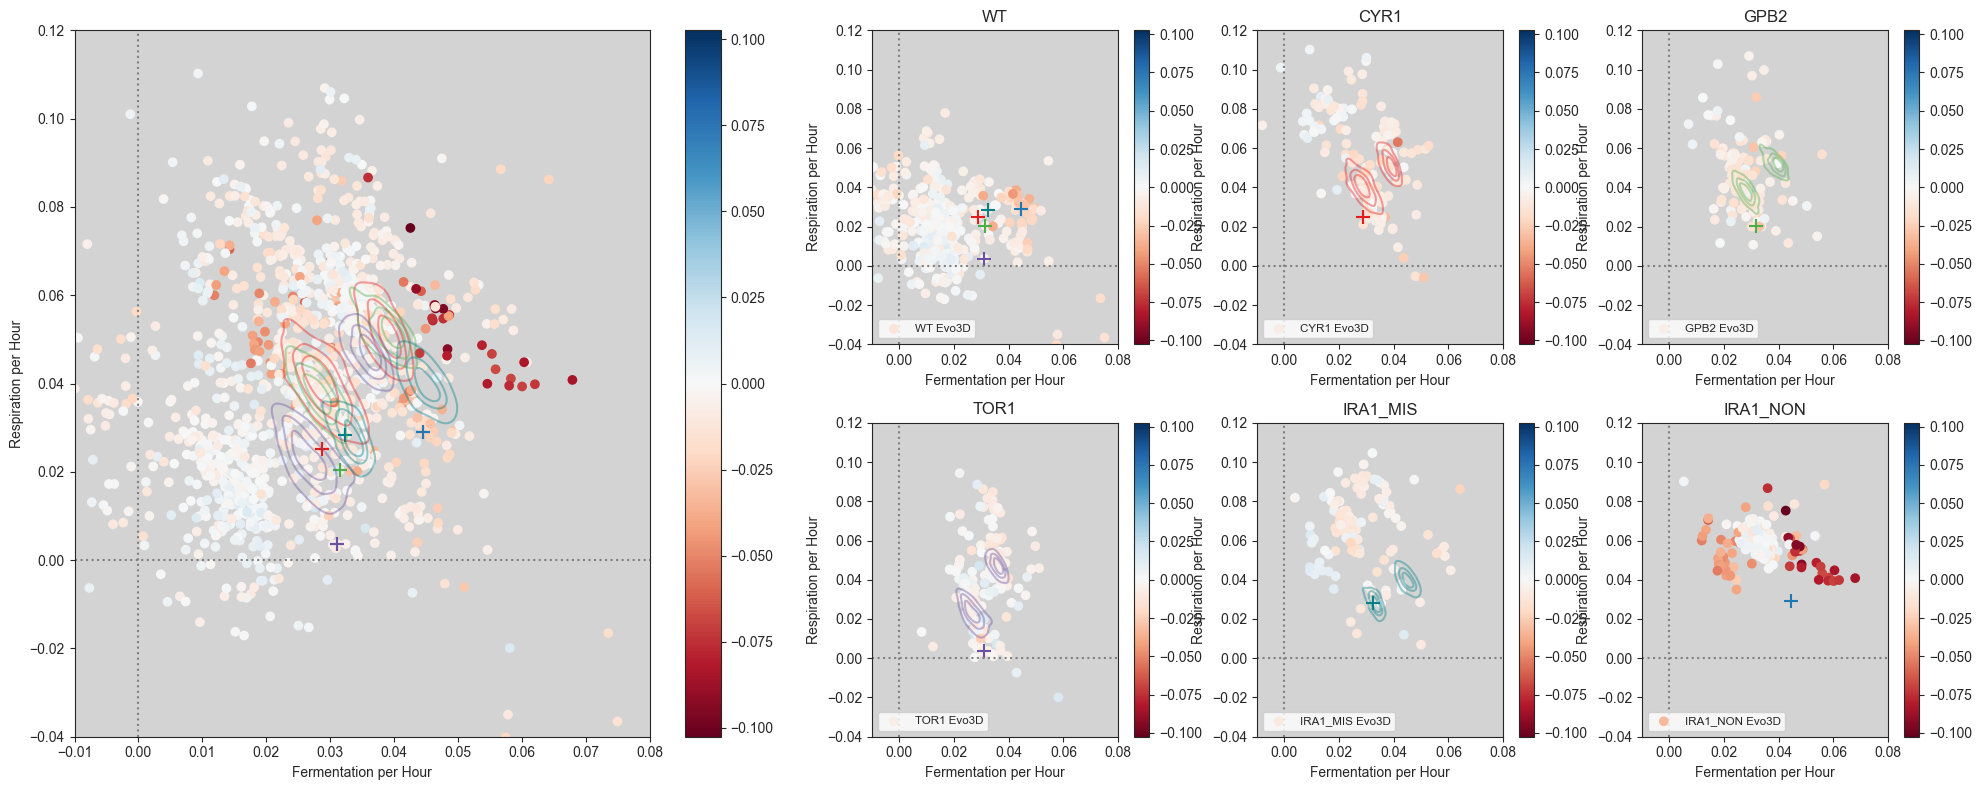

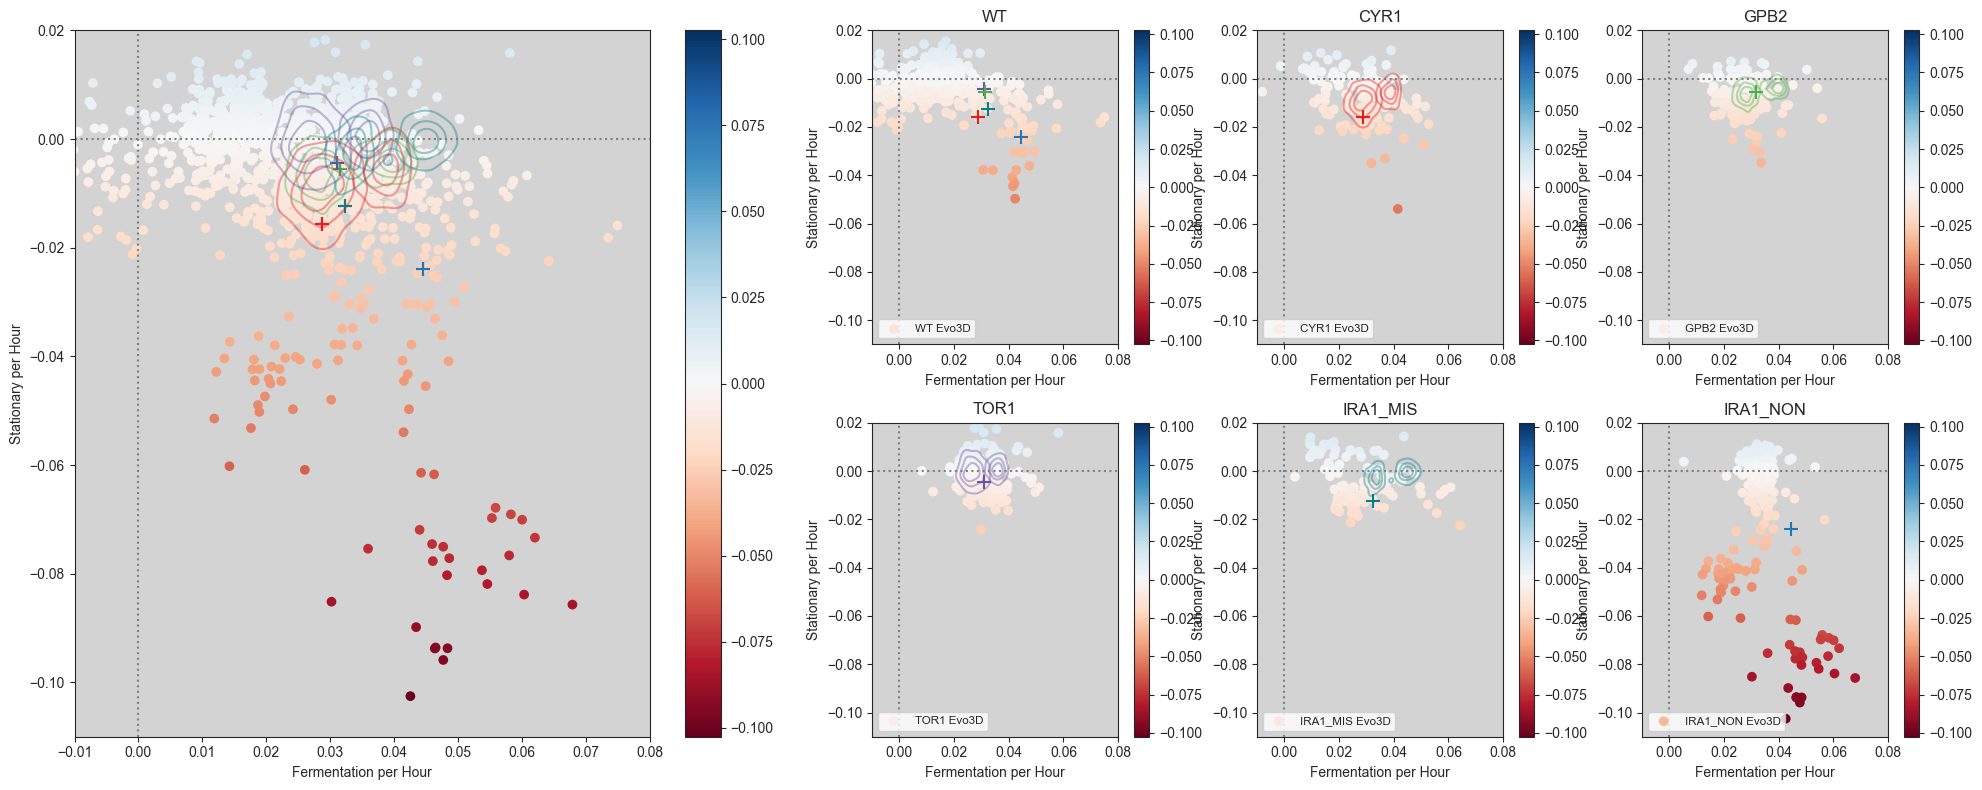

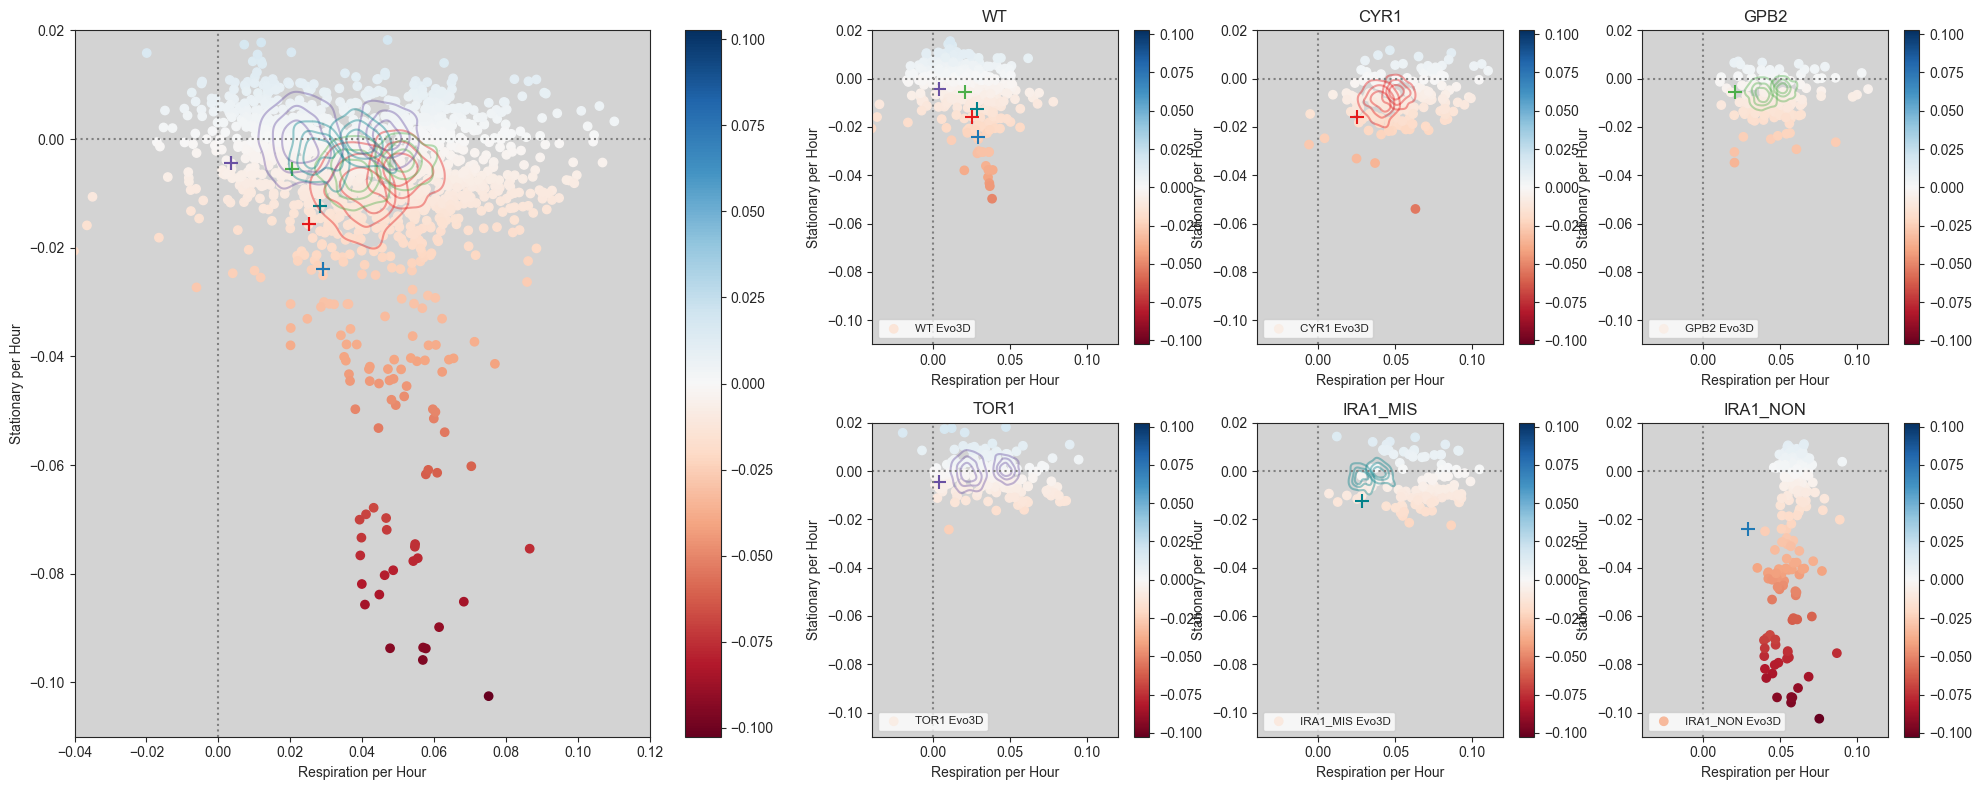

In [124]:
colors = [tools.anc_color_map[anc] for anc in merged_fitness['ancestor']]
# colors = ['b' if source=='This_study' else 'r' if source=='Li2019' else 'orange' if source == 'Aggeli2020' else 'k' for source in nonan_merged['source_publication_x']]

# non_diploid = merged_fitness[merged_fitness['ploidy']!='Diploid']

xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

xlabel = 'Stationary per Hour'
ylabel = 'Respiration per Hour'
xdata = 'StaPerHour'
ydata = 'ResPerHour'
labels = {'FerPerHour':'Fermentation per Hour','ResPerHour':'Respiration per Hour','StaPerHour':'Stationary per Hour'}
lims = {'FerPerHour':[-0.05,0.07],'ResPerHour':[-0.05,0.12],'StaPerHour':[-0.09,0.045]}

# evo_cond_list = ['Evo1D']
evo_cond_list = ['Evo2D']
# evo_cond_list = ['Evo3D']
evo_cond_list = ['Evo1D','Evo2D','Evo3D']

fitness_colorby = 'Fit2D_early_fitness'
fitness_colorby = 'Fit3D_early_fitness'
fitness_colorby = 'StaPerHour'
# fitness_colorby = merged_fitness['Fit3D_early_fitness']

for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
# publication_list = [['This_study','Li2019','Aggeli2020','Venkataram2015'],['Venkataram2015'],['Li2019'],['Aggeli2020'],['This_study'],['Venkataram2015','This_study']] 
    ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]
    fig = plt.figure(figsize=(20,8))
    outer_gs = gridspec.GridSpec(1, 2,width_ratios=[2,3])

    for a,ancs in enumerate(ancestor_list):
        inner_gs = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec = outer_gs[1],wspace=0.25,hspace=0.25)
#         this_anc = non_diploid[non_diploid['ancestor'].isin(ancs)]
        
        this_anc = merged_fitness[merged_fitness['ancestor'].isin(ancs)]
        
        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values
        
        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]

        if len(ancs) > 1:
            fig.add_subplot(outer_gs[0]) 
        else:
            fig.add_subplot(inner_gs[a-1])
        
        plt.gca().set_facecolor('lightgrey')
            
        for anc in ancs:
            if anc != 'WT':
                this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]

                sns.kdeplot(x=this_pure_diploid[xdata].values,y=this_pure_diploid[ydata].values,
                            color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)

                this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]

                sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
                            color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)
                
        this_data = interesting_muts

#  
        if len(ancs) > 1:
            alpha = 0.2
#                 plt.errorbar(this_data[xdata].values,this_data[ydata].values,
#                             xerr=this_data[xdata+'_error'].values,
#                             yerr=this_data[ydata+'_error'].values,
#                             alpha=alpha,color='k',marker=' ',ls='none')


            normalize = matplotlib.colors.TwoSlopeNorm(vmin=-1*np.abs(merged_fitness[fitness_colorby]).max(),
                                            vcenter=0., 
                                            vmax=np.abs(merged_fitness[fitness_colorby]).max())
            
            sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
                        c=this_data[fitness_colorby].values,cmap='RdBu',
                        norm=normalize,
                        marker='o',label=f'{ancs[0]} {evo_cond}')


#             sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
#                         c=this_data[fitness_colorby].values,cmap='RdGy',
#                         vmin=np.nanmin(merged_fitness[fitness_colorby]),
#                         vmax=np.nanmax(merged_fitness[fitness_colorby]),
#                         marker='o',label=f'{ancs[0]} {evo_cond}')
            plt.colorbar(sc)


        else:
            alpha = 0.3
            normalize = matplotlib.colors.TwoSlopeNorm(vmin=-1*np.abs(merged_fitness[fitness_colorby]).max(),
                                            vcenter=0., 
                                            vmax=np.abs(merged_fitness[fitness_colorby]).max())
            
            sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
                        c=this_data[fitness_colorby].values,cmap='RdBu',
                        norm=normalize,
                        marker='o',label=f'{ancs[0]} {evo_cond}')
            
            
#             sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
#                         c=this_data[fitness_colorby].values,cmap='RdGy',
#                         vmin=np.nanmin(merged_fitness[fitness_colorby]),
#                         vmax=np.nanmax(merged_fitness[fitness_colorby]),
#                         marker='o',label=f'{ancs[0]} {evo_cond}')
            plt.colorbar(sc)

            plt.legend(loc='lower left',fontsize='small')
            plt.title(f'{ancs[0]}')
                
            
#         for anc in ancs:
        for anc in ancs:
            if anc != 'WT':
                background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]
#                 plt.errorbar(background_mutant[xdata].values,background_mutant[ydata].values,
#                             xerr=background_mutant[xdata+'_error'].values,
#                             yerr=background_mutant[ydata+'_error'].values,
#                             marker=' ',color='k',ls='none')
                plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                            marker='+',color=tools.anc_color_map[anc],s=100)
            else:
                for anc2 in tools.rebarcoding_source_mutants.keys():
                    background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc2]]

                    plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                            marker='+',color=tools.anc_color_map[anc2],s=100)


        plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
        plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])

        plt.xlabel(labels[xdata])
        plt.ylabel(labels[ydata])

#         plt.axvline(0,color='k',linestyle=':')
#         plt.axhline(0,color='k',linestyle=':')
        
        plt.axvline(0,color='gray',linestyle=':')
        plt.axhline(0,color='gray',linestyle=':')
        
#         if (xdata == 'FerPerHour') & (ydata == 'ResPerHour'):
#             for fitness in [1.0,1.5,2.0,2.5,3.0]:
#                 ferms = np.linspace(tools.lims[xdata][0],tools.lims[xdata][1],100)
#                 resps = (fitness-16*ferms)/28 # 2day = 16*F
                
                
#                 norm = matplotlib.colors.Normalize(vmin=np.nanmin(merged_fitness[fitness_colorby]),
#                         vmax=np.nanmax(merged_fitness[fitness_colorby]))

#                 cm = matplotlib.cm.ScalarMappable(norm=norm, cmap='Reds') 
                
#                 plt.plot(ferms,resps,color=cm.to_rgba(fitness),alpha=0.4)
#                 plt.text(x=ferms[-1],y=resps[-1],s=f'{fitness}',color=cm.to_rgba(fitness),ha='right',va='top')
            
            
            
        
#         if len(ancs) > 1:
#             for g,gene in enumerate(tools.mutation_color_map.keys()):
#                 plt.text(y=0.5-0.02*g,x=0.02,s=f'{gene}',color=tools.mutation_color_map[gene],transform=plt.gca().transAxes)

    plt.tight_layout()
#     plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_mutation_colors.pdf',bbox_inches='tight')
    plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_{fitness_colorby.split("_")[0]}fitness_colors.pdf',bbox_inches='tight')







In [9]:
merged_fitness[(merged_fitness['ResPerHour']>0.08) & (merged_fitness['FerPerHour']>0.04) ][['barcode','evolution_condition','gene','class_new','all_mutations_verbose']].values

array([['TATCGAAACCCAAAGAGATTTAATCG_CGATCAAAGACTAACTTATTTTGTGG', 'Evo3D',
        'IRA1+MKT1+SPB1', 'adaptive_haploid',
        'II:441856:C:T:MMS4:synonymous_variant:c.342C>T:p.Asn114Asn:1/1~II:521600:C:A:IRA1:stop_gained:c.5029G>T:p.Glu1677*:1/1~II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val:1/1~III:32114:G:T:SPB1:missense_variant:c.666G>T:p.Leu222Phe:1/1~XIV:467219:A:C:MKT1:missense_variant:c.89A>C:p.Asp30Ala:1/1'],
       ['ATCACAATAACTAAACTGATTCTTCA_CTCATAACATCAAAAAAAATTCAAAT', 'Evo3D',
        'KSP1+TAN1', 'adaptive_haploid',
        'II:522427:A:T:IRA1:stop_gained:c.4202T>A:p.Leu1401*:1/1~VI:101127:T:A:LPD1:downstream_gene_variant:c.*501A>T:nan:1/1~VII:62635:G:T:TAN1:missense_variant:c.503G>T:p.Cys168Phe:0/1~VII:161471:G:C:ATG1:missense_variant:c.1407G>C:p.Leu469Phe:1/1~VIII:270229:GA:G:KSP1:frameshift_variant:c.1319delT:p.Phe440fs:0/1~VIII:271405:G:T:KSP1:stop_gained:c.144C>A:p.Tyr48*:1/1~XII:1029498:C:A:RPL6B:synonymous_variant:c.261C>A:p.Thr87Thr:1/1~XIV:204739:G:

In [11]:
np.unique(merged_fitness['source_publication'].values)

array(['Aggeli2020', 'Li2019', 'This_study', 'Venkataram2015'],
      dtype=object)

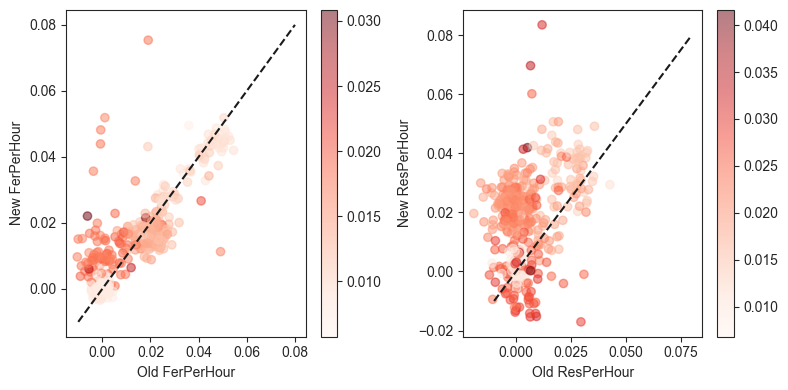

In [123]:

venk_muts = merged_fitness[merged_fitness['source_publication']=='Venkataram2015']

plt.colorbar


plt.figure(figsize=(8,4))
plt.subplot(121)
sc =plt.scatter(venk_muts['FerPerHour_Li2019'].values,venk_muts['FerPerHour'].values,alpha=0.5,
            c=np.sqrt(venk_muts['FerPerHour_error'].values),cmap='Reds')
plt.colorbar(sc)
plt.plot([-0.01,0.08],[-0.01,0.08],'k--')
plt.xlabel('Old FerPerHour')
plt.ylabel('New FerPerHour')

plt.subplot(122)
sc =plt.scatter(venk_muts['ResPerHour_Li2019'].values,venk_muts['ResPerHour'].values,alpha=0.5,
            c=np.sqrt(venk_muts['ResPerHour_error'].values),cmap='Reds')
plt.colorbar(sc)
plt.plot([-0.01,0.08],[-0.01,0.08],'k--')
plt.xlabel('Old ResPerHour')
plt.ylabel('New ResPerHour')

plt.tight_layout()

In [13]:
merged_fitness[merged_fitness['gene']=='ALD5']['all_mutations_verbose'].values

array(['II:610499:A:T:MED8:upstream_gene_variant:c.-746T>A:nan:1/1~V:303524:AT:ATT:ALD5:upstream_gene_variant:c.-505_-504insT:nan:0/1~X:427906:C:A:CYR1:missense_variant:c.2750C>A:p.Ser917Tyr:0/1~XII:196744:T:A:UBR2:upstream_gene_variant:c.-3463A>T:nan:0/1~XVI:940751:T:G:ARR3:missense_variant:c.830T>G:p.Ile277Ser:0/1',
       'II:522427:A:T:IRA1:stop_gained:c.4202T>A:p.Leu1401*:1/1~V:303524:AT:ATT:ALD5:upstream_gene_variant:c.-505_-504insT:nan:1/1~VI:101127:T:A:YFL021C-A:upstream_gene_variant:c.-4512A>T:nan:1/1~XII:841888:C:A:RSC2:synonymous_variant:c.558C>A:p.Val186Val:1/1~XII:1029498:C:A:RPL6B:synonymous_variant:c.261C>A:p.Thr87Thr:1/1'],
      dtype=object)

In [14]:
ancestor_list

[['WT', 'CYR1', 'GPB2', 'TOR1', 'IRA1_MIS', 'IRA1_NON'],
 ['WT'],
 ['CYR1'],
 ['GPB2'],
 ['TOR1'],
 ['IRA1_MIS'],
 ['IRA1_NON']]

In [15]:
merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants['GPB2']][['barcode','all_mutations_verbose']].values

array([['CGCTAAAGACATAATGTGGTTTGTTG_TCATGAACGGATAAGCTGGTTGGTTG', nan]],
      dtype=object)

In [16]:
merged_fitness

Fit1D-2%-R1_fitness  Fit1D-2%-R1_error  Fit1D-2%-R2_fitness  \
0                0.770538           0.056064             0.798667   
1                0.938763           0.035535             1.009834   
2                0.850726           0.053260             0.837848   
3                1.074590           0.049368             1.048208   
4                0.931656           0.050006             0.962649   
...                   ...                ...                  ...   
4999             0.388302           0.833230             0.405459   
5000             0.779675           0.079662             0.802178   
5001             0.482098           0.188088             0.630145   
5002             0.822036           0.084740             0.806927   
5003             0.743676           0.910953             0.656744   

      Fit1D-2%-R2_error  Fit1D-5%-R1_fitness  Fit1D-5%-R1_error  \
0              0.056490             0.793227           0.037792   
1              0.036124             0.936852           0.024449   
2              0.056183             0.847252           0.039778   
3              0.050017             0.913976           0.039413   
4              0.052219             0.851260           0.038401   
...                 ...                  ...                ...   
4999           0.622680             0.182802           0.424601   
5000           0.078588             0.714047           0.057034   
5001           0.145766             0.495766           0.132897   
5002           0.090888             0.685954           0.066067   
5003           0.798101             0.649882           0.631442   

      Fit1D-5%-R2_fitness  Fit1D-5%-R2_error  Fit2D-2%-R1_fitness  \
0                0.777312           0.034586             1.152181   
1                0.940881           0.024295             1.721427   
2                0.851379           0.033796             1.230381   
3                0.963205           0.035169             1.364335   
4                0.939050           0.034383             1.111230   
...                   ...                ...                  ...   
4999             0.998668           0.298171             0.726315   
5000             0.810990           0.048184             0.713101   
5001             0.457116           0.097001             0.576438   
5002             0.751837           0.054305             0.704487   
5003             0.005989           0.807006             0.474012   

      Fit2D-2%-R1_error  ...  Fit2D_early-Fit1D_both2%5%_error  \
0              0.032200  ...                          0.047674   
1              0.024800  ...                          0.023233   
2              0.030045  ...                          0.044350   
3              0.032921  ...                          0.074683   
4              0.035139  ...                          0.060054   
...                 ...  ...                               ...   
4999           0.660909  ...                          0.766384   
5000           0.114501  ...                          0.136783   
5001           0.270611  ...                          0.276388   
5002           0.129870  ...                          0.164349   
5003           1.846689  ...                          0.863963   

      Fit5D_early-Fit3D_early_fitness  Fit5D_early-Fit3D_early_error  \
0                            1.004670                       0.011918   
1                            1.197220                       0.005808   
2                            1.171882                       0.011088   
3                            0.747392                       0.018671   
4                            1.074941                       0.015013   
...                               ...                            ...   
4999                         0.244001                       0.191596   
5000                         0.562602                       0.034196   
5001                         0.141856                       0.069097   
5002                         0

In [255]:
merged_fitness[(merged_fitness['ancestor']=='CYR1') & (merged_fitness['ResPerHour']>0.06) & (merged_fitness['FerPerHour']>0.03)][['barcode','gene','ResPerHour','FerPerHour','all_mutations_verbose','class_new']].values

array([['AGAACAAAAACTAAACTCATTCATGG_AGTTAAATTGGGAAGGGTATTTTGAG', nan,
        0.0720901336914843, 0.0403535329993439,
        'X:427906:C:A:CYR1:NON_SYNONYMOUS_CODING:tCt/tAt:S917Y:1/1~XI:536733:A:C:DYN1:NON_SYNONYMOUS_CODING:gaT/gaG:D3731E:0/1~XVI:940751:T:G:ARR3:NON_SYNONYMOUS_CODING:aTt/aGt:I277S:1/1',
        'high_fitness_diploids'],
       ['GACAGAAAAGCCAAATGGATTTACCG_GAAGAAACAGCGAACAGGCTTTTTTA', nan,
        0.068328147984838, 0.0408495280354269,
        'VII:647252:C:A:MRP13:NON_SYNONYMOUS_CODING:ttG/ttT:L297F:0/1~X:427906:C:A:CYR1:NON_SYNONYMOUS_CODING:tCt/tAt:S917Y:1/1~XII:844184:T:C:ADE13:UPSTREAM:98:nan:0/1~XV:302387:A:C:HRD1:NON_SYNONYMOUS_CODING:Tca/Gca:S217A:0/1~XV:516101:T:G:RAS1:SYNONYMOUS_CODING:tcT/tcG:S286:1/1~XVI:940751:T:G:ARR3:NON_SYNONYMOUS_CODING:aTt/aGt:I277S:1/1',
        'high_fitness_diploids'],
       ['AGAACAAAAACTAAACTCATTCATGG_CGGAGAAGTGGCAAGAAGATTGTGAC', nan,
        0.0724982340682828, 0.0401019397389216, nan,
        'high_fitness_diploids'],
       

In [28]:
merged_fitness[(merged_fitness['ancestor']=='IRA1_MIS') & (merged_fitness['FerPerHour']<0.05)][['barcode','gene','ResPerHour','FerPerHour','all_mutations_verbose','class_new']].values

array([['TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTCATCA', nan,
        0.0837224740747128, 0.0281176955107672,
        'II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val:1/1~XI:278880:G:C:CYT2:upstream_gene_variant:c.-1017C>G:nan:1/1~XII:1047634:T:C:FMP27:missense_variant:c.3637T>C:p.Trp1213Arg:0/1~XV:87280:AT:A:MDH2:upstream_gene_variant:c.-4361delA:nan:1/1',
        'high_fitness_diploids'],
       ['TATCGAAACCCAAAGAGATTTAATCG_ATGACAAACTTTAAATAATTTAATTG', 'MKT1',
        0.08957838823135, 0.0349819673911032,
        'II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val:1/1~XIV:467219:A:T:MKT1:missense_variant:c.89A>T:p.Asp30Val:1/1',
        'adaptive_haploid'],
       ['TATCGAAACCCAAAGAGATTTAATCG_TTGCCAAGCTGGAAAGCTTTTTATGA', 'MKT1',
        0.0784188365217231, 0.0361613813608241,
        'I:9660:G:C:SEO1:upstream_gene_variant:c.-644C>G:nan:1/1~II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val:1/1~IX:41:C:CA:YIL177W-A:upstream_gene_variant:c.-805_-804in

In [45]:
merged_fitness[(merged_fitness['ancestor']=='IRA1_NON') & (merged_fitness['gene']=='MIT1')][['barcode','gene','effect','ResPerHour','FerPerHour','all_mutations_verbose','class_new']].values

array([['CCAACAAAACACAAATCTGTTGTGTA_TACATAATACTCAATCTACTTTTTCA', 'MIT1',
        'disruptive_inframe_deletion', 0.0539156630651128,
        0.0333484721044173,
        'II:522427:A:T:IRA1:stop_gained:c.4202T>A:p.Leu1401*:1/1~V:142941:CAAT:C:MIT1:disruptive_inframe_deletion:c.1083_1085delTAA:p.Asn362del:0/1~VI:101127:T:A:LPD1:downstream_gene_variant:c.*501A>T:nan:1/1~XII:1029498:C:A:RPL6B:synonymous_variant:c.261C>A:p.Thr87Thr:1/1~XV:608680:G:T:SPP2:missense_variant:c.518C>A:p.Thr173Lys:1/1',
        'adaptive_haploid']], dtype=object)

In [42]:
merged_fitness[(merged_fitness['ancestor']=='IRA1_NON') & (merged_fitness['gene']=='ALD5')][['barcode','gene','ResPerHour','FerPerHour','all_mutations_verbose','class_new']].values

array([['AATGCAATAATGAAATGATTTGAGGA_CATCGAAGGGAAAACCAGCTTAGCCG', 'ALD5',
        0.0408174097160149, 0.0679315582491055,
        'II:522427:A:T:IRA1:stop_gained:c.4202T>A:p.Leu1401*:1/1~V:303524:AT:ATT:ALD5:upstream_gene_variant:c.-505_-504insT:nan:1/1~VI:101127:T:A:YFL021C-A:upstream_gene_variant:c.-4512A>T:nan:1/1~XII:841888:C:A:RSC2:synonymous_variant:c.558C>A:p.Val186Val:1/1~XII:1029498:C:A:RPL6B:synonymous_variant:c.261C>A:p.Thr87Thr:1/1',
        'adaptive_haploid']], dtype=object)

In [252]:
merged_fitness[(merged_fitness['ancestor']=='CYR1') & (merged_fitness['gene']=='MKT1')][['barcode','gene','ResPerHour','FerPerHour','all_mutations_verbose','class_new']].values

array([['GACAGAAAAGCCAAATGGATTTACCG_CGACAAATCCCGAAGAACTTTTTTTA', 'MKT1',
        0.1043118793963711, 0.0299279661149942,
        'X:427906:C:A:CYR1:NON_SYNONYMOUS_CODING:tCt/tAt:S917Y:1~XIII:142078:G:C:ORC1:UPSTREAM:132:nan:1~XIII:810030:A:G:SCS7:NON_SYNONYMOUS_CODING:Ttc/Ctc:F250L:1~XIV:467219:A:G:MKT1:NON_SYNONYMOUS_CODING:gAt/gGt:D30G:1~XVI:940751:T:G:ARR3:NON_SYNONYMOUS_CODING:aTt/aGt:I277S:1',
        'adaptive_haploid'],
       ['GACAGAAAAGCCAAATGGATTTACCG_CTCATAACATAGAAGATGCTTCGCAG', 'MKT1',
        0.1060550808886064, 0.0300721575572152,
        'II:610499:A:T:MED8:upstream_gene_variant:c.-746T>A:nan:1/1~III:39458:A:G:PBN1:upstream_gene_variant:c.-4065T>C:nan:1/1~X:427906:C:A:CYR1:missense_variant:c.2750C>A:p.Ser917Tyr:1/1~XII:196744:T:A:UBR2:upstream_gene_variant:c.-3463A>T:nan:1/1~XIV:467219:A:G:MKT1:missense_variant:c.89A>G:p.Asp30Gly:1/1~XVI:940751:T:G:ARR3:missense_variant:c.830T>G:p.Ile277Ser:1/1',
        'adaptive_haploid']], dtype=object)

In [250]:
merged_fitness[(merged_fitness['ancestor']=='IRA1_MIS') & (merged_fitness['gene']=='MKT1')][['barcode','gene','ResPerHour','FerPerHour','all_mutations_verbose','class_new']].values

array([['TATCGAAACCCAAAGAGATTTAATCG_ATGACAAACTTTAAATAATTTAATTG', 'MKT1',
        0.08957838823135, 0.0349819673911032,
        'II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val:1/1~XIV:467219:A:T:MKT1:missense_variant:c.89A>T:p.Asp30Val:1/1',
        'adaptive_haploid'],
       ['TATCGAAACCCAAAGAGATTTAATCG_TTGCCAAGCTGGAAAGCTTTTTATGA', 'MKT1',
        0.0784188365217231, 0.0361613813608241,
        'I:9660:G:C:SEO1:upstream_gene_variant:c.-644C>G:nan:1/1~II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val:1/1~IX:41:C:CA:YIL177W-A:upstream_gene_variant:c.-805_-804insA:nan:0/1~X:745342:T:C:COS5:upstream_gene_variant:c.-1343A>G:nan:1/1~XIV:467219:A:G:MKT1:missense_variant:c.89A>G:p.Asp30Gly:1/1~XV:436911:A:G:ASE1:upstream_gene_variant:c.-566T>C:nan:1/1',
        'adaptive_haploid'],
       ['TATCGAAACCCAAAGAGATTTAATCG_GTTTAAACCATTAATTATATTAGATC', 'MKT1',
        0.0814410843462487, 0.0363257213464656,
        'II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val:1/1~

In [19]:
merged_fitness[(merged_fitness['ancestor']=='IRA1_NON') & (merged_fitness['ResPerHour']>0.08)][['barcode','gene','ResPerHour','FerPerHour','all_mutations_verbose','class_new']].values

array([['ATCACAATAACTAAACTGATTCTTCA_CTCATAACATCAAAAAAAATTCAAAT',
        'KSP1+TAN1', 0.0885399222973031, 0.0567146898551585,
        'II:522427:A:T:IRA1:stop_gained:c.4202T>A:p.Leu1401*:1/1~VI:101127:T:A:LPD1:downstream_gene_variant:c.*501A>T:nan:1/1~VII:62635:G:T:TAN1:missense_variant:c.503G>T:p.Cys168Phe:0/1~VII:161471:G:C:ATG1:missense_variant:c.1407G>C:p.Leu469Phe:1/1~VIII:270229:GA:G:KSP1:frameshift_variant:c.1319delT:p.Phe440fs:0/1~VIII:271405:G:T:KSP1:stop_gained:c.144C>A:p.Tyr48*:1/1~XII:1029498:C:A:RPL6B:synonymous_variant:c.261C>A:p.Thr87Thr:1/1~XIV:204739:G:A:KEX2:missense_variant:c.2312G>A:p.Ser771Asn:1/1',
        'adaptive_haploid'],
       ['CCAACAAAACACAAATCTGTTGTGTA_TCCTAAACGAAAACTTGGTTTGTTA', nan,
        0.0866566528532453, 0.0359472446856699, nan, 'adaptive_haploid'],
       ['ATCACAATAACTAAACTGATTCTTCA_CTTCTAAACCCCAACAATTTTCTGTG',
        'KSP1+PUF3', 0.090125977766071, 0.0053632253136022,
        'II:522427:A:T:IRA1:stop_gained:c.4202T>A:p.Leu1401*:1/1~VI:101127:

In [22]:
merged_fitness[merged_fitness['barcode']=='CCAACAAAACACAAATCTGTTGTGTA_TCCTAAACGAAAACTTGGTTTGTTA']['Fit2D-2%-R1-T3']

1217    11428
Name: Fit2D-2%-R1-T3, dtype: int64

In [18]:
lc = tools.long_colors
[lc[4],lc[1], lc[3], lc[5] ]# brown
#     'CIT1':long_colors[11], # light orange
#     'ARO80':long_colors[6], # pink
#     'GSH1':long_colors[7],
#     'MKS1':long_colors[13], # light pink
#     'SSK2':long_colors[9], # teal
#     'MKT1':long_colors[8], # 
#     'MIT1':long_colors[10],
#     'GPB2':long_colors[2], # green
#     'KGD1':long_colors[12],
#     'MAE1':long_colors[14],
#     'MDH1':long_colors[14],
#     'IRA1':long_colors[0], # blue (obviously)
#     'IRA2':long_colors[0],

[(0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)]

In [22]:
[f'{i},{matplotlib.colors.to_hex(c)}' for i,c in enumerate(lc)]

['0,#1f77b4',
 '1,#ff7f0e',
 '2,#2ca02c',
 '3,#d62728',
 '4,#9467bd',
 '5,#8c564b',
 '6,#e377c2',
 '7,#7f7f7f',
 '8,#bcbd22',
 '9,#17becf',
 '10,#66c2a5',
 '11,#fc8d62',
 '12,#8da0cb',
 '13,#e78ac3',
 '14,#a6d854',
 '15,#ffd92f',
 '16,#e5c494',
 '17,#b3b3b3']

In [27]:
merged_fitness[merged_fitness['gene']=='MKT1'][['barcode','all_mutations_verbose','ancestor','evolution_condition','FerPerHour','ResPerHour']].values

array([['CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTTTGAGT',
        'I:40104:T:G:GPB2:STOP_GAINED:taT/taG:Y282*:1~VI:101127:T:A:LPD1:DOWNSTREAM:501:nan:1~VI:58065:C:A:TUB2:DOWNSTREAM:356:nan:1~XIV:467219:A:G:MKT1:NON_SYNONYMOUS_CODING:gAt/gGt:D30G:1~XV:75632:C:T:ALR1:SYNONYMOUS_CODING:gaC/gaT:D411:1',
        'GPB2', 'Evo2D', 0.0346264727792299, 0.0997683098200937],
       ['TATCGAAACCCAAAGAGATTTAATCG_ATGACAAACTTTAAATAATTTAATTG',
        'II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val:1/1~XIV:467219:A:T:MKT1:missense_variant:c.89A>T:p.Asp30Val:1/1',
        'IRA1_MIS', 'Evo3D', 0.0349819673911032, 0.08957838823135],
       ['TATCGAAACCCAAAGAGATTTAATCG_TTGCCAAGCTGGAAAGCTTTTTATGA',
        'I:9660:G:C:SEO1:upstream_gene_variant:c.-644C>G:nan:1/1~II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val:1/1~IX:41:C:CA:YIL177W-A:upstream_gene_variant:c.-805_-804insA:nan:0/1~X:745342:T:C:COS5:upstream_gene_variant:c.-1343A>G:nan:1/1~XIV:467219:A:G:MKT1:missense_variant:c.8

In [36]:
merged_fitness[merged_fitness['all_mutations_verbose']]

Empty DataFrame
Columns: [Fit1D-2%-R1_fitness, Fit1D-2%-R1_error, Fit1D-2%-R2_fitness, Fit1D-2%-R2_error, Fit1D-5%-R1_fitness, Fit1D-5%-R1_error, Fit1D-5%-R2_fitness, Fit1D-5%-R2_error, Fit2D-2%-R1_fitness, Fit2D-2%-R1_error, Fit2D-2%-R2_fitness, Fit2D-2%-R2_error, Fit2D-5%-R1_fitness, Fit2D-5%-R1_error, Fit2D-5%-R2_fitness, Fit2D-5%-R2_error, Fit3D-2%-R1_fitness, Fit3D-2%-R1_error, Fit3D-2%-R2_fitness, Fit3D-2%-R2_error, Fit3D-2%-R3_fitness, Fit3D-2%-R3_error, Fit3D-5%-R1_fitness, Fit3D-5%-R1_error, Fit3D-5%-R2_fitness, Fit3D-5%-R2_error, Fit3D-5%-R3_fitness, Fit3D-5%-R3_error, Fit5D-2%-R1_fitness, Fit5D-2%-R1_error, Fit5D-2%-R2_fitness, Fit5D-2%-R2_error, Fit5D-2%-R3_fitness, Fit5D-2%-R3_error, Fit5D-5%-R1_fitness, Fit5D-5%-R1_error, Fit5D-5%-R2_fitness, Fit5D-5%-R2_error, Fit5D-5%-R3_fitness, Fit5D-5%-R3_error, BCID, Fit1D-5%-R1-T2, Fit5D-2%-R2-T2-PCRb, Fit1D-2%-R1-T4, Fit5D-2%-R2-T1, Fit2D-2%-R1-T1, Fit5D-2%-R3-T2, Fit3D-2%-R3-T2, Fit3D-5%-R2-T2-PCRb, Fit2D-5%-R2-T2, Fit1D-2%-R1-T3, Fit1D-2%-R1-T6, Fit2D-2%-R1-T4, Fit5D-2%-R3-T1, Fit2D-5%-R1-T4, Fit1D-2%-R1-T2, Fit2D-2%-R2-T4, Fit5D-5%-R3-T2, Fit2D-5%-R1-T2, Fit2D-2%-R1-T5, Fit2D-5%-R2-T5, Fit3D-5%-R2-T1, Fit1D-2%-T0, Fit3D-2%-T0, Fit2D-5%-R1-T1, Fit3D-2%-R1-T2, Fit1D-2%-R2-T3, Fit1D-2%-R2-T6, Fit3D-5%-R3-T2, Fit2D-5%-R1-T6, Fit1D-5%-R1-T3, Fit5D-5%-R3-T1, Fit3D-5%-T0, Fit1D-5%-R1-T5, Fit5D-5%-R1-T2, Fit5D-2%-T0, Fit2D-2%-R1-T2, Fit2D-2%-R2-T6, Fit5D-5%-R3-T2-PCRb, Fit2D-2%-R2-T2, Fit2D-2%-R2-T5, Fit5D-2%-R1-T2, Fit3D-2%-R3-T1, Fit2D-5%-R1-T5, Fit3D-5%-R1-T1, Fit1D-5%-T0, Fit3D-5%-R2-T2, Fit3D-5%-R1-T2, Fit2D-2%-R1-T6, Fit3D-5%-R3-T1, Fit1D-2%-R1-T1, Fit5D-2%-R1-T1, Fit1D-5%-R1-T6, Fit1D-5%-R1-T4, Fit1D-5%-R2-T5, Fit2D-2%-T0, Fit3D-2%-R2-T2, Fit1D-2%-R1-T5, Fit1D-2%-R2-T4, Fit2D-5%-R2-T4, ...]
Index: []

[0 rows x 350 columns]

In [43]:
bcs_here = []

for bc,muts in zip(merged_fitness['barcode'].values,merged_fitness['all_mutations_verbose'].values):
    
    if not p.isnull(muts):
        if 'DUG3' in muts:
            print(bc)
            bcs_here.append(bc)

ATCACAATAACTAAACTGATTCTTCA_AAAGTAAAGGTGAATTTATTTTAATA
TTAAAAATACAAAAAAAGATTTAAGG_ACTCTAAACCTTAACGTAATTGTTTG


In [46]:
merged_fitness[merged_fitness['barcode'].isin(bcs_here)][['barcode','all_mutations_verbose','ancestor','evolution_condition','FerPerHour','ResPerHour']].values

array([['ATCACAATAACTAAACTGATTCTTCA_AAAGTAAAGGTGAATTTATTTTAATA',
        'II:522427:A:T:IRA1:stop_gained:c.4202T>A:p.Leu1401*:1/1~VI:101127:T:A:LPD1:downstream_gene_variant:c.*501A>T:nan:1/1~VII:161471:G:C:ATG1:missense_variant:c.1407G>C:p.Leu469Phe:1/1~VIII:270872:T:C:KSP1:missense_variant:c.677A>G:p.Asp226Gly:1/1~XII:1029498:C:A:RPL6B:synonymous_variant:c.261C>A:p.Thr87Thr:1/1~XIV:204739:G:A:KEX2:missense_variant:c.2312G>A:p.Ser771Asn:1/1~XIV:280957:G:A:DUG3:missense_variant:c.526G>A:p.Asp176Asn:1/1',
        'IRA1_NON', 'Evo3D', 0.0367377695751805, 0.0636222514408464],
       ['TTAAAAATACAAAAAAAGATTTAAGG_ACTCTAAACCTTAACGTAATTGTTTG',
        'VII:963673:G:T:YGR237C:SYNONYMOUS_CODING:ggC/ggA:G661:0/1~X:564551:T:G:TOR1:NON_SYNONYMOUS_CODING:ttT/ttG:F1712L:1/1~XII:732794:T:C:MET17:NON_SYNONYMOUS_CODING:Tcc/Ccc:S85P:0/1~XIV:103969:A:G:MRPL10:NON_SYNONYMOUS_CODING:tTc/tCc:F45S:1/1~XIV:281206:T:A:DUG3:NON_SYNONYMOUS_CODING:Ttg/Atg:L259M:0/1',
        'TOR1', 'Evo2D', 0.0359917909213674, 0.

In [ ]:
merged_fitness[merged_fitness['barcode'].isin(bcs_here)][['barcode','all_mutations_verbose','ancestor','evolution_condition','FerPerHour','ResPerHour']].values

In [ ]:
colors = [tools.anc_color_map[anc] for anc in merged_fitness['ancestor']]
# colors = ['b' if source=='This_study' else 'r' if source=='Li2019' else 'orange' if source == 'Aggeli2020' else 'k' for source in nonan_merged['source_publication_x']]

# non_diploid = merged_fitness[merged_fitness['ploidy']!='Diploid']

xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

xlabel = 'Stationary per Hour'
ylabel = 'Respiration per Hour'
xdata = 'StaPerHour'
ydata = 'ResPerHour'
labels = {'FerPerHour':'Fermentation per Hour','ResPerHour':'Respiration per Hour','StaPerHour':'Stationary per Hour'}
lims = {'FerPerHour':[-0.05,0.07],'ResPerHour':[-0.05,0.12],'StaPerHour':[-0.09,0.045]}

# evo_cond_list = ['Evo1D']
evo_cond_list = ['Evo2D']
# evo_cond_list = ['Evo3D']
evo_cond_list = ['Evo1D','Evo2D','Evo3D']


# cutoff for standard deviation
multiplier = 1.0

innovation_list = {}

noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']

for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
# publication_list = [['This_study','Li2019','Aggeli2020','Venkataram2015'],['Venkataram2015'],['Li2019'],['Aggeli2020'],['This_study'],['Venkataram2015','This_study']] 
    ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]
    fig = plt.figure(figsize=(20,8))
    outer_gs = gridspec.GridSpec(1, 2,width_ratios=[2,3])
    
    innovation_list[f'{xdata}_{ydata}'] = []

    for a,ancs in enumerate(ancestor_list):
        inner_gs = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec = outer_gs[1],wspace=0.25,hspace=0.25)
#         this_anc = non_diploid[non_diploid['ancestor'].isin(ancs)]
        
        this_anc = noLi2019[noLi2019['ancestor'].isin(ancs)]
        
        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values
        
        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]

        if len(ancs) > 1:
            fig.add_subplot(outer_gs[0]) 
        else:
            fig.add_subplot(inner_gs[a-1])
            
#         for anc in ancs:
#             if anc != 'WT':
#                 this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]

#                 sns.kdeplot(x=this_pure_diploid[xdata].values,y=this_pure_diploid[ydata].values,
#                             color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)

#                 this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]

#                 sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
#                             color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)

#         for evo_cond in np.unique(this_anc['evolution_condition'].values):
        for evo_cond in evo_cond_list:
            this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
            gray_alpha = 0.1
            bold_alpha = 0.5
            if len(ancs) < 2:
                
                anc = ancs[0]
                if anc != 'WT':
                    background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

                    colors = []
                    annotation_list = []
                    for e,gene in enumerate(this_data['gene'].values):

                        x_improved = False
                        y_improved = False
                        both_improved = False

                        color_assigned = matplotlib.colors.to_rgba('gray',0.1)

                        if this_data[xdata].values[e] > background_mutant[xdata].values[0]+multiplier*np.sqrt(background_mutant[xdata+'_error'].values[0]):
                            x_improved = True
                            color_assigned = matplotlib.colors.to_rgba('b',0.3)
                        if this_data[ydata].values[e] > background_mutant[ydata].values[0]+multiplier*np.sqrt(background_mutant[ydata+'_error'].values[0]):
                            y_improved = True
                            color_assigned = matplotlib.colors.to_rgba('r',0.3)

                        if x_improved and y_improved:
                            both_improved = True
                            color_assigned = matplotlib.colors.to_rgba('purple',0.4)
#                             if (xdata == 'FerPerHour') & 
                            innovation_list[f'{xdata}_{ydata}'].append(this_data['barcode'].values[e])
                        colors.append(color_assigned)
                else:
                    colors = [matplotlib.colors.to_rgba('k',0.2) for e,gene in enumerate(this_data['gene'].values)]
            else:
                colors = [tools.color_map[anc][evo_cond] for anc,evo_cond in zip(this_data['ancestor'],this_data['evolution_condition'])]

            if len(ancs) > 1:
                alpha = 0.2
#                 plt.errorbar(this_data[xdata].values,this_data[ydata].values,
#                             xerr=this_data[xdata+'_error'].values,
#                             yerr=this_data[ydata+'_error'].values,
#                             alpha=alpha,color='k',marker=' ',ls='none')
                plt.scatter(this_data[xdata].values,this_data[ydata].values,
                            alpha=alpha,color=colors,marker=tools.evo_cond_marker_map[evo_cond])
               
                
            else:
                alpha = 0.3
                plt.scatter(this_data[xdata].values,this_data[ydata].values,
                            color=colors,marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
                
#                 plt.errorbar(this_data[xdata].values,this_data[ydata].values,
#                             xerr=np.sqrt(this_data[xdata+'_error'].values),
#                             yerr=np.sqrt(this_data[ydata+'_error'].values),
#                             alpha=alpha,color='k',marker=' ',ls='none')
    
#                 for e,doubles in annotation_list:
#                     plt.annotate(text=doubles,xy=(this_data[xdata].values[e],this_data[ydata].values[e]),
#                                 arrowprops=dict(arrowstyle="-"))

                plt.legend(loc='lower left',fontsize='small')
                plt.title(f'{ancs[0]}')
                
            


#         for anc in ancs:
        for anc in ancs:
            if anc != 'WT':
                background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]
#                 plt.errorbar(background_mutant[xdata].values,background_mutant[ydata].values,
#                             xerr=background_mutant[xdata+'_error'].values,
#                             yerr=background_mutant[ydata+'_error'].values,
#                             marker=' ',color='k',ls='none')
                plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                            marker='+',color=tools.anc_color_map[anc],s=100)
    
                if len(ancs) < 2:
#                     plt.axvspan(background_mutant[xdata].values-np.sqrt(background_mutant[xdata+'_error'].values),
#                               background_mutant[xdata].values+np.sqrt(background_mutant[xdata+'_error'].values),
#                               color=tools.anc_color_map[anc],alpha=0.1)

#                     plt.axhspan(background_mutant[ydata].values-np.sqrt(background_mutant[ydata+'_error'].values),
#                               background_mutant[ydata].values+np.sqrt(background_mutant[ydata+'_error'].values),
#                               color=tools.anc_color_map[anc],alpha=0.1)
                    
                    plt.axvspan(background_mutant[xdata].values-multiplier*np.sqrt(background_mutant[xdata+'_error'].values),
                              background_mutant[xdata].values+multiplier*np.sqrt(background_mutant[xdata+'_error'].values),
                              color=tools.anc_color_map[anc],alpha=0.1)

                    plt.axhspan(background_mutant[ydata].values-multiplier*np.sqrt(background_mutant[ydata+'_error'].values),
                              background_mutant[ydata].values+multiplier*np.sqrt(background_mutant[ydata+'_error'].values),
                              color=tools.anc_color_map[anc],alpha=0.1)
            
#                 print(background_mutant[xdata].values,background_mutant[xdata+'_error'].values)
    
    

            else:
                for anc2 in tools.rebarcoding_source_mutants.keys():
                    background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc2]]

                    plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                            marker='+',color=tools.anc_color_map[anc2],s=100)
                    
                    
#                     tradeoffs = count_tradeoffs(this_data[xdata].values,this_data[ydata].values,
#                                      background_mutant[xdata].values,background_mutant[ydata].values)
                    
#                     print(tradeoffs)
        if xdata == 'FerPerHour' and ydata == 'ResPerHour':
            plt.plot(pareto_line[0],pareto_line[1],color='gray',lw=1)

        plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
        plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])

        plt.xlabel(labels[xdata])
        plt.ylabel(labels[ydata])

#         plt.axvline(0,color='k',linestyle=':')
#         plt.axhline(0,color='k',linestyle=':')
        
        plt.axvline(0,color='gray',linestyle=':')
        plt.axhline(0,color='gray',linestyle=':')
        
#         if len(ancs) > 1:
#             for g,gene in enumerate(tools.mutation_color_map.keys()):
#                 plt.text(y=0.5-0.02*g,x=0.02,s=f'{gene}',color=tools.mutation_color_map[gene],transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_improvement_colors.pdf',bbox_inches='tight')
    plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_improvement_colors.png',bbox_inches='tight',dpi=300)

# xdata = 'FerPerHour'
# ydata = 'ResPerHour'

for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
    print(xdata,ydata)
    for anc in ancestor_list[0][1:]:

        for evo_set in [['Evo1D'],['Evo2D'],['Evo3D']]:

            this_anc = noLi2019[noLi2019['ancestor'].isin([anc])]

            these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
            these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

            interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
            background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]


            this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_set)]

            tradeoffs = count_tradeoffs(this_data[xdata].values,this_data[ydata].values,
                             background_mutant[xdata].values,background_mutant[ydata].values,
                            background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                            multiplier=multiplier)

            print(anc,evo_set,tradeoffs)
        


    